#Image segmentation on waterfall plots
\
The following code aims to apply the image segmentation problem to the waterfall plots of a wireless channel.
<br>
Image segmentation is the process to partition a digital image into multiple segments; in this case the code aims to find the portions of the spectrum where a jammer is doing its disturbing activity.
<br>
The dataset in this problem consisted in a collection of waterfall plots (PSD diagrams over time) in which at the end the action of a gaussian noise jammer was applied.
<br>
The model is an autoencoder, trained only trained using the trusted cases (so the empty channel or the case in which there is transmission of some data). The model then tries to reconstruct the input, but being trained only with the trusted cases it will reconstruct with higher MSE the jammed plots.
<br>
The image segmentation goal then is performed by setting a threshold, and classify as anomaly the pixels (or element of a matrix) in which the reconstruction error is higher than that value.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,Conv2DTranspose, Flatten, Reshape, LeakyReLU, Dropout
from keras.models import Model, Sequential
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import cv2 as cv
from tqdm import tqdm, trange
from matplotlib import image as mpimg

import gc

In [ ]:
!pip install -U --no-cache-dir gdown --pre
!pip install --upgrade gdown
import gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#downloading the dataset 
url = "https://drive.google.com/u/0/uc?id=1R_TMHz6tT-rfScMsjxnIQSaG4orX5jQV&export=download"
output = "matrixes.zip"premium
gdown.download(url, output)
!unzip matrixes.zip


Downloading...
From (uriginal): https://drive.google.com/u/0/uc?id=1R_TMHz6tT-rfScMsjxnIQSaG4orX5jQV&export=download
From (redirected): https://drive.google.com/uc?id=1R_TMHz6tT-rfScMsjxnIQSaG4orX5jQV&export=download&confirm=t&uuid=6cbd024b-e6b0-4181-8aa4-345f6d29e6b4
To: /content/matrixes.zip
100%|██████████| 2.72G/2.72G [00:57<00:00, 47.5MB/s]


Output streaming troncato alle ultime 5000 righe.
  inflating: matrixes/clean/0_8.npy  
  inflating: matrixes/clean/0_10.npy  
  inflating: matrixes/clean/0_16.npy  
  inflating: matrixes/clean/0_24.npy  
  inflating: matrixes/clean/0_28.npy  
  inflating: matrixes/clean/0_38.npy  
  inflating: matrixes/clean/0_40.npy  
  inflating: matrixes/clean/0_42.npy  
  inflating: matrixes/clean/0_48.npy  
  inflating: matrixes/clean/0_62.npy  
  inflating: matrixes/clean/0_70.npy  
  inflating: matrixes/clean/0_72.npy  
  inflating: matrixes/clean/0_78.npy  
  inflating: matrixes/clean/0_80.npy  
  inflating: matrixes/clean/0_83.npy  
  inflating: matrixes/clean/0_87.npy  
  inflating: matrixes/clean/0_88.npy  
  inflating: matrixes/clean/0_93.npy  
  inflating: matrixes/clean/0_104.npy  
  inflating: matrixes/clean/0_105.npy  
  inflating: matrixes/clean/0_106.npy  
  inflating: matrixes/clean/0_107.npy  
  inflating: matrixes/clean/0_114.npy  
  inflating: matrixes/clean/0_116.npy  
  inflati

In [ ]:
#name mapping
classes = {0:"clean",1:"jammed"}
mapping={0:0, 1:0, 2:1} ## dictionaries to label the dataset

In [ ]:
clean = []
labels_clean =[]
val = []
labels_val =[]
anomalies = []
labels_anomalies =[]
test=[]
labels_test=[]
## empty arrays that will contain the images of the four datasets and the labels of the corresponding images; in this case 0 is a clean channel and 1 is a jammed channel
for folder in tqdm(os.listdir("matrixes")):
    print(folder)
    for mat in tqdm(os.listdir("matrixes/"+folder+"/")):
        if folder == "clean":
            clean.append(np.load("matrixes/"+folder+"/"+mat))
            labels_clean.append(0)
        elif folder == "clean_validation":
            val.append(np.load("matrixes/"+folder+"/"+mat))
            labels_val.append(0)
        elif folder== "jammed_channel":
            anomalies.append(np.load("matrixes/"+folder+"/"+mat))
            labels_anomalies.append(1)
        else:
          test.append(np.load("matrixes/"+folder+"/"+mat))
          labels_test.append(mapping[int(mat[0])])
                   

  0%|          | 0/4 [00:00<?, ?it/s]

clean



 25%|██▌       | 1/4 [00:02<00:06,  2.22s/it]

test



 50%|█████     | 2/4 [00:02<00:02,  1.19s/it]

clean_validation



 75%|███████▌  | 3/4 [00:03<00:01,  1.05s/it]

jammed_channel



100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


During the execution of the code a problem was found: the low energy levels present for example in the sidebands of the channels (10^-14) made difficult to train in an optimal way the neural network, because even after 1000 epochs of training the MSE of the reconstruction was in the order of magnitude of 10^-11, so 1000 more than the some energy levels in the trusted cases, making so the ratio between the reconstruction error of the anomalies and the trusted cases very close to the number 1.
<br>
The problem was solved by applying to each element of the matrix the -log function, which is a monotonic function.

In [ ]:
clean = -np.log(np.array(clean)) 
np.save("clean.npy",clean)
del clean
gc.collect()


val = -np.log(np.array(val))
np.save("val.npy",val)
del val
gc.collect()


anomalies = -np.log(np.array(anomalies))
np.save("anomalies.npy",anomalies)
del anomalies
gc.collect()

test=-np.log(np.array(test))
np.save("test.npy", test)
del test
gc.collect()

labels_test=np.array(labels_test)
np.save("labels_test.npy",labels_test)
del labels_test
gc.collect()

## load the datasets in the memory and not in the RAM in order to reduce space complexity

0

In [ ]:
clean = np.load("clean.npy",allow_pickle = True, mmap_mode="r")
val = np.load("val.npy",allow_pickle = True, mmap_mode="r")
anomalies = np.load("anomalies.npy",allow_pickle = True, mmap_mode="r")
test = np.load("test.npy",allow_pickle = True, mmap_mode="r")
labels_test=np.load("labels_test.npy",allow_pickle = True, mmap_mode="r")

In [ ]:
type(val) ## check

numpy.memmap

The matrixes present in the dataset are waterfall plots. Each column of the matrix reperesent a frequency and each row represent a timestamp.
<br>
In this case to reduce the computational complexity of the problem the waterfall plots are composed by 50 PSDs, with the axis of time that starts in the first row of the matrix and increases with the increasing of the row index.

In [ ]:
clean[60].shape ## test only to see if i have an image with the correct size

(50, 1024)

In [ ]:
## define our neural network
class AutoEncoder(Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Sequential([
            Conv2D(16, 3, strides=2, padding="valid", activation=keras.layers.LeakyReLU(), input_shape=(50,1024,1)),
            Conv2D(32, 3, strides=2, padding="valid", activation=keras.layers.LeakyReLU()),
            Conv2D(64, 3, strides=2, padding="valid", activation=keras.layers.LeakyReLU()),
            Conv2D(128, 3, strides=2, padding="valid", activation=keras.layers.LeakyReLU()),
            Flatten(),
            Dense(32, activation = keras.layers.LeakyReLU()),
        ])
        self.decoder = Sequential([                            
            Dense(2*63*128, activation=keras.layers.LeakyReLU(),input_shape=self.encoder.output.shape[1:]),
            Reshape((2,63,128)),
            Conv2DTranspose(64, 3, strides=2, padding="valid", activation=keras.layers.LeakyReLU()),
            Conv2DTranspose(32, 3, strides=2, padding="valid", activation=keras.layers.LeakyReLU()),
            Conv2DTranspose(16, 3, strides=2, padding="valid", activation=keras.layers.LeakyReLU()),
            keras.layers.ZeroPadding2D(padding=((1,1),(1,0))),
            Conv2DTranspose(1, 3, strides=2, padding="same", activation=keras.layers.LeakyReLU()),
        ])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
model = AutoEncoder()

model.compile(tf.keras.optimizers.Adam(weight_decay=1e-7), loss="mse")
print(model.encoder.summary())
print(model.decoder.summary())
## print the summary of the autoencoder 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 511, 16)       160       
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 255, 32)       4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 127, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 63, 128)        73856     
                                                                 
 flatten (Flatten)           (None, 16128)             0         
                                                                 
 dense (Dense)               (None, 32)                516128    
                                                                 
Total params: 613,280
Trainable params: 613,280
Non-trai

Printing encoder model:



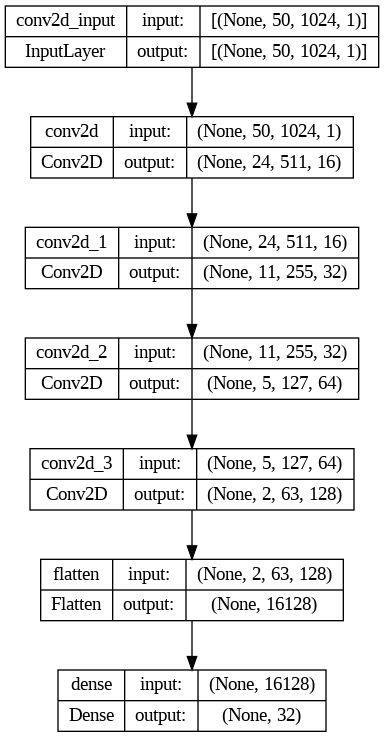

In [ ]:
print("Printing encoder model:\n")
tf.keras.utils.plot_model(
    model.encoder,
    to_file="model_encoder.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False,
)

Printing decoder model:



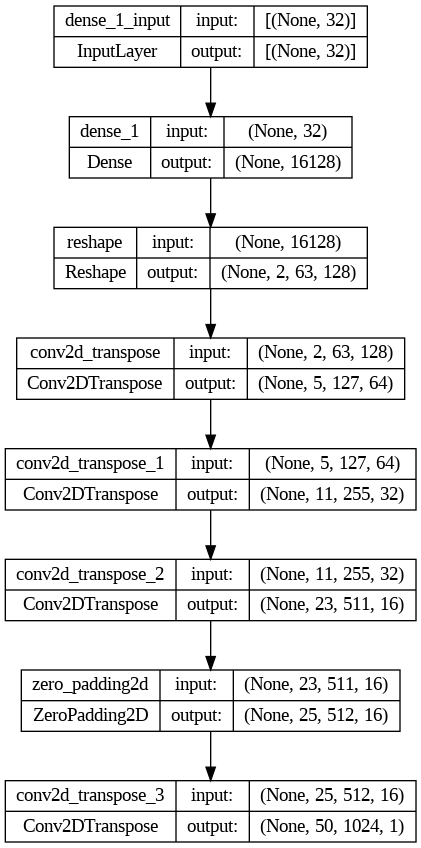

In [ ]:
print("Printing decoder model:\n")
tf.keras.utils.plot_model(
    model.decoder,
    to_file="model_decoder.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False,
)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6) ## train the network and stop with a patience of 6 monitoring the validation loss
history=model.fit(
        x=clean,
        y=clean,
        batch_size=32,
        epochs=500,
        callbacks=[callback],
        verbose=True,
        validation_data=(val,val), 
        shuffle=True,
    )

Epoch 1/500
125/125 [==============================] - 13s 46ms/step - loss: 97.1124 - val_loss: 42.7704
Epoch 2/500
125/125 [==============================] - 3s 26ms/step - loss: 42.2807 - val_loss: 42.0242
Epoch 3/500
125/125 [==============================] - 3s 25ms/step - loss: 42.1118 - val_loss: 41.7171
Epoch 4/500
125/125 [==============================] - 3s 25ms/step - loss: 41.3442 - val_loss: 41.5637
Epoch 5/500
125/125 [==============================] - 3s 26ms/step - loss: 41.4592 - val_loss: 41.1214
Epoch 6/500
125/125 [==============================] - 3s 25ms/step - loss: 40.7893 - val_loss: 40.9133
Epoch 7/500
125/125 [==============================] - 3s 24ms/step - loss: 40.7217 - val_loss: 40.6604
Epoch 8/500
125/125 [==============================] - 3s 27ms/step - loss: 40.2829 - val_loss: 40.0654
Epoch 9/500
125/125 [==============================] - 4s 33ms/step - loss: 39.5458 - val_loss: 39.6127
Epoch 10/500
125/125 [==============================] - 3s 25ms

In [ ]:
model.save("AUTOENCODER_model")

np.save("AUTOENCODER_history.npy", history.history)
print(output.OKGREEN+"Autoencoder saved"+output.END)

else:



  !unzip AUTOENCODER_model.zip

  model = keras.models.load_model("content/AUTOENCODER_model")

  history = np.load("AUTOENCODER_history.npy", allow_pickle = "TRUE").item()

  print(output.OKGREEN+"Autoencoder loaded"+output.END)
## for saving purposes: DONT EXECUTE!! 

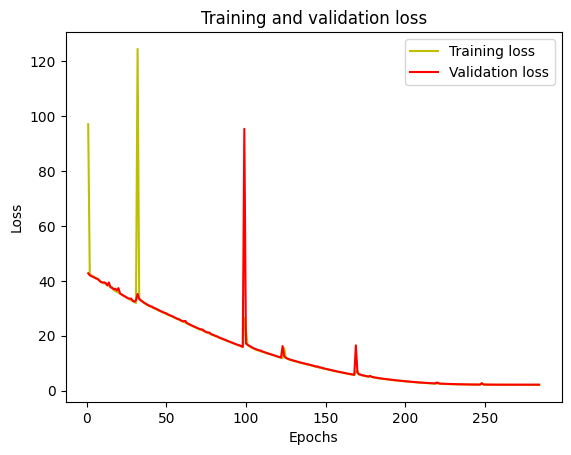

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
validation_error = model.evaluate(val,val)
anomaly_error = model.evaluate(anomalies,anomalies)
print("Validation error", validation_error)
print("Anomaly error", anomaly_error)
print("The reconstruction error of the jammed channel is ",anomaly_error/validation_error," more than the clean channel" )
## check if the reconstruction error is higher on some anomaly images

19/19 [==============================] - 1s 49ms/step - loss: 15.6226
Validation error 2.157762050628662
Anomaly error 15.622551918029785
The reconstruction error of the jammed channel is  7.240164370060252  more than the clean channel


In [ ]:
## functions that computes the mean and the stdv of the reconstruction error
def calc_recon_error(batch_images):

    recon_error_list=[]
    for im in trange(0, batch_images.shape[0]):
        
        img  = batch_images[im]
        img= img.reshape(1,50,1024,1)
        recon_error_list.append(model.evaluate(img,img))
         
    
    average_recon_error = np.mean(np.array(recon_error_list))  
    stdev_recon_error = np.std(np.array(recon_error_list)) 
    
    return average_recon_error, stdev_recon_error

In [ ]:
normal_values = calc_recon_error(np.array(val))
jammed_values = calc_recon_error(np.array(anomalies))
## compute the statistics on the reconstruction error of both cases

  0%|          | 0/1600 [00:00<?, ?it/s]

1/1 [==============================] - 1s 679ms/step - loss: 3.6024


  0%|          | 1/1600 [00:00<19:24,  1.37it/s]

1/1 [==============================] - 0s 33ms/step - loss: 1.9596


  0%|          | 2/1600 [00:01<14:03,  1.89it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9743


  0%|          | 4/1600 [00:01<06:25,  4.14it/s]

1/1 [==============================] - 0s 54ms/step - loss: 2.0097


  0%|          | 5/1600 [00:01<05:28,  4.85it/s]

1/1 [==============================] - 0s 72ms/step - loss: 2.2037


  0%|          | 6/1600 [00:01<05:40,  4.69it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9374


  0%|          | 7/1600 [00:01<04:52,  5.45it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.8448


  1%|          | 9/1600 [00:01<03:24,  7.78it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.5244


  1%|          | 11/1600 [00:02<02:48,  9.41it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.1389


  1%|          | 13/1600 [00:02<02:23, 11.06it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9733


  1%|          | 15/1600 [00:02<02:14, 11.78it/s]

1/1 [==============================] - 0s 37ms/step - loss: 1.9740


  1%|          | 17/1600 [00:02<02:13, 11.82it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.1019


  1%|          | 19/1600 [00:02<02:17, 11.51it/s]

1/1 [==============================] - 0s 36ms/step - loss: 2.0430


  1%|▏         | 21/1600 [00:02<02:19, 11.34it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.7727


  1%|▏         | 23/1600 [00:03<02:21, 11.11it/s]

1/1 [==============================] - 0s 40ms/step - loss: 2.1838


  2%|▏         | 25/1600 [00:03<02:24, 10.92it/s]

1/1 [==============================] - 0s 37ms/step - loss: 1.9306


  2%|▏         | 27/1600 [00:03<02:30, 10.47it/s]

1/1 [==============================] - 0s 45ms/step - loss: 1.9751


  2%|▏         | 29/1600 [00:03<02:29, 10.51it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.0607


  2%|▏         | 31/1600 [00:03<02:26, 10.71it/s]

1/1 [==============================] - 0s 36ms/step - loss: 1.9915


  2%|▏         | 33/1600 [00:03<02:27, 10.65it/s]

1/1 [==============================] - 0s 35ms/step - loss: 1.9576


  2%|▏         | 35/1600 [00:04<02:26, 10.66it/s]

1/1 [==============================] - 0s 37ms/step - loss: 1.9567


  2%|▏         | 37/1600 [00:04<02:26, 10.66it/s]

1/1 [==============================] - 0s 36ms/step - loss: 1.9567


  2%|▏         | 39/1600 [00:04<02:25, 10.74it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0059


  3%|▎         | 41/1600 [00:04<02:17, 11.32it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.4527


  3%|▎         | 43/1600 [00:04<02:09, 12.00it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0052


  3%|▎         | 45/1600 [00:04<02:01, 12.82it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9719


  3%|▎         | 47/1600 [00:05<01:54, 13.56it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9729


  3%|▎         | 49/1600 [00:05<01:51, 13.94it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9954


  3%|▎         | 51/1600 [00:05<01:52, 13.77it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9564


  3%|▎         | 53/1600 [00:05<01:46, 14.50it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.0089


  3%|▎         | 55/1600 [00:05<01:43, 14.89it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.5541


  4%|▎         | 57/1600 [00:05<01:43, 14.91it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.4741


  4%|▎         | 59/1600 [00:05<01:46, 14.42it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0019


  4%|▍         | 61/1600 [00:06<01:46, 14.44it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9856


  4%|▍         | 63/1600 [00:06<01:43, 14.92it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9659


  4%|▍         | 65/1600 [00:06<01:43, 14.88it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.1670


  4%|▍         | 67/1600 [00:06<01:47, 14.24it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9174


  4%|▍         | 69/1600 [00:06<01:44, 14.71it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.2224


  4%|▍         | 71/1600 [00:06<01:40, 15.17it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9501


  5%|▍         | 73/1600 [00:06<01:44, 14.61it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9610


  5%|▍         | 75/1600 [00:06<01:47, 14.18it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.2894


  5%|▍         | 77/1600 [00:07<01:46, 14.32it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.0080


  5%|▍         | 79/1600 [00:07<01:44, 14.51it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.6577


  5%|▌         | 81/1600 [00:07<01:46, 14.28it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9345


  5%|▌         | 83/1600 [00:07<01:46, 14.30it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9494


  5%|▌         | 85/1600 [00:07<01:43, 14.68it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9260


  5%|▌         | 87/1600 [00:07<01:41, 14.87it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9599


  6%|▌         | 89/1600 [00:07<01:43, 14.56it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9786


  6%|▌         | 91/1600 [00:08<01:43, 14.61it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9921


  6%|▌         | 93/1600 [00:08<01:44, 14.36it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9757


  6%|▌         | 95/1600 [00:08<01:47, 13.95it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9131


  6%|▌         | 97/1600 [00:08<01:44, 14.41it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9826


  6%|▌         | 99/1600 [00:08<01:42, 14.65it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.8862


  6%|▋         | 101/1600 [00:08<01:45, 14.21it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.8939


  6%|▋         | 103/1600 [00:08<01:46, 14.01it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9657


  7%|▋         | 105/1600 [00:09<01:45, 14.11it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9356


  7%|▋         | 107/1600 [00:09<01:44, 14.32it/s]

1/1 [==============================] - 0s 33ms/step - loss: 1.9173


  7%|▋         | 109/1600 [00:09<01:46, 14.01it/s]

1/1 [==============================] - 0s 33ms/step - loss: 1.9907


  7%|▋         | 111/1600 [00:09<01:47, 13.82it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.3837


  7%|▋         | 113/1600 [00:09<01:44, 14.25it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9950


  7%|▋         | 115/1600 [00:09<01:43, 14.35it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9831


  7%|▋         | 117/1600 [00:09<01:40, 14.76it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9720


  7%|▋         | 119/1600 [00:10<01:40, 14.72it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.2722


  8%|▊         | 121/1600 [00:10<01:41, 14.57it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.2061


  8%|▊         | 123/1600 [00:10<01:42, 14.44it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9920


  8%|▊         | 125/1600 [00:10<01:41, 14.47it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9722


  8%|▊         | 127/1600 [00:10<01:42, 14.31it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1683


  8%|▊         | 129/1600 [00:10<01:43, 14.21it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9768


  8%|▊         | 131/1600 [00:10<01:41, 14.43it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9871


  8%|▊         | 133/1600 [00:11<01:43, 14.21it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0489


  8%|▊         | 135/1600 [00:11<01:41, 14.42it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9713


  9%|▊         | 137/1600 [00:11<01:40, 14.49it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.4388


  9%|▊         | 139/1600 [00:11<01:42, 14.31it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0031


  9%|▉         | 141/1600 [00:11<01:40, 14.46it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.2706


  9%|▉         | 143/1600 [00:11<01:40, 14.51it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9555


  9%|▉         | 145/1600 [00:11<01:40, 14.52it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.5704


  9%|▉         | 147/1600 [00:11<01:43, 14.09it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.0383


  9%|▉         | 149/1600 [00:12<01:41, 14.26it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9867


  9%|▉         | 151/1600 [00:12<01:38, 14.74it/s]

1/1 [==============================] - 0s 32ms/step - loss: 3.4792


 10%|▉         | 153/1600 [00:12<01:39, 14.48it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.2700


 10%|▉         | 155/1600 [00:12<01:41, 14.25it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9987


 10%|▉         | 157/1600 [00:12<01:39, 14.52it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9935


 10%|▉         | 159/1600 [00:12<01:40, 14.40it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1169


 10%|█         | 161/1600 [00:12<01:38, 14.62it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9427


 10%|█         | 163/1600 [00:13<01:38, 14.56it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9479


 10%|█         | 165/1600 [00:13<01:36, 14.92it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.2471


 10%|█         | 167/1600 [00:13<01:35, 14.98it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9465


 11%|█         | 169/1600 [00:13<01:35, 14.96it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.5312


 11%|█         | 171/1600 [00:13<01:38, 14.47it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9760


 11%|█         | 173/1600 [00:13<01:38, 14.52it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9897


 11%|█         | 175/1600 [00:13<01:39, 14.32it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0711


 11%|█         | 177/1600 [00:14<01:41, 14.06it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9433


 11%|█         | 179/1600 [00:14<01:42, 13.85it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0462


 11%|█▏        | 181/1600 [00:14<01:41, 13.94it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.8268


 11%|█▏        | 183/1600 [00:14<01:44, 13.58it/s]

1/1 [==============================] - 0s 35ms/step - loss: 1.9865


 12%|█▏        | 185/1600 [00:14<01:49, 12.88it/s]

1/1 [==============================] - 0s 39ms/step - loss: 1.9380


 12%|█▏        | 187/1600 [00:14<02:01, 11.66it/s]

1/1 [==============================] - 0s 35ms/step - loss: 1.9831


 12%|█▏        | 189/1600 [00:15<02:04, 11.33it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.1761


 12%|█▏        | 191/1600 [00:15<02:06, 11.17it/s]

1/1 [==============================] - 0s 53ms/step - loss: 2.6527


 12%|█▏        | 193/1600 [00:15<02:10, 10.75it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.6493


 12%|█▏        | 195/1600 [00:15<02:11, 10.71it/s]

1/1 [==============================] - 0s 34ms/step - loss: 1.9240


 12%|█▏        | 197/1600 [00:15<02:09, 10.85it/s]

1/1 [==============================] - 0s 34ms/step - loss: 1.9789


 12%|█▏        | 199/1600 [00:16<02:07, 11.00it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9584


 13%|█▎        | 201/1600 [00:16<02:07, 10.94it/s]

1/1 [==============================] - 0s 35ms/step - loss: 1.9611


 13%|█▎        | 203/1600 [00:16<02:09, 10.81it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.3307


 13%|█▎        | 205/1600 [00:16<02:12, 10.56it/s]

1/1 [==============================] - 0s 41ms/step - loss: 1.9443


 13%|█▎        | 207/1600 [00:16<02:13, 10.47it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9849


 13%|█▎        | 209/1600 [00:16<02:10, 10.69it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.4164


 13%|█▎        | 211/1600 [00:17<02:01, 11.47it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0965


 13%|█▎        | 213/1600 [00:17<01:55, 12.03it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9630


 13%|█▎        | 215/1600 [00:17<01:49, 12.61it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.9603


 14%|█▎        | 217/1600 [00:17<01:47, 12.85it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9356


 14%|█▎        | 219/1600 [00:17<01:45, 13.11it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.2836


 14%|█▍        | 221/1600 [00:17<01:42, 13.40it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9625


 14%|█▍        | 223/1600 [00:17<01:42, 13.43it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9588


 14%|█▍        | 225/1600 [00:18<01:38, 13.98it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9914


 14%|█▍        | 227/1600 [00:18<01:39, 13.82it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9480


 14%|█▍        | 229/1600 [00:18<01:38, 13.88it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9344


 14%|█▍        | 231/1600 [00:18<01:38, 13.94it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9644


 15%|█▍        | 233/1600 [00:18<01:39, 13.76it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9835


 15%|█▍        | 235/1600 [00:18<01:38, 13.85it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.2624


 15%|█▍        | 237/1600 [00:18<01:38, 13.78it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0027


 15%|█▍        | 239/1600 [00:19<01:38, 13.88it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.8290


 15%|█▌        | 241/1600 [00:19<01:36, 14.01it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9703


 15%|█▌        | 243/1600 [00:19<01:36, 14.11it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9697


 15%|█▌        | 245/1600 [00:19<01:37, 13.91it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9505


 15%|█▌        | 247/1600 [00:19<01:38, 13.70it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.8564


 16%|█▌        | 249/1600 [00:19<01:37, 13.87it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9979


 16%|█▌        | 251/1600 [00:19<01:34, 14.25it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.2062


 16%|█▌        | 253/1600 [00:20<01:39, 13.60it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9499


 16%|█▌        | 255/1600 [00:20<01:38, 13.59it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0007


 16%|█▌        | 257/1600 [00:20<01:40, 13.42it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.1681


 16%|█▌        | 259/1600 [00:20<01:37, 13.72it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9707


 16%|█▋        | 261/1600 [00:20<01:39, 13.50it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.3984


 16%|█▋        | 263/1600 [00:20<01:38, 13.61it/s]

1/1 [==============================] - 0s 26ms/step - loss: 3.9582


 17%|█▋        | 265/1600 [00:21<01:37, 13.76it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0146


 17%|█▋        | 267/1600 [00:21<01:35, 14.02it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9657


 17%|█▋        | 269/1600 [00:21<01:35, 13.90it/s]

1/1 [==============================] - 0s 25ms/step - loss: 4.5294


 17%|█▋        | 271/1600 [00:21<01:33, 14.19it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.1493


 17%|█▋        | 273/1600 [00:21<01:34, 14.04it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0296


 17%|█▋        | 275/1600 [00:21<01:33, 14.18it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9198


 17%|█▋        | 277/1600 [00:21<01:34, 14.04it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9311


 17%|█▋        | 279/1600 [00:22<01:36, 13.68it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9548


 18%|█▊        | 281/1600 [00:22<01:34, 14.00it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9712


 18%|█▊        | 283/1600 [00:22<01:34, 13.97it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9507


 18%|█▊        | 285/1600 [00:22<01:33, 14.01it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9410


 18%|█▊        | 287/1600 [00:22<01:33, 14.03it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0111


 18%|█▊        | 289/1600 [00:22<01:32, 14.13it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.3655


 18%|█▊        | 291/1600 [00:22<01:32, 14.17it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1667


 18%|█▊        | 293/1600 [00:22<01:32, 14.14it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1293


 18%|█▊        | 295/1600 [00:23<01:32, 14.14it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9786


 19%|█▊        | 297/1600 [00:23<01:30, 14.35it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9212


 19%|█▊        | 299/1600 [00:23<01:29, 14.49it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9846


 19%|█▉        | 301/1600 [00:23<01:33, 13.88it/s]

1/1 [==============================] - 0s 27ms/step - loss: 3.7510


 19%|█▉        | 303/1600 [00:23<01:35, 13.62it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.8316


 19%|█▉        | 305/1600 [00:23<01:32, 14.07it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9522


 19%|█▉        | 307/1600 [00:23<01:31, 14.12it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1295


 19%|█▉        | 309/1600 [00:24<01:34, 13.72it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.2274


 19%|█▉        | 311/1600 [00:24<01:33, 13.71it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.5094


 20%|█▉        | 313/1600 [00:24<01:31, 14.10it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9672


 20%|█▉        | 315/1600 [00:24<01:31, 14.07it/s]

1/1 [==============================] - 0s 27ms/step - loss: 3.4718


 20%|█▉        | 317/1600 [00:24<01:32, 13.86it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9531


 20%|█▉        | 319/1600 [00:24<01:31, 13.95it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.1587


 20%|██        | 321/1600 [00:24<01:30, 14.12it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9659


 20%|██        | 323/1600 [00:25<01:27, 14.58it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.0213


 20%|██        | 325/1600 [00:25<01:30, 14.10it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.2480


 20%|██        | 327/1600 [00:25<01:29, 14.23it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9875


 21%|██        | 329/1600 [00:25<01:30, 14.09it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9364


 21%|██        | 331/1600 [00:25<01:30, 14.03it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9072


 21%|██        | 333/1600 [00:25<01:30, 14.07it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9799


 21%|██        | 335/1600 [00:25<01:27, 14.44it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9559


 21%|██        | 337/1600 [00:26<01:29, 14.17it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.8274


 21%|██        | 339/1600 [00:26<01:27, 14.39it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9754


 21%|██▏       | 341/1600 [00:26<01:27, 14.32it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9549


 21%|██▏       | 343/1600 [00:26<01:29, 14.01it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9611


 22%|██▏       | 345/1600 [00:26<01:30, 13.84it/s]

1/1 [==============================] - 0s 25ms/step - loss: 3.8206


 22%|██▏       | 347/1600 [00:26<01:30, 13.87it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.0367


 22%|██▏       | 349/1600 [00:27<01:46, 11.79it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.0774


 22%|██▏       | 351/1600 [00:27<01:48, 11.50it/s]

1/1 [==============================] - 0s 33ms/step - loss: 1.9950


 22%|██▏       | 353/1600 [00:27<01:52, 11.05it/s]

1/1 [==============================] - 0s 38ms/step - loss: 1.9782


 22%|██▏       | 355/1600 [00:27<01:55, 10.80it/s]

1/1 [==============================] - 0s 39ms/step - loss: 1.9388


 22%|██▏       | 357/1600 [00:27<01:59, 10.37it/s]

1/1 [==============================] - 0s 33ms/step - loss: 4.1293


 22%|██▏       | 359/1600 [00:28<02:03, 10.06it/s]

1/1 [==============================] - 0s 33ms/step - loss: 1.9182


 23%|██▎       | 361/1600 [00:28<02:00, 10.26it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9898


 23%|██▎       | 363/1600 [00:28<01:59, 10.38it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.0013


 23%|██▎       | 365/1600 [00:28<01:59, 10.35it/s]

1/1 [==============================] - 0s 38ms/step - loss: 1.9662


 23%|██▎       | 367/1600 [00:28<02:00, 10.22it/s]

1/1 [==============================] - 0s 43ms/step - loss: 3.0657


 23%|██▎       | 369/1600 [00:29<02:01, 10.10it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.3176


 23%|██▎       | 371/1600 [00:29<02:00, 10.21it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.6043


 23%|██▎       | 373/1600 [00:29<01:49, 11.18it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.3803


 23%|██▎       | 375/1600 [00:29<01:45, 11.66it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9752


 24%|██▎       | 377/1600 [00:29<01:38, 12.47it/s]

1/1 [==============================] - 0s 33ms/step - loss: 1.9699


 24%|██▎       | 379/1600 [00:29<01:34, 12.97it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9660


 24%|██▍       | 381/1600 [00:29<01:33, 13.10it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9839


 24%|██▍       | 383/1600 [00:30<01:32, 13.19it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.1750


 24%|██▍       | 385/1600 [00:30<01:30, 13.47it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9591


 24%|██▍       | 387/1600 [00:30<01:28, 13.66it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9917


 24%|██▍       | 389/1600 [00:30<01:29, 13.54it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9713


 24%|██▍       | 391/1600 [00:30<01:29, 13.44it/s]

1/1 [==============================] - 0s 34ms/step - loss: 1.9345


 25%|██▍       | 393/1600 [00:30<01:28, 13.69it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.8823


 25%|██▍       | 395/1600 [00:30<01:27, 13.73it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9561


 25%|██▍       | 397/1600 [00:31<01:27, 13.80it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9340


 25%|██▍       | 399/1600 [00:31<01:26, 13.94it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9905


 25%|██▌       | 401/1600 [00:31<01:26, 13.92it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.0297


 25%|██▌       | 403/1600 [00:31<01:27, 13.66it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9692


 25%|██▌       | 405/1600 [00:31<01:26, 13.87it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.1698


 25%|██▌       | 407/1600 [00:31<01:28, 13.47it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9361


 26%|██▌       | 409/1600 [00:31<01:26, 13.76it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9403


 26%|██▌       | 411/1600 [00:32<01:26, 13.69it/s]

1/1 [==============================] - 0s 27ms/step - loss: 4.1269


 26%|██▌       | 413/1600 [00:32<01:26, 13.70it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9343


 26%|██▌       | 415/1600 [00:32<01:26, 13.68it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9470


 26%|██▌       | 417/1600 [00:32<01:24, 13.95it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0406


 26%|██▌       | 419/1600 [00:32<01:24, 14.05it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.3220


 26%|██▋       | 421/1600 [00:32<01:27, 13.51it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.2629


 26%|██▋       | 423/1600 [00:32<01:25, 13.70it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9765


 27%|██▋       | 425/1600 [00:33<01:28, 13.34it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0162


 27%|██▋       | 427/1600 [00:33<01:25, 13.79it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9890


 27%|██▋       | 429/1600 [00:33<01:26, 13.58it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1369


 27%|██▋       | 431/1600 [00:33<01:25, 13.69it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9709


 27%|██▋       | 433/1600 [00:33<01:24, 13.84it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1439


 27%|██▋       | 435/1600 [00:33<01:24, 13.81it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.3114


 27%|██▋       | 437/1600 [00:34<01:25, 13.62it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9469


 27%|██▋       | 439/1600 [00:34<01:23, 13.96it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1421


 28%|██▊       | 441/1600 [00:34<01:21, 14.16it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9794


 28%|██▊       | 443/1600 [00:34<01:21, 14.21it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9636


 28%|██▊       | 445/1600 [00:34<01:22, 13.98it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.3662


 28%|██▊       | 447/1600 [00:34<01:23, 13.74it/s]

1/1 [==============================] - 0s 31ms/step - loss: 3.4850


 28%|██▊       | 449/1600 [00:34<01:23, 13.82it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9564


 28%|██▊       | 451/1600 [00:35<01:22, 13.96it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9144


 28%|██▊       | 453/1600 [00:35<01:23, 13.80it/s]

1/1 [==============================] - 0s 27ms/step - loss: 4.1842


 28%|██▊       | 455/1600 [00:35<01:24, 13.57it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.4592


 29%|██▊       | 457/1600 [00:35<01:21, 14.09it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.3336


 29%|██▊       | 459/1600 [00:35<01:19, 14.29it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1422


 29%|██▉       | 461/1600 [00:35<01:20, 14.23it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9961


 29%|██▉       | 463/1600 [00:35<01:21, 13.90it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0963


 29%|██▉       | 465/1600 [00:36<01:20, 14.10it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.5360


 29%|██▉       | 467/1600 [00:36<01:23, 13.63it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.0023


 29%|██▉       | 469/1600 [00:36<01:22, 13.72it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.3315


 29%|██▉       | 471/1600 [00:36<01:21, 13.82it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0384


 30%|██▉       | 473/1600 [00:36<01:21, 13.83it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9645


 30%|██▉       | 475/1600 [00:36<01:22, 13.65it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9544


 30%|██▉       | 477/1600 [00:36<01:20, 13.93it/s]

1/1 [==============================] - 0s 29ms/step - loss: 3.8048


 30%|██▉       | 479/1600 [00:37<01:24, 13.28it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.0602


 30%|███       | 481/1600 [00:37<01:25, 13.05it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.5552


 30%|███       | 483/1600 [00:37<01:25, 13.09it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9622


 30%|███       | 485/1600 [00:37<01:24, 13.19it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9594


 30%|███       | 487/1600 [00:37<01:24, 13.22it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9723


 31%|███       | 489/1600 [00:37<01:21, 13.61it/s]

1/1 [==============================] - 0s 34ms/step - loss: 1.9545


 31%|███       | 491/1600 [00:37<01:21, 13.62it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9443


 31%|███       | 493/1600 [00:38<01:19, 13.99it/s]

1/1 [==============================] - 0s 33ms/step - loss: 1.9185


 31%|███       | 495/1600 [00:38<01:21, 13.56it/s]

1/1 [==============================] - 0s 33ms/step - loss: 1.9536


 31%|███       | 497/1600 [00:38<01:21, 13.55it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0850


 31%|███       | 499/1600 [00:38<01:20, 13.68it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9526


 31%|███▏      | 501/1600 [00:38<01:20, 13.67it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9727


 31%|███▏      | 503/1600 [00:38<01:22, 13.28it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9932


 32%|███▏      | 505/1600 [00:39<01:23, 13.10it/s]

1/1 [==============================] - 0s 26ms/step - loss: 4.3305


 32%|███▏      | 507/1600 [00:39<01:22, 13.31it/s]

1/1 [==============================] - 0s 36ms/step - loss: 1.9700


 32%|███▏      | 509/1600 [00:39<01:29, 12.18it/s]

1/1 [==============================] - 0s 40ms/step - loss: 4.7684


 32%|███▏      | 511/1600 [00:39<01:35, 11.41it/s]

1/1 [==============================] - 0s 33ms/step - loss: 1.9522


 32%|███▏      | 513/1600 [00:39<01:38, 11.07it/s]

1/1 [==============================] - 0s 37ms/step - loss: 1.9181


 32%|███▏      | 515/1600 [00:39<01:37, 11.13it/s]

1/1 [==============================] - 0s 38ms/step - loss: 1.9393


 32%|███▏      | 517/1600 [00:40<01:39, 10.90it/s]

1/1 [==============================] - 0s 38ms/step - loss: 1.9472


 32%|███▏      | 519/1600 [00:40<01:43, 10.46it/s]

1/1 [==============================] - 0s 36ms/step - loss: 1.9437


 33%|███▎      | 521/1600 [00:40<01:44, 10.28it/s]

1/1 [==============================] - 0s 35ms/step - loss: 3.3412


 33%|███▎      | 523/1600 [00:40<01:41, 10.60it/s]

1/1 [==============================] - 0s 37ms/step - loss: 1.9959


 33%|███▎      | 525/1600 [00:40<01:40, 10.65it/s]

1/1 [==============================] - 0s 42ms/step - loss: 3.5934


 33%|███▎      | 527/1600 [00:41<01:44, 10.27it/s]

1/1 [==============================] - 0s 40ms/step - loss: 1.9671


 33%|███▎      | 529/1600 [00:41<01:44, 10.24it/s]

1/1 [==============================] - 0s 33ms/step - loss: 4.3521


 33%|███▎      | 531/1600 [00:41<01:43, 10.35it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9785


 33%|███▎      | 533/1600 [00:41<01:40, 10.59it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9882


 33%|███▎      | 535/1600 [00:41<01:34, 11.23it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0908


 34%|███▎      | 537/1600 [00:41<01:29, 11.84it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9830


 34%|███▎      | 539/1600 [00:42<01:26, 12.21it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9705


 34%|███▍      | 541/1600 [00:42<01:22, 12.84it/s]

1/1 [==============================] - 0s 30ms/step - loss: 4.3169


 34%|███▍      | 543/1600 [00:42<01:23, 12.71it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9642


 34%|███▍      | 545/1600 [00:42<01:20, 13.05it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9186


 34%|███▍      | 547/1600 [00:42<01:19, 13.27it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9587


 34%|███▍      | 549/1600 [00:42<01:17, 13.60it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.4859


 34%|███▍      | 551/1600 [00:42<01:18, 13.43it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.4256


 35%|███▍      | 553/1600 [00:43<01:18, 13.26it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.0336


 35%|███▍      | 555/1600 [00:43<01:17, 13.49it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9645


 35%|███▍      | 557/1600 [00:43<01:15, 13.77it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9810


 35%|███▍      | 559/1600 [00:43<01:16, 13.62it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9583


 35%|███▌      | 561/1600 [00:43<01:17, 13.43it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0650


 35%|███▌      | 563/1600 [00:43<01:15, 13.68it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9396


 35%|███▌      | 565/1600 [00:44<01:17, 13.43it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9797


 35%|███▌      | 567/1600 [00:44<01:18, 13.23it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9676


 36%|███▌      | 569/1600 [00:44<01:16, 13.40it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9734


 36%|███▌      | 571/1600 [00:44<01:15, 13.59it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.8944


 36%|███▌      | 573/1600 [00:44<01:15, 13.62it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9511


 36%|███▌      | 575/1600 [00:44<01:14, 13.71it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9295


 36%|███▌      | 577/1600 [00:44<01:15, 13.54it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.4127


 36%|███▌      | 579/1600 [00:45<01:13, 13.86it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9915


 36%|███▋      | 581/1600 [00:45<01:14, 13.70it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.5392


 36%|███▋      | 583/1600 [00:45<01:15, 13.54it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9183


 37%|███▋      | 585/1600 [00:45<01:16, 13.33it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9734


 37%|███▋      | 587/1600 [00:45<01:16, 13.24it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9820


 37%|███▋      | 589/1600 [00:45<01:15, 13.43it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.2045


 37%|███▋      | 591/1600 [00:45<01:15, 13.29it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9672


 37%|███▋      | 593/1600 [00:46<01:15, 13.38it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9279


 37%|███▋      | 595/1600 [00:46<01:15, 13.27it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9685


 37%|███▋      | 597/1600 [00:46<01:14, 13.46it/s]

1/1 [==============================] - 0s 29ms/step - loss: 3.6524


 37%|███▋      | 599/1600 [00:46<01:15, 13.30it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.2927


 38%|███▊      | 601/1600 [00:46<01:14, 13.37it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9849


 38%|███▊      | 603/1600 [00:46<01:14, 13.46it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9369


 38%|███▊      | 605/1600 [00:47<01:15, 13.12it/s]

1/1 [==============================] - 0s 35ms/step - loss: 1.9429


 38%|███▊      | 607/1600 [00:47<01:16, 12.91it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9892


 38%|███▊      | 609/1600 [00:47<01:16, 13.02it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9568


 38%|███▊      | 611/1600 [00:47<01:14, 13.25it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0024


 38%|███▊      | 613/1600 [00:47<01:14, 13.23it/s]

1/1 [==============================] - 0s 28ms/step - loss: 3.0488


 38%|███▊      | 615/1600 [00:47<01:14, 13.20it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.6160


 39%|███▊      | 617/1600 [00:47<01:14, 13.12it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9477


 39%|███▊      | 619/1600 [00:48<01:13, 13.27it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.2533


 39%|███▉      | 621/1600 [00:48<01:12, 13.41it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.2017


 39%|███▉      | 623/1600 [00:48<01:11, 13.59it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9740


 39%|███▉      | 625/1600 [00:48<01:13, 13.23it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.5618


 39%|███▉      | 627/1600 [00:48<01:13, 13.26it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.2300


 39%|███▉      | 629/1600 [00:48<01:11, 13.52it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9361


 39%|███▉      | 631/1600 [00:48<01:12, 13.42it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.0040


 40%|███▉      | 633/1600 [00:49<01:13, 13.15it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9604


 40%|███▉      | 635/1600 [00:49<01:14, 12.99it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.8404


 40%|███▉      | 637/1600 [00:49<01:13, 13.19it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.5626


 40%|███▉      | 639/1600 [00:49<01:12, 13.25it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9679


 40%|████      | 641/1600 [00:49<01:11, 13.39it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9537


 40%|████      | 643/1600 [00:49<01:10, 13.60it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9935


 40%|████      | 645/1600 [00:50<01:10, 13.58it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9755


 40%|████      | 647/1600 [00:50<01:09, 13.80it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0770


 41%|████      | 649/1600 [00:50<01:10, 13.44it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9673


 41%|████      | 651/1600 [00:50<01:09, 13.59it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.2195


 41%|████      | 653/1600 [00:50<01:09, 13.69it/s]

1/1 [==============================] - 0s 28ms/step - loss: 5.4406


 41%|████      | 655/1600 [00:50<01:09, 13.67it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9914


 41%|████      | 657/1600 [00:50<01:10, 13.43it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9598


 41%|████      | 659/1600 [00:51<01:09, 13.59it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.0346


 41%|████▏     | 661/1600 [00:51<01:08, 13.76it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1899


 41%|████▏     | 663/1600 [00:51<01:09, 13.55it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.4962


 42%|████▏     | 665/1600 [00:51<01:09, 13.55it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9696


 42%|████▏     | 667/1600 [00:51<01:09, 13.49it/s]

1/1 [==============================] - 0s 42ms/step - loss: 1.9201


 42%|████▏     | 669/1600 [00:51<01:18, 11.87it/s]

1/1 [==============================] - 0s 44ms/step - loss: 2.1467


 42%|████▏     | 671/1600 [00:52<01:24, 11.06it/s]

1/1 [==============================] - 0s 49ms/step - loss: 1.9520


 42%|████▏     | 673/1600 [00:52<01:27, 10.59it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9665


 42%|████▏     | 675/1600 [00:52<01:26, 10.72it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.0431


 42%|████▏     | 677/1600 [00:52<01:26, 10.66it/s]

1/1 [==============================] - 0s 36ms/step - loss: 1.9306


 42%|████▏     | 679/1600 [00:52<01:26, 10.62it/s]

1/1 [==============================] - 0s 40ms/step - loss: 1.9616


 43%|████▎     | 681/1600 [00:53<01:29, 10.29it/s]

1/1 [==============================] - 0s 41ms/step - loss: 1.9859


 43%|████▎     | 683/1600 [00:53<01:29, 10.30it/s]

1/1 [==============================] - 0s 34ms/step - loss: 1.9348


 43%|████▎     | 685/1600 [00:53<01:30, 10.06it/s]

1/1 [==============================] - 0s 37ms/step - loss: 1.9832


 43%|████▎     | 687/1600 [00:53<01:29, 10.25it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.3389


 43%|████▎     | 689/1600 [00:53<01:30, 10.03it/s]

1/1 [==============================] - 0s 37ms/step - loss: 1.9310


 43%|████▎     | 691/1600 [00:54<01:32,  9.82it/s]

1/1 [==============================] - 0s 41ms/step - loss: 2.6884


 43%|████▎     | 692/1600 [00:54<01:33,  9.74it/s]

1/1 [==============================] - 0s 33ms/step - loss: 1.9575


 43%|████▎     | 694/1600 [00:54<01:25, 10.64it/s]

1/1 [==============================] - 0s 28ms/step - loss: 3.5701


 44%|████▎     | 696/1600 [00:54<01:20, 11.24it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.2373


 44%|████▎     | 698/1600 [00:54<01:19, 11.39it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.6513


 44%|████▍     | 700/1600 [00:54<01:15, 11.88it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1396


 44%|████▍     | 702/1600 [00:54<01:13, 12.24it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0012


 44%|████▍     | 704/1600 [00:55<01:10, 12.64it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9756


 44%|████▍     | 706/1600 [00:55<01:10, 12.69it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.3545


 44%|████▍     | 708/1600 [00:55<01:11, 12.39it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9671


 44%|████▍     | 710/1600 [00:55<01:09, 12.85it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9752


 44%|████▍     | 712/1600 [00:55<01:07, 13.10it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9860


 45%|████▍     | 714/1600 [00:55<01:07, 13.11it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.5434


 45%|████▍     | 716/1600 [00:56<01:09, 12.78it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9400


 45%|████▍     | 718/1600 [00:56<01:07, 13.07it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.1114


 45%|████▌     | 720/1600 [00:56<01:05, 13.40it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0048


 45%|████▌     | 722/1600 [00:56<01:05, 13.36it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0587


 45%|████▌     | 724/1600 [00:56<01:04, 13.57it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.1016


 45%|████▌     | 726/1600 [00:56<01:03, 13.77it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.5952


 46%|████▌     | 728/1600 [00:56<01:02, 13.91it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.3487


 46%|████▌     | 730/1600 [00:57<01:04, 13.52it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9752


 46%|████▌     | 732/1600 [00:57<01:03, 13.74it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9639


 46%|████▌     | 734/1600 [00:57<01:03, 13.57it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9850


 46%|████▌     | 736/1600 [00:57<01:04, 13.43it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9675


 46%|████▌     | 738/1600 [00:57<01:04, 13.31it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9424


 46%|████▋     | 740/1600 [00:57<01:02, 13.67it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.4000


 46%|████▋     | 742/1600 [00:57<01:02, 13.72it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9976


 46%|████▋     | 744/1600 [00:58<01:03, 13.43it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9159


 47%|████▋     | 746/1600 [00:58<01:03, 13.52it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.8868


 47%|████▋     | 748/1600 [00:58<01:02, 13.70it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9422


 47%|████▋     | 750/1600 [00:58<01:03, 13.38it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0064


 47%|████▋     | 752/1600 [00:58<01:02, 13.64it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.2362


 47%|████▋     | 754/1600 [00:58<01:02, 13.63it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9691


 47%|████▋     | 756/1600 [00:58<01:02, 13.41it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0691


 47%|████▋     | 758/1600 [00:59<01:03, 13.32it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9412


 48%|████▊     | 760/1600 [00:59<01:03, 13.28it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.3674


 48%|████▊     | 762/1600 [00:59<01:02, 13.50it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9417


 48%|████▊     | 764/1600 [00:59<01:04, 12.91it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9724


 48%|████▊     | 766/1600 [00:59<01:02, 13.24it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.2812


 48%|████▊     | 768/1600 [00:59<01:01, 13.63it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9956


 48%|████▊     | 770/1600 [01:00<01:02, 13.28it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.6175


 48%|████▊     | 772/1600 [01:00<01:03, 12.94it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9410


 48%|████▊     | 774/1600 [01:00<01:03, 13.10it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.5125


 48%|████▊     | 776/1600 [01:00<01:03, 13.01it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9481


 49%|████▊     | 778/1600 [01:00<01:02, 13.05it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0723


 49%|████▉     | 780/1600 [01:00<01:09, 11.87it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9372


 49%|████▉     | 782/1600 [01:00<01:06, 12.26it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9011


 49%|████▉     | 784/1600 [01:01<01:04, 12.68it/s]

1/1 [==============================] - 0s 31ms/step - loss: 1.9449


 49%|████▉     | 786/1600 [01:01<01:03, 12.83it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.6565


 49%|████▉     | 788/1600 [01:01<01:03, 12.70it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.3960


 49%|████▉     | 790/1600 [01:01<01:03, 12.76it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.0114


 50%|████▉     | 792/1600 [01:01<01:02, 12.94it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9659


 50%|████▉     | 794/1600 [01:01<01:01, 13.11it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9709


 50%|████▉     | 796/1600 [01:02<01:02, 12.84it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9640


 50%|████▉     | 798/1600 [01:02<01:02, 12.82it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1632


 50%|█████     | 800/1600 [01:02<01:01, 13.01it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.0281


 50%|█████     | 802/1600 [01:02<01:01, 13.04it/s]

1/1 [==============================] - 0s 28ms/step - loss: 5.7222


 50%|█████     | 804/1600 [01:02<01:01, 12.88it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9450


 50%|█████     | 806/1600 [01:02<01:00, 13.14it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.5077


 50%|█████     | 808/1600 [01:02<01:00, 13.01it/s]

1/1 [==============================] - 0s 28ms/step - loss: 3.8641


 51%|█████     | 810/1600 [01:03<01:00, 13.02it/s]

1/1 [==============================] - 0s 34ms/step - loss: 1.9421


 51%|█████     | 812/1600 [01:03<01:44,  7.55it/s]

1/1 [==============================] - 0s 36ms/step - loss: 2.2721


 51%|█████     | 814/1600 [01:03<01:32,  8.47it/s]

1/1 [==============================] - 0s 35ms/step - loss: 1.9820


 51%|█████     | 816/1600 [01:03<01:24,  9.25it/s]

1/1 [==============================] - 0s 51ms/step - loss: 2.1009


 51%|█████     | 818/1600 [01:04<01:20,  9.68it/s]

1/1 [==============================] - 0s 43ms/step - loss: 2.6125


 51%|█████▏    | 820/1600 [01:04<01:24,  9.18it/s]

1/1 [==============================] - 0s 40ms/step - loss: 1.9531


 51%|█████▏    | 822/1600 [01:04<01:25,  9.07it/s]

1/1 [==============================] - 0s 40ms/step - loss: 1.9868


 51%|█████▏    | 823/1600 [01:04<01:25,  9.12it/s]

1/1 [==============================] - 0s 40ms/step - loss: 2.1999


 52%|█████▏    | 824/1600 [01:04<01:24,  9.20it/s]

1/1 [==============================] - 0s 41ms/step - loss: 1.9721


 52%|█████▏    | 825/1600 [01:04<01:26,  8.99it/s]

1/1 [==============================] - 0s 40ms/step - loss: 1.9507


 52%|█████▏    | 826/1600 [01:05<01:26,  8.99it/s]

1/1 [==============================] - 0s 40ms/step - loss: 1.9638


 52%|█████▏    | 827/1600 [01:05<01:24,  9.13it/s]

1/1 [==============================] - 0s 46ms/step - loss: 2.4168


 52%|█████▏    | 828/1600 [01:05<01:26,  8.90it/s]

1/1 [==============================] - 0s 40ms/step - loss: 1.9584


 52%|█████▏    | 829/1600 [01:05<01:26,  8.94it/s]

1/1 [==============================] - 0s 39ms/step - loss: 1.9584


 52%|█████▏    | 830/1600 [01:05<01:25,  9.03it/s]

1/1 [==============================] - 0s 40ms/step - loss: 1.9376


 52%|█████▏    | 831/1600 [01:05<01:25,  8.98it/s]

1/1 [==============================] - 0s 43ms/step - loss: 2.0388


 52%|█████▏    | 832/1600 [01:05<01:27,  8.78it/s]

1/1 [==============================] - 0s 41ms/step - loss: 1.9707


 52%|█████▏    | 833/1600 [01:05<01:28,  8.71it/s]

1/1 [==============================] - 0s 45ms/step - loss: 1.9427


 52%|█████▏    | 834/1600 [01:05<01:28,  8.67it/s]

1/1 [==============================] - 0s 43ms/step - loss: 2.9342


 52%|█████▏    | 835/1600 [01:06<01:26,  8.86it/s]

1/1 [==============================] - 0s 40ms/step - loss: 1.9658


 52%|█████▏    | 836/1600 [01:06<01:29,  8.54it/s]

1/1 [==============================] - 0s 41ms/step - loss: 1.9871


 52%|█████▏    | 837/1600 [01:06<01:29,  8.54it/s]

1/1 [==============================] - 0s 44ms/step - loss: 1.9414


 52%|█████▏    | 838/1600 [01:06<01:27,  8.71it/s]

1/1 [==============================] - 0s 43ms/step - loss: 1.9381


 52%|█████▏    | 839/1600 [01:06<01:27,  8.69it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9806


 53%|█████▎    | 841/1600 [01:06<01:19,  9.56it/s]

1/1 [==============================] - 0s 35ms/step - loss: 1.9378


 53%|█████▎    | 843/1600 [01:06<01:13, 10.29it/s]

1/1 [==============================] - 0s 35ms/step - loss: 1.9543


 53%|█████▎    | 845/1600 [01:07<01:11, 10.49it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.1202


 53%|█████▎    | 847/1600 [01:07<01:09, 10.87it/s]

1/1 [==============================] - 0s 38ms/step - loss: 1.9247


 53%|█████▎    | 849/1600 [01:07<01:09, 10.87it/s]

1/1 [==============================] - 0s 44ms/step - loss: 2.3200


 53%|█████▎    | 851/1600 [01:07<01:09, 10.74it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.1605


 53%|█████▎    | 853/1600 [01:07<01:09, 10.78it/s]

1/1 [==============================] - 0s 35ms/step - loss: 1.9685


 53%|█████▎    | 855/1600 [01:08<01:06, 11.16it/s]

1/1 [==============================] - 0s 35ms/step - loss: 1.9634


 54%|█████▎    | 857/1600 [01:08<01:04, 11.45it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.0121


 54%|█████▎    | 859/1600 [01:08<01:05, 11.34it/s]

1/1 [==============================] - 0s 34ms/step - loss: 1.9764


 54%|█████▍    | 861/1600 [01:08<01:05, 11.29it/s]

1/1 [==============================] - 0s 36ms/step - loss: 2.4352


 54%|█████▍    | 863/1600 [01:08<01:04, 11.40it/s]

1/1 [==============================] - 0s 35ms/step - loss: 1.9739


 54%|█████▍    | 865/1600 [01:08<01:03, 11.62it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.1412


 54%|█████▍    | 867/1600 [01:09<01:03, 11.63it/s]

1/1 [==============================] - 0s 34ms/step - loss: 1.9956


 54%|█████▍    | 869/1600 [01:09<01:02, 11.62it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.0116


 54%|█████▍    | 871/1600 [01:09<01:02, 11.59it/s]

1/1 [==============================] - 0s 39ms/step - loss: 3.6651


 55%|█████▍    | 873/1600 [01:09<01:03, 11.47it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0269


 55%|█████▍    | 875/1600 [01:09<01:03, 11.50it/s]

1/1 [==============================] - 0s 37ms/step - loss: 1.9171


 55%|█████▍    | 877/1600 [01:09<01:02, 11.54it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9935


 55%|█████▍    | 879/1600 [01:10<01:00, 11.84it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.1767


 55%|█████▌    | 881/1600 [01:10<01:00, 11.81it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.0202


 55%|█████▌    | 883/1600 [01:10<01:00, 11.92it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9634


 55%|█████▌    | 885/1600 [01:10<00:59, 12.05it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.1258


 55%|█████▌    | 887/1600 [01:10<00:58, 12.18it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0753


 56%|█████▌    | 889/1600 [01:10<00:57, 12.38it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.1076


 56%|█████▌    | 891/1600 [01:11<00:56, 12.55it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9660


 56%|█████▌    | 893/1600 [01:11<00:56, 12.53it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9112


 56%|█████▌    | 895/1600 [01:11<00:55, 12.81it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.2013


 56%|█████▌    | 897/1600 [01:11<00:54, 12.86it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9590


 56%|█████▌    | 899/1600 [01:11<00:54, 12.95it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.0800


 56%|█████▋    | 901/1600 [01:11<00:54, 12.81it/s]

1/1 [==============================] - 0s 31ms/step - loss: 1.9791


 56%|█████▋    | 903/1600 [01:11<00:55, 12.59it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9343


 57%|█████▋    | 905/1600 [01:12<00:55, 12.59it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9788


 57%|█████▋    | 907/1600 [01:12<00:54, 12.61it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9684


 57%|█████▋    | 909/1600 [01:12<00:53, 12.84it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.3875


 57%|█████▋    | 911/1600 [01:12<00:54, 12.56it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9628


 57%|█████▋    | 913/1600 [01:12<00:54, 12.60it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.0486


 57%|█████▋    | 915/1600 [01:12<00:53, 12.77it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9683


 57%|█████▋    | 917/1600 [01:13<00:52, 12.91it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.9738


 57%|█████▋    | 919/1600 [01:13<00:52, 12.86it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9469


 58%|█████▊    | 921/1600 [01:13<00:51, 13.14it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9792


 58%|█████▊    | 923/1600 [01:13<00:50, 13.30it/s]

1/1 [==============================] - 0s 22ms/step - loss: 1.9654


 58%|█████▊    | 925/1600 [01:13<00:51, 13.18it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9576


 58%|█████▊    | 927/1600 [01:13<00:52, 12.87it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9522


 58%|█████▊    | 929/1600 [01:13<00:51, 13.09it/s]

1/1 [==============================] - 0s 29ms/step - loss: 3.4818


 58%|█████▊    | 931/1600 [01:14<00:50, 13.29it/s]

1/1 [==============================] - 0s 28ms/step - loss: 3.6191


 58%|█████▊    | 933/1600 [01:14<00:49, 13.36it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9657


 58%|█████▊    | 935/1600 [01:14<00:49, 13.32it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.1607


 59%|█████▊    | 937/1600 [01:14<00:50, 13.13it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.8305


 59%|█████▊    | 939/1600 [01:14<00:50, 13.16it/s]

1/1 [==============================] - 0s 25ms/step - loss: 4.1140


 59%|█████▉    | 941/1600 [01:14<00:50, 13.04it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9377


 59%|█████▉    | 943/1600 [01:15<00:50, 13.11it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9872


 59%|█████▉    | 945/1600 [01:15<00:49, 13.33it/s]

1/1 [==============================] - 0s 31ms/step - loss: 1.9610


 59%|█████▉    | 947/1600 [01:15<00:49, 13.26it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9842


 59%|█████▉    | 949/1600 [01:15<00:48, 13.50it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.1876


 59%|█████▉    | 951/1600 [01:15<00:48, 13.32it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.3427


 60%|█████▉    | 953/1600 [01:15<00:48, 13.46it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.5305


 60%|█████▉    | 955/1600 [01:15<00:47, 13.62it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9560


 60%|█████▉    | 957/1600 [01:16<00:47, 13.59it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.4290


 60%|█████▉    | 959/1600 [01:16<00:47, 13.47it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9534


 60%|██████    | 961/1600 [01:16<00:47, 13.39it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.0019


 60%|██████    | 963/1600 [01:16<00:47, 13.29it/s]

1/1 [==============================] - 0s 43ms/step - loss: 1.9719


 60%|██████    | 965/1600 [01:16<00:50, 12.68it/s]

1/1 [==============================] - 0s 43ms/step - loss: 1.9602


 60%|██████    | 967/1600 [01:16<00:58, 10.74it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.1587


 61%|██████    | 969/1600 [01:17<01:00, 10.39it/s]

1/1 [==============================] - 0s 36ms/step - loss: 1.9924


 61%|██████    | 971/1600 [01:17<01:01, 10.21it/s]

1/1 [==============================] - 0s 38ms/step - loss: 1.9275


 61%|██████    | 973/1600 [01:17<01:05,  9.59it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9776


 61%|██████    | 974/1600 [01:17<01:06,  9.48it/s]

1/1 [==============================] - 0s 36ms/step - loss: 3.2376


 61%|██████    | 975/1600 [01:17<01:06,  9.36it/s]

1/1 [==============================] - 0s 39ms/step - loss: 1.9601


 61%|██████    | 976/1600 [01:17<01:05,  9.46it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.0106


 61%|██████    | 977/1600 [01:18<01:07,  9.25it/s]

1/1 [==============================] - 0s 41ms/step - loss: 1.9677


 61%|██████    | 978/1600 [01:18<01:10,  8.84it/s]

1/1 [==============================] - 0s 38ms/step - loss: 1.9745


 61%|██████    | 979/1600 [01:18<01:09,  8.98it/s]

1/1 [==============================] - 0s 37ms/step - loss: 1.9865


 61%|██████▏   | 980/1600 [01:18<01:09,  8.95it/s]

1/1 [==============================] - 0s 37ms/step - loss: 1.7753


 61%|██████▏   | 981/1600 [01:18<01:08,  9.03it/s]

1/1 [==============================] - 0s 35ms/step - loss: 1.9731


 61%|██████▏   | 982/1600 [01:18<01:06,  9.26it/s]

1/1 [==============================] - 0s 37ms/step - loss: 8.5935


 61%|██████▏   | 983/1600 [01:18<01:06,  9.28it/s]

1/1 [==============================] - 0s 40ms/step - loss: 2.1882


 62%|██████▏   | 984/1600 [01:18<01:07,  9.07it/s]

1/1 [==============================] - 0s 51ms/step - loss: 2.5310


 62%|██████▏   | 985/1600 [01:18<01:11,  8.66it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.5311


 62%|██████▏   | 987/1600 [01:19<01:06,  9.20it/s]

1/1 [==============================] - 0s 33ms/step - loss: 1.9684


 62%|██████▏   | 988/1600 [01:19<01:05,  9.36it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.4556


 62%|██████▏   | 989/1600 [01:19<01:04,  9.43it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1883


 62%|██████▏   | 991/1600 [01:19<00:59, 10.31it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9583


 62%|██████▏   | 993/1600 [01:19<00:55, 11.01it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9582


 62%|██████▏   | 995/1600 [01:19<00:52, 11.59it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9974


 62%|██████▏   | 997/1600 [01:19<00:50, 12.04it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.4911


 62%|██████▏   | 999/1600 [01:20<00:48, 12.33it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.6823


 63%|██████▎   | 1001/1600 [01:20<00:47, 12.72it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9417


 63%|██████▎   | 1003/1600 [01:20<00:45, 13.03it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.3870


 63%|██████▎   | 1005/1600 [01:20<00:46, 12.87it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9589


 63%|██████▎   | 1007/1600 [01:20<00:45, 12.96it/s]

1/1 [==============================] - 0s 36ms/step - loss: 1.9727


 63%|██████▎   | 1009/1600 [01:20<00:46, 12.72it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9690


 63%|██████▎   | 1011/1600 [01:21<00:48, 12.07it/s]

1/1 [==============================] - 0s 33ms/step - loss: 1.9536


 63%|██████▎   | 1013/1600 [01:21<00:48, 12.09it/s]

1/1 [==============================] - 0s 29ms/step - loss: 3.4121


 63%|██████▎   | 1015/1600 [01:21<00:47, 12.26it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.2880


 64%|██████▎   | 1017/1600 [01:21<00:47, 12.29it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.2795


 64%|██████▎   | 1019/1600 [01:21<00:46, 12.52it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9600


 64%|██████▍   | 1021/1600 [01:21<00:46, 12.52it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.3306


 64%|██████▍   | 1023/1600 [01:22<00:46, 12.36it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0615


 64%|██████▍   | 1025/1600 [01:22<00:45, 12.56it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9626


 64%|██████▍   | 1027/1600 [01:22<00:44, 12.93it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9542


 64%|██████▍   | 1029/1600 [01:22<00:43, 12.99it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9609


 64%|██████▍   | 1031/1600 [01:22<00:43, 13.13it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.8725


 65%|██████▍   | 1033/1600 [01:22<00:44, 12.83it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9983


 65%|██████▍   | 1035/1600 [01:22<00:44, 12.68it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1655


 65%|██████▍   | 1037/1600 [01:23<00:43, 12.83it/s]

1/1 [==============================] - 0s 26ms/step - loss: 3.2841


 65%|██████▍   | 1039/1600 [01:23<00:43, 12.99it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9791


 65%|██████▌   | 1041/1600 [01:23<00:43, 12.73it/s]

1/1 [==============================] - 0s 31ms/step - loss: 1.9489


 65%|██████▌   | 1043/1600 [01:23<00:42, 12.96it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9325


 65%|██████▌   | 1045/1600 [01:23<00:43, 12.90it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.2319


 65%|██████▌   | 1047/1600 [01:23<00:42, 13.01it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1423


 66%|██████▌   | 1049/1600 [01:24<00:42, 12.93it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9566


 66%|██████▌   | 1051/1600 [01:24<00:42, 13.00it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9816


 66%|██████▌   | 1053/1600 [01:24<00:41, 13.04it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1613


 66%|██████▌   | 1055/1600 [01:24<00:42, 12.95it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.2861


 66%|██████▌   | 1057/1600 [01:24<00:41, 13.04it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9984


 66%|██████▌   | 1059/1600 [01:24<00:41, 12.93it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0726


 66%|██████▋   | 1061/1600 [01:24<00:41, 12.98it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9342


 66%|██████▋   | 1063/1600 [01:25<00:42, 12.68it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9444


 67%|██████▋   | 1065/1600 [01:25<00:42, 12.53it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0507


 67%|██████▋   | 1067/1600 [01:25<00:40, 13.00it/s]

1/1 [==============================] - 0s 33ms/step - loss: 1.9253


 67%|██████▋   | 1069/1600 [01:25<00:41, 12.73it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.5996


 67%|██████▋   | 1071/1600 [01:25<00:41, 12.80it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9795


 67%|██████▋   | 1073/1600 [01:25<00:40, 12.87it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9197


 67%|██████▋   | 1075/1600 [01:26<00:41, 12.64it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.0067


 67%|██████▋   | 1077/1600 [01:26<00:40, 12.90it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.8995


 67%|██████▋   | 1079/1600 [01:26<00:40, 12.89it/s]

1/1 [==============================] - 0s 33ms/step - loss: 1.9671


 68%|██████▊   | 1081/1600 [01:26<00:40, 12.80it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9440


 68%|██████▊   | 1083/1600 [01:26<00:40, 12.87it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.1300


 68%|██████▊   | 1085/1600 [01:26<00:39, 13.11it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9624


 68%|██████▊   | 1087/1600 [01:27<00:38, 13.17it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1300


 68%|██████▊   | 1089/1600 [01:27<00:40, 12.77it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9851


 68%|██████▊   | 1091/1600 [01:27<00:40, 12.69it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1904


 68%|██████▊   | 1093/1600 [01:27<00:39, 12.95it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.3345


 68%|██████▊   | 1095/1600 [01:27<00:38, 13.01it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9827


 69%|██████▊   | 1097/1600 [01:27<00:38, 12.95it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9341


 69%|██████▊   | 1099/1600 [01:27<00:39, 12.62it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.6234


 69%|██████▉   | 1101/1600 [01:28<00:39, 12.63it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.4411


 69%|██████▉   | 1103/1600 [01:28<00:37, 13.14it/s]

1/1 [==============================] - 0s 41ms/step - loss: 1.9501


 69%|██████▉   | 1105/1600 [01:28<00:38, 12.79it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9436


 69%|██████▉   | 1107/1600 [01:28<00:39, 12.37it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9650


 69%|██████▉   | 1109/1600 [01:28<00:38, 12.74it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9792


 69%|██████▉   | 1111/1600 [01:28<00:37, 13.13it/s]

1/1 [==============================] - 0s 31ms/step - loss: 1.9490


 70%|██████▉   | 1113/1600 [01:29<00:37, 13.00it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.5745


 70%|██████▉   | 1115/1600 [01:29<00:37, 12.94it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.2536


 70%|██████▉   | 1117/1600 [01:29<00:37, 12.86it/s]

1/1 [==============================] - 0s 39ms/step - loss: 1.9732


 70%|██████▉   | 1119/1600 [01:29<00:41, 11.58it/s]

1/1 [==============================] - 0s 37ms/step - loss: 1.9608


 70%|███████   | 1121/1600 [01:29<00:43, 11.07it/s]

1/1 [==============================] - 0s 35ms/step - loss: 1.9518


 70%|███████   | 1123/1600 [01:29<00:45, 10.59it/s]

1/1 [==============================] - 0s 44ms/step - loss: 1.9657


 70%|███████   | 1125/1600 [01:30<00:46, 10.27it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.3096


 70%|███████   | 1127/1600 [01:30<00:47, 10.01it/s]

1/1 [==============================] - 0s 47ms/step - loss: 2.0231


 71%|███████   | 1129/1600 [01:30<00:49,  9.56it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.1260


 71%|███████   | 1130/1600 [01:30<00:50,  9.29it/s]

1/1 [==============================] - 0s 35ms/step - loss: 1.9636


 71%|███████   | 1131/1600 [01:30<00:50,  9.33it/s]

1/1 [==============================] - 0s 34ms/step - loss: 1.9399


 71%|███████   | 1132/1600 [01:30<00:50,  9.34it/s]

1/1 [==============================] - 0s 36ms/step - loss: 2.1595


 71%|███████   | 1133/1600 [01:31<00:49,  9.48it/s]

1/1 [==============================] - 0s 39ms/step - loss: 1.9431


 71%|███████   | 1134/1600 [01:31<00:50,  9.21it/s]

1/1 [==============================] - 0s 33ms/step - loss: 1.9513


 71%|███████   | 1135/1600 [01:31<00:49,  9.34it/s]

1/1 [==============================] - 0s 35ms/step - loss: 1.9559


 71%|███████   | 1137/1600 [01:31<00:47,  9.85it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.0685


 71%|███████   | 1138/1600 [01:31<00:48,  9.61it/s]

1/1 [==============================] - 0s 38ms/step - loss: 1.9384


 71%|███████   | 1139/1600 [01:31<00:47,  9.65it/s]

1/1 [==============================] - 0s 40ms/step - loss: 2.7407


 71%|███████▏  | 1140/1600 [01:31<00:47,  9.74it/s]

1/1 [==============================] - 0s 39ms/step - loss: 1.8721


 71%|███████▏  | 1141/1600 [01:31<00:47,  9.59it/s]

1/1 [==============================] - 0s 41ms/step - loss: 1.9567


 71%|███████▏  | 1142/1600 [01:32<00:50,  9.10it/s]

1/1 [==============================] - 0s 37ms/step - loss: 1.9724


 71%|███████▏  | 1143/1600 [01:32<00:52,  8.74it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9432


 72%|███████▏  | 1145/1600 [01:32<00:46,  9.77it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9867


 72%|███████▏  | 1147/1600 [01:32<00:42, 10.55it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9545


 72%|███████▏  | 1149/1600 [01:32<00:39, 11.41it/s]

1/1 [==============================] - 0s 28ms/step - loss: 3.1825


 72%|███████▏  | 1151/1600 [01:32<00:37, 11.88it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1028


 72%|███████▏  | 1153/1600 [01:32<00:36, 12.12it/s]

1/1 [==============================] - 0s 34ms/step - loss: 1.9724


 72%|███████▏  | 1155/1600 [01:33<00:36, 12.16it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9759


 72%|███████▏  | 1157/1600 [01:33<00:36, 12.19it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9649


 72%|███████▏  | 1159/1600 [01:33<00:35, 12.37it/s]

1/1 [==============================] - 0s 33ms/step - loss: 1.9817


 73%|███████▎  | 1161/1600 [01:33<00:35, 12.41it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9853


 73%|███████▎  | 1163/1600 [01:33<00:35, 12.37it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1528


 73%|███████▎  | 1165/1600 [01:33<00:34, 12.57it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9435


 73%|███████▎  | 1167/1600 [01:34<00:34, 12.70it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.2207


 73%|███████▎  | 1169/1600 [01:34<00:33, 12.75it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.1489


 73%|███████▎  | 1171/1600 [01:34<00:33, 12.94it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9780


 73%|███████▎  | 1173/1600 [01:34<00:33, 12.73it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9785


 73%|███████▎  | 1175/1600 [01:34<00:33, 12.77it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9512


 74%|███████▎  | 1177/1600 [01:34<00:31, 13.27it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0225


 74%|███████▎  | 1179/1600 [01:34<00:32, 12.93it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9438


 74%|███████▍  | 1181/1600 [01:35<00:31, 13.10it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9582


 74%|███████▍  | 1183/1600 [01:35<00:31, 13.22it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.0938


 74%|███████▍  | 1185/1600 [01:35<00:31, 13.25it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9807


 74%|███████▍  | 1187/1600 [01:35<00:31, 13.00it/s]

1/1 [==============================] - 0s 27ms/step - loss: 3.0940


 74%|███████▍  | 1189/1600 [01:35<00:30, 13.45it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9862


 74%|███████▍  | 1191/1600 [01:35<00:30, 13.42it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9428


 75%|███████▍  | 1193/1600 [01:36<00:30, 13.27it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.2793


 75%|███████▍  | 1195/1600 [01:36<00:31, 12.97it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.7124


 75%|███████▍  | 1197/1600 [01:36<00:31, 12.90it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0332


 75%|███████▍  | 1199/1600 [01:36<00:31, 12.88it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9843


 75%|███████▌  | 1201/1600 [01:36<00:30, 13.14it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9470


 75%|███████▌  | 1203/1600 [01:36<00:30, 12.91it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9552


 75%|███████▌  | 1205/1600 [01:36<00:31, 12.72it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.2928


 75%|███████▌  | 1207/1600 [01:37<00:30, 12.82it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.4935


 76%|███████▌  | 1209/1600 [01:37<00:30, 12.88it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9642


 76%|███████▌  | 1211/1600 [01:37<00:30, 12.82it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.4952


 76%|███████▌  | 1213/1600 [01:37<00:30, 12.74it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.0671


 76%|███████▌  | 1215/1600 [01:37<00:30, 12.66it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9175


 76%|███████▌  | 1217/1600 [01:37<00:30, 12.74it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.0791


 76%|███████▌  | 1219/1600 [01:38<00:29, 12.96it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9730


 76%|███████▋  | 1221/1600 [01:38<00:29, 12.81it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.2849


 76%|███████▋  | 1223/1600 [01:38<00:29, 12.62it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9394


 77%|███████▋  | 1225/1600 [01:38<00:29, 12.92it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9889


 77%|███████▋  | 1227/1600 [01:38<00:28, 13.09it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9782


 77%|███████▋  | 1229/1600 [01:38<00:28, 13.04it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9585


 77%|███████▋  | 1231/1600 [01:38<00:27, 13.23it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.2298


 77%|███████▋  | 1233/1600 [01:39<00:28, 13.11it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.0573


 77%|███████▋  | 1235/1600 [01:39<00:27, 13.19it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9590


 77%|███████▋  | 1237/1600 [01:39<00:28, 12.95it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9149


 77%|███████▋  | 1239/1600 [01:39<00:27, 13.23it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9551


 78%|███████▊  | 1241/1600 [01:39<00:27, 13.08it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1205


 78%|███████▊  | 1243/1600 [01:39<00:26, 13.30it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9519


 78%|███████▊  | 1245/1600 [01:40<00:27, 13.14it/s]

1/1 [==============================] - 0s 30ms/step - loss: 3.7660


 78%|███████▊  | 1247/1600 [01:40<00:27, 13.03it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.3002


 78%|███████▊  | 1249/1600 [01:40<00:26, 13.21it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9834


 78%|███████▊  | 1251/1600 [01:40<00:26, 12.99it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9501


 78%|███████▊  | 1253/1600 [01:40<00:26, 12.90it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.0104


 78%|███████▊  | 1255/1600 [01:40<00:26, 13.08it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9471


 79%|███████▊  | 1257/1600 [01:40<00:26, 13.11it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9566


 79%|███████▊  | 1259/1600 [01:41<00:26, 12.87it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9702


 79%|███████▉  | 1261/1600 [01:41<00:26, 12.67it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9588


 79%|███████▉  | 1263/1600 [01:41<00:26, 12.65it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9483


 79%|███████▉  | 1265/1600 [01:41<00:26, 12.64it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9962


 79%|███████▉  | 1267/1600 [01:41<00:26, 12.75it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9962


 79%|███████▉  | 1269/1600 [01:41<00:26, 12.33it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.0861


 79%|███████▉  | 1271/1600 [01:42<00:26, 12.46it/s]

1/1 [==============================] - 0s 39ms/step - loss: 1.9695


 80%|███████▉  | 1273/1600 [01:42<00:27, 12.07it/s]

1/1 [==============================] - 0s 43ms/step - loss: 1.9758


 80%|███████▉  | 1275/1600 [01:42<00:28, 11.30it/s]

1/1 [==============================] - 0s 37ms/step - loss: 1.9762


 80%|███████▉  | 1277/1600 [01:42<00:30, 10.66it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.0163


 80%|███████▉  | 1279/1600 [01:42<00:31, 10.27it/s]

1/1 [==============================] - 0s 33ms/step - loss: 1.9659


 80%|████████  | 1281/1600 [01:43<00:31, 10.05it/s]

1/1 [==============================] - 0s 34ms/step - loss: 1.9460


 80%|████████  | 1283/1600 [01:43<00:31, 10.00it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.4621


 80%|████████  | 1285/1600 [01:43<00:32,  9.75it/s]

1/1 [==============================] - 0s 36ms/step - loss: 2.4638


 80%|████████  | 1286/1600 [01:43<00:33,  9.43it/s]

1/1 [==============================] - 0s 47ms/step - loss: 2.3936


 80%|████████  | 1287/1600 [01:43<00:34,  9.09it/s]

1/1 [==============================] - 0s 43ms/step - loss: 1.9683


 80%|████████  | 1288/1600 [01:43<00:34,  8.92it/s]

1/1 [==============================] - 0s 33ms/step - loss: 1.9492


 81%|████████  | 1289/1600 [01:44<00:34,  9.11it/s]

1/1 [==============================] - 0s 43ms/step - loss: 1.9774


 81%|████████  | 1290/1600 [01:44<00:33,  9.16it/s]

1/1 [==============================] - 0s 40ms/step - loss: 1.8800


 81%|████████  | 1291/1600 [01:44<00:34,  8.83it/s]

1/1 [==============================] - 0s 33ms/step - loss: 1.9314


 81%|████████  | 1292/1600 [01:44<00:33,  9.12it/s]

1/1 [==============================] - 0s 37ms/step - loss: 1.9771


 81%|████████  | 1293/1600 [01:44<00:35,  8.64it/s]

1/1 [==============================] - 0s 45ms/step - loss: 2.3667


 81%|████████  | 1294/1600 [01:44<00:34,  8.84it/s]

1/1 [==============================] - 0s 37ms/step - loss: 1.9585


 81%|████████  | 1295/1600 [01:44<00:33,  9.14it/s]

1/1 [==============================] - 0s 42ms/step - loss: 2.4888


 81%|████████  | 1296/1600 [01:44<00:34,  8.92it/s]

1/1 [==============================] - 0s 35ms/step - loss: 1.9714


 81%|████████  | 1297/1600 [01:44<00:33,  9.10it/s]

1/1 [==============================] - 0s 35ms/step - loss: 1.9631


 81%|████████  | 1298/1600 [01:45<00:32,  9.19it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.3334


 81%|████████▏ | 1300/1600 [01:45<00:28, 10.50it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.0847


 81%|████████▏ | 1302/1600 [01:45<00:26, 11.08it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0616


 82%|████████▏ | 1304/1600 [01:45<00:25, 11.65it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1329


 82%|████████▏ | 1306/1600 [01:45<00:25, 11.66it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9835


 82%|████████▏ | 1308/1600 [01:45<00:23, 12.24it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9521


 82%|████████▏ | 1310/1600 [01:45<00:23, 12.20it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.0898


 82%|████████▏ | 1312/1600 [01:46<00:23, 12.29it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9318


 82%|████████▏ | 1314/1600 [01:46<00:22, 12.88it/s]

1/1 [==============================] - 0s 33ms/step - loss: 1.9780


 82%|████████▏ | 1316/1600 [01:46<00:22, 12.52it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9796


 82%|████████▏ | 1318/1600 [01:46<00:22, 12.26it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9440


 82%|████████▎ | 1320/1600 [01:46<00:22, 12.43it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9538


 83%|████████▎ | 1322/1600 [01:46<00:21, 12.85it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9346


 83%|████████▎ | 1324/1600 [01:47<00:22, 12.48it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9622


 83%|████████▎ | 1326/1600 [01:47<00:21, 12.49it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.1519


 83%|████████▎ | 1328/1600 [01:47<00:21, 12.46it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9523


 83%|████████▎ | 1330/1600 [01:47<00:21, 12.71it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9487


 83%|████████▎ | 1332/1600 [01:47<00:21, 12.56it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9520


 83%|████████▎ | 1334/1600 [01:47<00:21, 12.61it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.0858


 84%|████████▎ | 1336/1600 [01:48<00:20, 12.77it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.2870


 84%|████████▎ | 1338/1600 [01:48<00:20, 12.79it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9727


 84%|████████▍ | 1340/1600 [01:48<00:19, 13.05it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9560


 84%|████████▍ | 1342/1600 [01:48<00:19, 12.91it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9683


 84%|████████▍ | 1344/1600 [01:48<00:20, 12.61it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9502


 84%|████████▍ | 1346/1600 [01:48<00:19, 12.72it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.2646


 84%|████████▍ | 1348/1600 [01:48<00:19, 12.84it/s]

1/1 [==============================] - 0s 31ms/step - loss: 1.9359


 84%|████████▍ | 1350/1600 [01:49<00:19, 12.81it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.2850


 84%|████████▍ | 1352/1600 [01:49<00:19, 12.90it/s]

1/1 [==============================] - 0s 22ms/step - loss: 2.4847


 85%|████████▍ | 1354/1600 [01:49<00:19, 12.83it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9652


 85%|████████▍ | 1356/1600 [01:49<00:18, 12.87it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9607


 85%|████████▍ | 1358/1600 [01:49<00:19, 12.73it/s]

1/1 [==============================] - 0s 31ms/step - loss: 1.9864


 85%|████████▌ | 1360/1600 [01:49<00:18, 12.82it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9794


 85%|████████▌ | 1362/1600 [01:50<00:18, 12.90it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9732


 85%|████████▌ | 1364/1600 [01:50<00:17, 13.24it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9654


 85%|████████▌ | 1366/1600 [01:50<00:18, 12.91it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9464


 86%|████████▌ | 1368/1600 [01:50<00:18, 12.87it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.0131


 86%|████████▌ | 1370/1600 [01:50<00:18, 12.73it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.6052


 86%|████████▌ | 1372/1600 [01:50<00:17, 12.76it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0210


 86%|████████▌ | 1374/1600 [01:50<00:17, 12.61it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9327


 86%|████████▌ | 1376/1600 [01:51<00:18, 12.39it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.2276


 86%|████████▌ | 1378/1600 [01:51<00:17, 12.76it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9865


 86%|████████▋ | 1380/1600 [01:51<00:17, 12.63it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.5744


 86%|████████▋ | 1382/1600 [01:51<00:17, 12.53it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.2487


 86%|████████▋ | 1384/1600 [01:51<00:17, 12.38it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9582


 87%|████████▋ | 1386/1600 [01:51<00:16, 12.64it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9376


 87%|████████▋ | 1388/1600 [01:52<00:16, 12.94it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.2295


 87%|████████▋ | 1390/1600 [01:52<00:16, 12.98it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.0073


 87%|████████▋ | 1392/1600 [01:52<00:16, 12.97it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.3462


 87%|████████▋ | 1394/1600 [01:52<00:15, 13.10it/s]

1/1 [==============================] - 0s 33ms/step - loss: 1.9637


 87%|████████▋ | 1396/1600 [01:52<00:15, 12.76it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.4083


 87%|████████▋ | 1398/1600 [01:52<00:15, 12.82it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9692


 88%|████████▊ | 1400/1600 [01:53<00:15, 12.97it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9727


 88%|████████▊ | 1402/1600 [01:53<00:15, 13.16it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9653


 88%|████████▊ | 1404/1600 [01:53<00:14, 13.22it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9978


 88%|████████▊ | 1406/1600 [01:53<00:14, 13.11it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1400


 88%|████████▊ | 1408/1600 [01:53<00:14, 13.15it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9442


 88%|████████▊ | 1410/1600 [01:53<00:14, 13.03it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.2773


 88%|████████▊ | 1412/1600 [01:53<00:14, 13.23it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9924


 88%|████████▊ | 1414/1600 [01:54<00:14, 12.94it/s]

1/1 [==============================] - 0s 22ms/step - loss: 2.1728


 88%|████████▊ | 1416/1600 [01:54<00:13, 13.26it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9608


 89%|████████▊ | 1418/1600 [01:54<00:13, 13.04it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9566


 89%|████████▉ | 1420/1600 [01:54<00:13, 12.86it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9845


 89%|████████▉ | 1422/1600 [01:54<00:13, 12.98it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1120


 89%|████████▉ | 1424/1600 [01:54<00:13, 12.70it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9564


 89%|████████▉ | 1426/1600 [01:55<00:13, 12.61it/s]

1/1 [==============================] - 0s 39ms/step - loss: 1.9550


 89%|████████▉ | 1428/1600 [01:55<00:14, 11.66it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9523


 89%|████████▉ | 1430/1600 [01:55<00:15, 10.83it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.0773


 90%|████████▉ | 1432/1600 [01:55<00:16, 10.26it/s]

1/1 [==============================] - 0s 35ms/step - loss: 1.9810


 90%|████████▉ | 1434/1600 [01:55<00:16, 10.21it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9574


 90%|████████▉ | 1436/1600 [01:56<00:15, 10.32it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9461


 90%|████████▉ | 1438/1600 [01:56<00:15, 10.56it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.0688


 90%|█████████ | 1440/1600 [01:56<00:15, 10.25it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.3386


 90%|█████████ | 1442/1600 [01:56<00:15, 10.33it/s]

1/1 [==============================] - 0s 51ms/step - loss: 1.7542


 90%|█████████ | 1444/1600 [01:56<00:15, 10.28it/s]

1/1 [==============================] - 0s 31ms/step - loss: 1.9804


 90%|█████████ | 1446/1600 [01:57<00:14, 10.31it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9285


 90%|█████████ | 1448/1600 [01:57<00:14, 10.59it/s]

1/1 [==============================] - 0s 34ms/step - loss: 1.9861


 91%|█████████ | 1450/1600 [01:57<00:14, 10.39it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.4522


 91%|█████████ | 1452/1600 [01:57<00:14, 10.16it/s]

1/1 [==============================] - 0s 41ms/step - loss: 1.9525


 91%|█████████ | 1454/1600 [01:57<00:15,  9.67it/s]

1/1 [==============================] - 0s 50ms/step - loss: 1.9430


 91%|█████████ | 1455/1600 [01:57<00:15,  9.26it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0279


 91%|█████████ | 1457/1600 [01:58<00:14, 10.20it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9572


 91%|█████████ | 1459/1600 [01:58<00:12, 11.09it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9849


 91%|█████████▏| 1461/1600 [01:58<00:11, 11.60it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9974


 91%|█████████▏| 1463/1600 [01:58<00:11, 12.08it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.2296


 92%|█████████▏| 1465/1600 [01:58<00:11, 11.82it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9877


 92%|█████████▏| 1467/1600 [01:58<00:11, 12.04it/s]

1/1 [==============================] - 0s 31ms/step - loss: 1.9823


 92%|█████████▏| 1469/1600 [01:59<00:10, 12.19it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.4961


 92%|█████████▏| 1471/1600 [01:59<00:10, 12.76it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9754


 92%|█████████▏| 1473/1600 [01:59<00:09, 12.95it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.3216


 92%|█████████▏| 1475/1600 [01:59<00:09, 12.82it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.6859


 92%|█████████▏| 1477/1600 [01:59<00:09, 12.82it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9684


 92%|█████████▏| 1479/1600 [01:59<00:09, 13.07it/s]

1/1 [==============================] - 0s 22ms/step - loss: 1.9700


 93%|█████████▎| 1481/1600 [01:59<00:09, 12.72it/s]

1/1 [==============================] - 0s 35ms/step - loss: 1.9979


 93%|█████████▎| 1483/1600 [02:00<00:09, 11.97it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9294


 93%|█████████▎| 1485/1600 [02:00<00:09, 12.21it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9453


 93%|█████████▎| 1487/1600 [02:00<00:09, 12.38it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9458


 93%|█████████▎| 1489/1600 [02:00<00:08, 12.45it/s]

1/1 [==============================] - 0s 22ms/step - loss: 1.9945


 93%|█████████▎| 1491/1600 [02:00<00:08, 12.75it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.0021


 93%|█████████▎| 1493/1600 [02:00<00:08, 13.06it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.1293


 93%|█████████▎| 1495/1600 [02:01<00:08, 12.86it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9544


 94%|█████████▎| 1497/1600 [02:01<00:07, 13.04it/s]

1/1 [==============================] - 0s 22ms/step - loss: 2.0847


 94%|█████████▎| 1499/1600 [02:01<00:07, 13.05it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9673


 94%|█████████▍| 1501/1600 [02:01<00:07, 13.23it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9682


 94%|█████████▍| 1503/1600 [02:01<00:07, 13.16it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9640


 94%|█████████▍| 1505/1600 [02:01<00:07, 13.04it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.2965


 94%|█████████▍| 1507/1600 [02:02<00:07, 12.97it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9317


 94%|█████████▍| 1509/1600 [02:02<00:06, 13.08it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9988


 94%|█████████▍| 1511/1600 [02:02<00:06, 13.12it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.2883


 95%|█████████▍| 1513/1600 [02:02<00:06, 12.88it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.8912


 95%|█████████▍| 1515/1600 [02:02<00:06, 12.99it/s]

1/1 [==============================] - 0s 31ms/step - loss: 1.8825


 95%|█████████▍| 1517/1600 [02:02<00:07, 11.59it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9787


 95%|█████████▍| 1519/1600 [02:03<00:06, 11.67it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9893


 95%|█████████▌| 1521/1600 [02:03<00:06, 11.55it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.8306


 95%|█████████▌| 1523/1600 [02:03<00:06, 12.00it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9565


 95%|█████████▌| 1525/1600 [02:03<00:05, 12.56it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0317


 95%|█████████▌| 1527/1600 [02:03<00:05, 12.96it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9787


 96%|█████████▌| 1529/1600 [02:03<00:05, 12.73it/s]

1/1 [==============================] - 0s 24ms/step - loss: 3.8978


 96%|█████████▌| 1531/1600 [02:03<00:05, 13.00it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1074


 96%|█████████▌| 1533/1600 [02:04<00:05, 12.92it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9556


 96%|█████████▌| 1535/1600 [02:04<00:04, 13.03it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.7494


 96%|█████████▌| 1537/1600 [02:04<00:05, 12.52it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.3055


 96%|█████████▌| 1539/1600 [02:04<00:04, 12.48it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9383


 96%|█████████▋| 1541/1600 [02:04<00:04, 12.56it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1474


 96%|█████████▋| 1543/1600 [02:04<00:04, 12.79it/s]

1/1 [==============================] - 0s 33ms/step - loss: 1.9511


 97%|█████████▋| 1545/1600 [02:05<00:04, 12.77it/s]

1/1 [==============================] - 0s 22ms/step - loss: 2.5693


 97%|█████████▋| 1547/1600 [02:05<00:04, 13.06it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9580


 97%|█████████▋| 1549/1600 [02:05<00:03, 13.20it/s]

1/1 [==============================] - 0s 22ms/step - loss: 2.0955


 97%|█████████▋| 1551/1600 [02:05<00:03, 13.36it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9858


 97%|█████████▋| 1553/1600 [02:05<00:03, 13.23it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9245


 97%|█████████▋| 1555/1600 [02:05<00:03, 13.33it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9608


 97%|█████████▋| 1557/1600 [02:05<00:03, 12.96it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0836


 97%|█████████▋| 1559/1600 [02:06<00:03, 12.64it/s]

1/1 [==============================] - 0s 31ms/step - loss: 3.8855


 98%|█████████▊| 1561/1600 [02:06<00:03, 12.17it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.1869


 98%|█████████▊| 1563/1600 [02:06<00:03, 12.01it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9791


 98%|█████████▊| 1565/1600 [02:06<00:02, 12.25it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9894


 98%|█████████▊| 1567/1600 [02:06<00:02, 12.23it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.2387


 98%|█████████▊| 1569/1600 [02:06<00:02, 12.40it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9691


 98%|█████████▊| 1571/1600 [02:07<00:02, 12.34it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.2528


 98%|█████████▊| 1573/1600 [02:07<00:02, 12.44it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.2007


 98%|█████████▊| 1575/1600 [02:07<00:01, 12.81it/s]

1/1 [==============================] - 0s 28ms/step - loss: 3.4617


 99%|█████████▊| 1577/1600 [02:07<00:01, 12.54it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.1497


 99%|█████████▊| 1579/1600 [02:07<00:01, 12.57it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9418


 99%|█████████▉| 1581/1600 [02:07<00:01, 12.72it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9841


 99%|█████████▉| 1583/1600 [02:08<00:01, 12.83it/s]

1/1 [==============================] - 0s 40ms/step - loss: 1.9272


 99%|█████████▉| 1585/1600 [02:08<00:01, 11.29it/s]

1/1 [==============================] - 0s 38ms/step - loss: 1.9718


 99%|█████████▉| 1587/1600 [02:08<00:01, 10.92it/s]

1/1 [==============================] - 0s 48ms/step - loss: 2.0385


 99%|█████████▉| 1589/1600 [02:08<00:01, 10.49it/s]

1/1 [==============================] - 0s 40ms/step - loss: 2.5445


 99%|█████████▉| 1591/1600 [02:08<00:00,  9.89it/s]

1/1 [==============================] - 0s 35ms/step - loss: 1.9448


100%|█████████▉| 1593/1600 [02:09<00:00,  9.51it/s]

1/1 [==============================] - 0s 43ms/step - loss: 2.3213


100%|█████████▉| 1594/1600 [02:09<00:00,  9.54it/s]

1/1 [==============================] - 0s 38ms/step - loss: 1.9777


100%|█████████▉| 1595/1600 [02:09<00:00,  9.47it/s]

1/1 [==============================] - 0s 57ms/step - loss: 1.9723


100%|█████████▉| 1596/1600 [02:09<00:00,  9.33it/s]

1/1 [==============================] - 0s 45ms/step - loss: 1.9131


100%|█████████▉| 1597/1600 [02:09<00:00,  9.36it/s]

1/1 [==============================] - 0s 43ms/step - loss: 2.1888


100%|█████████▉| 1598/1600 [02:09<00:00,  9.26it/s]

1/1 [==============================] - 0s 37ms/step - loss: 1.9736


100%|█████████▉| 1599/1600 [02:09<00:00,  9.19it/s]

1/1 [==============================] - 0s 40ms/step - loss: 1.9214


  0%|          | 0/600 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step - loss: 14.8656


  0%|          | 1/600 [00:00<01:01,  9.68it/s]

1/1 [==============================] - 0s 33ms/step - loss: 14.7011


  0%|          | 2/600 [00:00<01:03,  9.40it/s]

1/1 [==============================] - 0s 41ms/step - loss: 12.0742


  0%|          | 3/600 [00:00<01:07,  8.89it/s]

1/1 [==============================] - 0s 37ms/step - loss: 14.6782


  1%|          | 5/600 [00:00<01:05,  9.07it/s]

1/1 [==============================] - 0s 43ms/step - loss: 16.4908


  1%|          | 7/600 [00:00<01:04,  9.24it/s]

1/1 [==============================] - 0s 47ms/step - loss: 16.2419


  1%|▏         | 8/600 [00:00<01:03,  9.28it/s]

1/1 [==============================] - 0s 38ms/step - loss: 14.9158


  2%|▏         | 9/600 [00:00<01:03,  9.29it/s]

1/1 [==============================] - 0s 29ms/step - loss: 11.0423


  2%|▏         | 11/600 [00:01<00:56, 10.39it/s]

1/1 [==============================] - 0s 30ms/step - loss: 16.7539


  2%|▏         | 13/600 [00:01<00:53, 10.93it/s]

1/1 [==============================] - 0s 27ms/step - loss: 15.4948


  2%|▎         | 15/600 [00:01<00:50, 11.65it/s]

1/1 [==============================] - 0s 24ms/step - loss: 15.4660


  3%|▎         | 17/600 [00:01<00:49, 11.79it/s]

1/1 [==============================] - 0s 32ms/step - loss: 15.7417


  3%|▎         | 19/600 [00:01<00:48, 11.96it/s]

1/1 [==============================] - 0s 27ms/step - loss: 15.1023


  4%|▎         | 21/600 [00:01<00:47, 12.20it/s]

1/1 [==============================] - 0s 33ms/step - loss: 16.8128


  4%|▍         | 23/600 [00:02<00:48, 11.95it/s]

1/1 [==============================] - 0s 25ms/step - loss: 16.8359


  4%|▍         | 25/600 [00:02<00:48, 11.95it/s]

1/1 [==============================] - 0s 24ms/step - loss: 17.3383


  4%|▍         | 27/600 [00:02<00:47, 12.09it/s]

1/1 [==============================] - 0s 28ms/step - loss: 16.3121


  5%|▍         | 29/600 [00:02<00:46, 12.22it/s]

1/1 [==============================] - 0s 24ms/step - loss: 14.7703


  5%|▌         | 31/600 [00:02<00:44, 12.69it/s]

1/1 [==============================] - 0s 25ms/step - loss: 15.7099


  6%|▌         | 33/600 [00:02<00:44, 12.79it/s]

1/1 [==============================] - 0s 32ms/step - loss: 15.3337


  6%|▌         | 35/600 [00:03<01:16,  7.41it/s]

1/1 [==============================] - 0s 36ms/step - loss: 15.5190


  6%|▌         | 37/600 [00:03<01:08,  8.22it/s]

1/1 [==============================] - 0s 33ms/step - loss: 16.7242


  6%|▋         | 39/600 [00:03<01:02,  8.97it/s]

1/1 [==============================] - 0s 33ms/step - loss: 16.4209


  7%|▋         | 41/600 [00:03<00:58,  9.53it/s]

1/1 [==============================] - 0s 37ms/step - loss: 15.1331


  7%|▋         | 43/600 [00:04<00:56,  9.93it/s]

1/1 [==============================] - 0s 31ms/step - loss: 14.3279


  8%|▊         | 45/600 [00:04<00:56,  9.84it/s]

1/1 [==============================] - 0s 34ms/step - loss: 17.1267


  8%|▊         | 47/600 [00:04<00:54, 10.22it/s]

1/1 [==============================] - 0s 34ms/step - loss: 14.9444


  8%|▊         | 49/600 [00:04<00:52, 10.57it/s]

1/1 [==============================] - 0s 32ms/step - loss: 16.8294


  8%|▊         | 51/600 [00:04<00:52, 10.45it/s]

1/1 [==============================] - 0s 42ms/step - loss: 16.2726


  9%|▉         | 53/600 [00:05<00:51, 10.61it/s]

1/1 [==============================] - 0s 39ms/step - loss: 14.5132


  9%|▉         | 55/600 [00:05<00:50, 10.69it/s]

1/1 [==============================] - 0s 36ms/step - loss: 15.6298


 10%|▉         | 57/600 [00:05<00:50, 10.68it/s]

1/1 [==============================] - 0s 34ms/step - loss: 15.6654


 10%|▉         | 59/600 [00:05<00:50, 10.70it/s]

1/1 [==============================] - 0s 31ms/step - loss: 15.9578


 10%|█         | 61/600 [00:05<00:48, 11.09it/s]

1/1 [==============================] - 0s 38ms/step - loss: 14.4083


 10%|█         | 63/600 [00:05<00:48, 10.97it/s]

1/1 [==============================] - 0s 35ms/step - loss: 16.5697


 11%|█         | 65/600 [00:06<00:47, 11.34it/s]

1/1 [==============================] - 0s 36ms/step - loss: 11.5395


 11%|█         | 67/600 [00:06<00:48, 10.89it/s]

1/1 [==============================] - 0s 34ms/step - loss: 15.2289


 12%|█▏        | 69/600 [00:06<00:47, 11.15it/s]

1/1 [==============================] - 0s 30ms/step - loss: 16.3344


 12%|█▏        | 71/600 [00:06<00:46, 11.37it/s]

1/1 [==============================] - 0s 35ms/step - loss: 17.3695


 12%|█▏        | 73/600 [00:06<00:45, 11.46it/s]

1/1 [==============================] - 0s 27ms/step - loss: 15.6978


 12%|█▎        | 75/600 [00:07<00:46, 11.20it/s]

1/1 [==============================] - 0s 29ms/step - loss: 16.4204


 13%|█▎        | 77/600 [00:07<00:46, 11.33it/s]

1/1 [==============================] - 0s 34ms/step - loss: 12.9064


 13%|█▎        | 79/600 [00:07<00:46, 11.14it/s]

1/1 [==============================] - 0s 28ms/step - loss: 17.7879


 14%|█▎        | 81/600 [00:07<00:45, 11.50it/s]

1/1 [==============================] - 0s 32ms/step - loss: 16.7824


 14%|█▍        | 83/600 [00:07<00:46, 11.19it/s]

1/1 [==============================] - 0s 31ms/step - loss: 14.1061


 14%|█▍        | 85/600 [00:07<00:45, 11.27it/s]

1/1 [==============================] - 0s 35ms/step - loss: 17.4784


 14%|█▍        | 87/600 [00:08<00:44, 11.44it/s]

1/1 [==============================] - 0s 34ms/step - loss: 16.1680


 15%|█▍        | 89/600 [00:08<00:44, 11.46it/s]

1/1 [==============================] - 0s 32ms/step - loss: 15.2475


 15%|█▌        | 91/600 [00:08<00:44, 11.49it/s]

1/1 [==============================] - 0s 37ms/step - loss: 15.6052


 16%|█▌        | 93/600 [00:08<00:45, 11.17it/s]

1/1 [==============================] - 0s 36ms/step - loss: 15.5393


 16%|█▌        | 95/600 [00:08<00:45, 11.09it/s]

1/1 [==============================] - 0s 31ms/step - loss: 15.7711


 16%|█▌        | 97/600 [00:08<00:44, 11.27it/s]

1/1 [==============================] - 0s 30ms/step - loss: 15.8825


 16%|█▋        | 99/600 [00:09<00:43, 11.62it/s]

1/1 [==============================] - 0s 31ms/step - loss: 15.4254


 17%|█▋        | 101/600 [00:09<00:44, 11.19it/s]

1/1 [==============================] - 0s 26ms/step - loss: 15.4828


 17%|█▋        | 103/600 [00:09<00:43, 11.35it/s]

1/1 [==============================] - 0s 31ms/step - loss: 15.1709


 18%|█▊        | 105/600 [00:09<00:42, 11.52it/s]

1/1 [==============================] - 0s 32ms/step - loss: 15.2229


 18%|█▊        | 107/600 [00:09<00:42, 11.61it/s]

1/1 [==============================] - 0s 28ms/step - loss: 12.1321


 18%|█▊        | 109/600 [00:10<00:43, 11.39it/s]

1/1 [==============================] - 0s 29ms/step - loss: 16.2208


 18%|█▊        | 111/600 [00:10<00:41, 11.67it/s]

1/1 [==============================] - 0s 32ms/step - loss: 15.4228


 19%|█▉        | 113/600 [00:10<00:41, 11.79it/s]

1/1 [==============================] - 0s 28ms/step - loss: 15.7397


 19%|█▉        | 115/600 [00:10<00:40, 11.89it/s]

1/1 [==============================] - 0s 35ms/step - loss: 16.6331


 20%|█▉        | 117/600 [00:10<00:41, 11.72it/s]

1/1 [==============================] - 0s 35ms/step - loss: 15.4758


 20%|█▉        | 119/600 [00:10<00:41, 11.72it/s]

1/1 [==============================] - 0s 44ms/step - loss: 14.6702


 20%|██        | 121/600 [00:11<00:41, 11.51it/s]

1/1 [==============================] - 0s 43ms/step - loss: 12.4780


 20%|██        | 123/600 [00:11<00:44, 10.84it/s]

1/1 [==============================] - 0s 45ms/step - loss: 17.0902


 21%|██        | 125/600 [00:11<00:47, 10.04it/s]

1/1 [==============================] - 0s 38ms/step - loss: 15.9821


 21%|██        | 127/600 [00:11<00:48,  9.72it/s]

1/1 [==============================] - 0s 55ms/step - loss: 16.3687


 21%|██▏       | 128/600 [00:11<00:50,  9.27it/s]

1/1 [==============================] - 0s 40ms/step - loss: 13.0823


 22%|██▏       | 129/600 [00:11<00:51,  9.22it/s]

1/1 [==============================] - 0s 50ms/step - loss: 15.3750


 22%|██▏       | 130/600 [00:12<00:53,  8.71it/s]

1/1 [==============================] - 0s 48ms/step - loss: 15.9971


 22%|██▏       | 131/600 [00:12<00:55,  8.47it/s]

1/1 [==============================] - 0s 40ms/step - loss: 15.4536


 22%|██▏       | 132/600 [00:12<00:53,  8.69it/s]

1/1 [==============================] - 0s 44ms/step - loss: 16.0385


 22%|██▏       | 133/600 [00:12<00:53,  8.80it/s]

1/1 [==============================] - 0s 47ms/step - loss: 14.9738


 22%|██▏       | 134/600 [00:12<00:52,  8.85it/s]

1/1 [==============================] - 0s 48ms/step - loss: 16.2123


 22%|██▎       | 135/600 [00:12<00:52,  8.94it/s]

1/1 [==============================] - 0s 51ms/step - loss: 15.1208


 23%|██▎       | 136/600 [00:12<00:51,  8.96it/s]

1/1 [==============================] - 0s 61ms/step - loss: 15.4960


 23%|██▎       | 137/600 [00:12<00:54,  8.57it/s]

1/1 [==============================] - 0s 48ms/step - loss: 16.8540


 23%|██▎       | 138/600 [00:13<00:53,  8.60it/s]

1/1 [==============================] - 0s 40ms/step - loss: 14.5914


 23%|██▎       | 139/600 [00:13<00:51,  8.90it/s]

1/1 [==============================] - 0s 56ms/step - loss: 14.5015


 23%|██▎       | 140/600 [00:13<00:55,  8.31it/s]

1/1 [==============================] - 0s 68ms/step - loss: 16.7977


 24%|██▎       | 141/600 [00:13<00:59,  7.73it/s]

1/1 [==============================] - 0s 58ms/step - loss: 15.1507


 24%|██▎       | 142/600 [00:13<01:00,  7.52it/s]

1/1 [==============================] - 0s 61ms/step - loss: 14.8781


 24%|██▍       | 143/600 [00:13<01:01,  7.43it/s]

1/1 [==============================] - 0s 65ms/step - loss: 17.5941


 24%|██▍       | 144/600 [00:13<01:00,  7.51it/s]

1/1 [==============================] - 0s 24ms/step - loss: 16.7016


 24%|██▍       | 146/600 [00:14<00:50,  8.94it/s]

1/1 [==============================] - 0s 25ms/step - loss: 14.2370


 25%|██▍       | 148/600 [00:14<00:45,  9.85it/s]

1/1 [==============================] - 0s 24ms/step - loss: 15.6328


 25%|██▌       | 150/600 [00:14<00:40, 11.01it/s]

1/1 [==============================] - 0s 25ms/step - loss: 15.7465


 25%|██▌       | 152/600 [00:14<00:37, 11.80it/s]

1/1 [==============================] - 0s 25ms/step - loss: 17.4693


 26%|██▌       | 154/600 [00:14<00:36, 12.07it/s]

1/1 [==============================] - 0s 26ms/step - loss: 14.5333


 26%|██▌       | 156/600 [00:14<00:36, 12.23it/s]

1/1 [==============================] - 0s 30ms/step - loss: 15.9916


 26%|██▋       | 158/600 [00:14<00:35, 12.45it/s]

1/1 [==============================] - 0s 27ms/step - loss: 17.1881


 27%|██▋       | 160/600 [00:15<00:35, 12.33it/s]

1/1 [==============================] - 0s 31ms/step - loss: 14.8701


 27%|██▋       | 162/600 [00:15<00:35, 12.18it/s]

1/1 [==============================] - 0s 24ms/step - loss: 15.9838


 27%|██▋       | 164/600 [00:15<00:34, 12.48it/s]

1/1 [==============================] - 0s 37ms/step - loss: 16.1125


 28%|██▊       | 166/600 [00:15<00:35, 12.32it/s]

1/1 [==============================] - 0s 26ms/step - loss: 17.6065


 28%|██▊       | 168/600 [00:15<00:34, 12.46it/s]

1/1 [==============================] - 0s 27ms/step - loss: 16.7455


 28%|██▊       | 170/600 [00:15<00:33, 12.65it/s]

1/1 [==============================] - 0s 30ms/step - loss: 15.0512


 29%|██▊       | 172/600 [00:16<00:33, 12.70it/s]

1/1 [==============================] - 0s 31ms/step - loss: 17.9230


 29%|██▉       | 174/600 [00:16<00:33, 12.66it/s]

1/1 [==============================] - 0s 24ms/step - loss: 15.0122


 29%|██▉       | 176/600 [00:16<00:33, 12.80it/s]

1/1 [==============================] - 0s 32ms/step - loss: 15.2307


 30%|██▉       | 178/600 [00:16<00:32, 13.06it/s]

1/1 [==============================] - 0s 23ms/step - loss: 15.8957


 30%|███       | 180/600 [00:16<00:31, 13.30it/s]

1/1 [==============================] - 0s 26ms/step - loss: 17.9186


 30%|███       | 182/600 [00:16<00:32, 13.05it/s]

1/1 [==============================] - 0s 31ms/step - loss: 13.9652


 31%|███       | 184/600 [00:16<00:33, 12.54it/s]

1/1 [==============================] - 0s 29ms/step - loss: 16.7925


 31%|███       | 186/600 [00:17<00:32, 12.55it/s]

1/1 [==============================] - 0s 28ms/step - loss: 16.0949


 31%|███▏      | 188/600 [00:17<00:32, 12.53it/s]

1/1 [==============================] - 0s 32ms/step - loss: 16.3102


 32%|███▏      | 190/600 [00:17<00:34, 12.00it/s]

1/1 [==============================] - 0s 27ms/step - loss: 17.0924


 32%|███▏      | 192/600 [00:17<00:33, 12.20it/s]

1/1 [==============================] - 0s 27ms/step - loss: 15.5809


 32%|███▏      | 194/600 [00:17<00:33, 12.13it/s]

1/1 [==============================] - 0s 26ms/step - loss: 16.0088


 33%|███▎      | 196/600 [00:17<00:33, 12.18it/s]

1/1 [==============================] - 0s 36ms/step - loss: 15.6229


 33%|███▎      | 198/600 [00:18<00:33, 11.98it/s]

1/1 [==============================] - 0s 33ms/step - loss: 15.8254


 33%|███▎      | 200/600 [00:18<00:33, 12.11it/s]

1/1 [==============================] - 0s 28ms/step - loss: 14.8976


 34%|███▎      | 202/600 [00:18<00:32, 12.15it/s]

1/1 [==============================] - 0s 39ms/step - loss: 16.1910


 34%|███▍      | 204/600 [00:18<00:33, 11.79it/s]

1/1 [==============================] - 0s 28ms/step - loss: 14.7065


 34%|███▍      | 206/600 [00:18<00:33, 11.91it/s]

1/1 [==============================] - 0s 28ms/step - loss: 13.2971


 35%|███▍      | 208/600 [00:19<00:33, 11.66it/s]

1/1 [==============================] - 0s 41ms/step - loss: 16.6133


 35%|███▌      | 210/600 [00:19<00:33, 11.54it/s]

1/1 [==============================] - 0s 36ms/step - loss: 16.4134


 35%|███▌      | 212/600 [00:19<00:33, 11.52it/s]

1/1 [==============================] - 0s 24ms/step - loss: 14.3809


 36%|███▌      | 214/600 [00:19<00:34, 11.35it/s]

1/1 [==============================] - 0s 30ms/step - loss: 14.6920


 36%|███▌      | 216/600 [00:19<00:33, 11.44it/s]

1/1 [==============================] - 0s 30ms/step - loss: 16.6781


 36%|███▋      | 218/600 [00:19<00:33, 11.56it/s]

1/1 [==============================] - 0s 27ms/step - loss: 14.9678


 37%|███▋      | 220/600 [00:20<00:32, 11.71it/s]

1/1 [==============================] - 0s 30ms/step - loss: 15.5376


 37%|███▋      | 222/600 [00:20<00:32, 11.56it/s]

1/1 [==============================] - 0s 28ms/step - loss: 15.3496


 37%|███▋      | 224/600 [00:20<00:31, 11.84it/s]

1/1 [==============================] - 0s 32ms/step - loss: 14.6547


 38%|███▊      | 226/600 [00:20<00:31, 11.89it/s]

1/1 [==============================] - 0s 27ms/step - loss: 14.4882


 38%|███▊      | 228/600 [00:20<00:31, 11.93it/s]

1/1 [==============================] - 0s 25ms/step - loss: 16.2521


 38%|███▊      | 230/600 [00:20<00:30, 12.22it/s]

1/1 [==============================] - 0s 29ms/step - loss: 16.3833


 39%|███▊      | 232/600 [00:21<00:29, 12.43it/s]

1/1 [==============================] - 0s 27ms/step - loss: 10.2612


 39%|███▉      | 234/600 [00:21<00:29, 12.49it/s]

1/1 [==============================] - 0s 26ms/step - loss: 14.7756


 39%|███▉      | 236/600 [00:21<00:29, 12.54it/s]

1/1 [==============================] - 0s 33ms/step - loss: 18.1491


 40%|███▉      | 238/600 [00:21<00:30, 11.82it/s]

1/1 [==============================] - 0s 26ms/step - loss: 14.7792


 40%|████      | 240/600 [00:21<00:30, 11.77it/s]

1/1 [==============================] - 0s 28ms/step - loss: 16.7357


 40%|████      | 242/600 [00:21<00:29, 11.95it/s]

1/1 [==============================] - 0s 25ms/step - loss: 16.1845


 41%|████      | 244/600 [00:22<00:29, 12.25it/s]

1/1 [==============================] - 0s 29ms/step - loss: 15.3542


 41%|████      | 246/600 [00:22<00:28, 12.26it/s]

1/1 [==============================] - 0s 28ms/step - loss: 14.5096


 41%|████▏     | 248/600 [00:22<00:28, 12.39it/s]

1/1 [==============================] - 0s 32ms/step - loss: 15.2087


 42%|████▏     | 250/600 [00:22<00:27, 12.56it/s]

1/1 [==============================] - 0s 27ms/step - loss: 16.5310


 42%|████▏     | 252/600 [00:22<00:27, 12.48it/s]

1/1 [==============================] - 0s 30ms/step - loss: 15.3861


 42%|████▏     | 254/600 [00:22<00:28, 12.30it/s]

1/1 [==============================] - 0s 30ms/step - loss: 14.9567


 43%|████▎     | 256/600 [00:22<00:27, 12.54it/s]

1/1 [==============================] - 0s 22ms/step - loss: 17.8031


 43%|████▎     | 258/600 [00:23<00:26, 12.79it/s]

1/1 [==============================] - 0s 21ms/step - loss: 14.4116


 43%|████▎     | 260/600 [00:23<00:26, 13.04it/s]

1/1 [==============================] - 0s 31ms/step - loss: 15.8203


 44%|████▎     | 262/600 [00:23<00:26, 12.58it/s]

1/1 [==============================] - 0s 27ms/step - loss: 13.1420


 44%|████▍     | 264/600 [00:23<00:26, 12.72it/s]

1/1 [==============================] - 0s 33ms/step - loss: 13.4163


 44%|████▍     | 266/600 [00:23<00:26, 12.84it/s]

1/1 [==============================] - 0s 26ms/step - loss: 16.3454


 45%|████▍     | 268/600 [00:23<00:26, 12.64it/s]

1/1 [==============================] - 0s 46ms/step - loss: 14.9307


 45%|████▌     | 270/600 [00:24<00:29, 11.28it/s]

1/1 [==============================] - 0s 43ms/step - loss: 15.9631


 45%|████▌     | 272/600 [00:24<00:32, 10.23it/s]

1/1 [==============================] - 0s 36ms/step - loss: 14.8022


 46%|████▌     | 274/600 [00:24<00:32, 10.08it/s]

1/1 [==============================] - 0s 53ms/step - loss: 13.0528


 46%|████▌     | 276/600 [00:24<00:33,  9.70it/s]

1/1 [==============================] - 0s 53ms/step - loss: 16.1539


 46%|████▋     | 278/600 [00:25<00:33,  9.49it/s]

1/1 [==============================] - 0s 79ms/step - loss: 16.0830


 46%|████▋     | 279/600 [00:25<00:38,  8.43it/s]

1/1 [==============================] - 0s 37ms/step - loss: 16.9411


 47%|████▋     | 280/600 [00:25<00:38,  8.33it/s]

1/1 [==============================] - 0s 38ms/step - loss: 17.0769


 47%|████▋     | 281/600 [00:25<00:37,  8.52it/s]

1/1 [==============================] - 0s 53ms/step - loss: 10.0333


 47%|████▋     | 283/600 [00:25<00:35,  8.88it/s]

1/1 [==============================] - 0s 39ms/step - loss: 14.6452


 47%|████▋     | 284/600 [00:25<00:35,  9.01it/s]

1/1 [==============================] - 0s 48ms/step - loss: 14.5785


 48%|████▊     | 285/600 [00:25<00:35,  8.90it/s]

1/1 [==============================] - 0s 46ms/step - loss: 17.2392


 48%|████▊     | 286/600 [00:25<00:34,  8.98it/s]

1/1 [==============================] - 0s 51ms/step - loss: 15.3377


 48%|████▊     | 288/600 [00:26<00:33,  9.19it/s]

1/1 [==============================] - 0s 51ms/step - loss: 14.4929


 48%|████▊     | 289/600 [00:26<00:35,  8.86it/s]

1/1 [==============================] - 0s 53ms/step - loss: 14.8761


 48%|████▊     | 290/600 [00:26<00:36,  8.59it/s]

1/1 [==============================] - 0s 37ms/step - loss: 13.3136


 48%|████▊     | 291/600 [00:26<00:35,  8.65it/s]

1/1 [==============================] - 0s 38ms/step - loss: 15.2021


 49%|████▊     | 292/600 [00:26<00:34,  8.81it/s]

1/1 [==============================] - 0s 49ms/step - loss: 15.1460


 49%|████▉     | 293/600 [00:26<00:35,  8.53it/s]

1/1 [==============================] - 0s 47ms/step - loss: 14.9524


 49%|████▉     | 294/600 [00:26<00:36,  8.48it/s]

1/1 [==============================] - 0s 53ms/step - loss: 16.0513


 49%|████▉     | 295/600 [00:27<00:36,  8.33it/s]

1/1 [==============================] - 0s 43ms/step - loss: 16.9916


 49%|████▉     | 296/600 [00:27<00:35,  8.52it/s]

1/1 [==============================] - 0s 39ms/step - loss: 16.1012


 50%|████▉     | 297/600 [00:27<00:34,  8.75it/s]

1/1 [==============================] - 0s 27ms/step - loss: 14.9923


 50%|████▉     | 299/600 [00:27<00:28, 10.52it/s]

1/1 [==============================] - 0s 26ms/step - loss: 15.6369


 50%|█████     | 301/600 [00:27<00:26, 11.09it/s]

1/1 [==============================] - 0s 26ms/step - loss: 16.9846


 50%|█████     | 303/600 [00:27<00:26, 11.27it/s]

1/1 [==============================] - 0s 31ms/step - loss: 17.1828


 51%|█████     | 305/600 [00:27<00:25, 11.51it/s]

1/1 [==============================] - 0s 26ms/step - loss: 16.5110


 51%|█████     | 307/600 [00:28<00:24, 11.85it/s]

1/1 [==============================] - 0s 32ms/step - loss: 17.4100


 52%|█████▏    | 309/600 [00:28<00:24, 12.05it/s]

1/1 [==============================] - 0s 33ms/step - loss: 14.5624


 52%|█████▏    | 311/600 [00:28<00:25, 11.49it/s]

1/1 [==============================] - 0s 26ms/step - loss: 15.0520


 52%|█████▏    | 313/600 [00:28<00:24, 11.77it/s]

1/1 [==============================] - 0s 25ms/step - loss: 15.7776


 52%|█████▎    | 315/600 [00:28<00:24, 11.69it/s]

1/1 [==============================] - 0s 25ms/step - loss: 14.5668


 53%|█████▎    | 317/600 [00:28<00:23, 11.86it/s]

1/1 [==============================] - 0s 30ms/step - loss: 17.6224


 53%|█████▎    | 319/600 [00:29<00:23, 11.89it/s]

1/1 [==============================] - 0s 35ms/step - loss: 16.3784


 54%|█████▎    | 321/600 [00:29<00:23, 11.89it/s]

1/1 [==============================] - 0s 24ms/step - loss: 18.0571


 54%|█████▍    | 323/600 [00:29<00:22, 12.37it/s]

1/1 [==============================] - 0s 30ms/step - loss: 16.3557


 54%|█████▍    | 325/600 [00:29<00:22, 12.06it/s]

1/1 [==============================] - 0s 31ms/step - loss: 11.4501


 55%|█████▍    | 327/600 [00:29<00:22, 12.06it/s]

1/1 [==============================] - 0s 27ms/step - loss: 14.2003


 55%|█████▍    | 329/600 [00:29<00:22, 12.10it/s]

1/1 [==============================] - 0s 29ms/step - loss: 10.7240


 55%|█████▌    | 331/600 [00:30<00:22, 12.21it/s]

1/1 [==============================] - 0s 25ms/step - loss: 16.2122


 56%|█████▌    | 333/600 [00:30<00:21, 12.49it/s]

1/1 [==============================] - 0s 28ms/step - loss: 14.3174


 56%|█████▌    | 335/600 [00:30<00:21, 12.55it/s]

1/1 [==============================] - 0s 33ms/step - loss: 16.2415


 56%|█████▌    | 337/600 [00:30<00:20, 12.56it/s]

1/1 [==============================] - 0s 31ms/step - loss: 16.2900


 56%|█████▋    | 339/600 [00:30<00:20, 12.60it/s]

1/1 [==============================] - 0s 33ms/step - loss: 16.3244


 57%|█████▋    | 341/600 [00:30<00:20, 12.50it/s]

1/1 [==============================] - 0s 34ms/step - loss: 15.5224


 57%|█████▋    | 343/600 [00:31<00:21, 12.13it/s]

1/1 [==============================] - 0s 33ms/step - loss: 14.6481


 57%|█████▊    | 345/600 [00:31<00:21, 11.99it/s]

1/1 [==============================] - 0s 32ms/step - loss: 11.4343


 58%|█████▊    | 347/600 [00:31<00:21, 11.79it/s]

1/1 [==============================] - 0s 28ms/step - loss: 14.8030


 58%|█████▊    | 349/600 [00:31<00:21, 11.93it/s]

1/1 [==============================] - 0s 32ms/step - loss: 15.9555


 58%|█████▊    | 351/600 [00:31<00:21, 11.75it/s]

1/1 [==============================] - 0s 25ms/step - loss: 14.9694


 59%|█████▉    | 353/600 [00:31<00:20, 11.88it/s]

1/1 [==============================] - 0s 26ms/step - loss: 16.5518


 59%|█████▉    | 355/600 [00:32<00:20, 11.77it/s]

1/1 [==============================] - 0s 24ms/step - loss: 16.8358


 60%|█████▉    | 357/600 [00:32<00:19, 12.26it/s]

1/1 [==============================] - 0s 25ms/step - loss: 17.0483


 60%|█████▉    | 359/600 [00:32<00:19, 12.23it/s]

1/1 [==============================] - 0s 27ms/step - loss: 17.3337


 60%|██████    | 361/600 [00:32<00:19, 12.17it/s]

1/1 [==============================] - 0s 26ms/step - loss: 15.7858


 60%|██████    | 363/600 [00:32<00:19, 12.24it/s]

1/1 [==============================] - 0s 27ms/step - loss: 15.2335


 61%|██████    | 365/600 [00:32<00:19, 12.28it/s]

1/1 [==============================] - 0s 26ms/step - loss: 13.2455


 61%|██████    | 367/600 [00:33<00:19, 12.24it/s]

1/1 [==============================] - 0s 24ms/step - loss: 17.0373


 62%|██████▏   | 369/600 [00:33<00:18, 12.25it/s]

1/1 [==============================] - 0s 29ms/step - loss: 16.8257


 62%|██████▏   | 371/600 [00:33<00:18, 12.17it/s]

1/1 [==============================] - 0s 25ms/step - loss: 16.5567


 62%|██████▏   | 373/600 [00:33<00:18, 12.42it/s]

1/1 [==============================] - 0s 28ms/step - loss: 14.5587


 62%|██████▎   | 375/600 [00:33<00:18, 12.41it/s]

1/1 [==============================] - 0s 31ms/step - loss: 11.9702


 63%|██████▎   | 377/600 [00:33<00:18, 12.09it/s]

1/1 [==============================] - 0s 26ms/step - loss: 16.2650


 63%|██████▎   | 379/600 [00:33<00:17, 12.40it/s]

1/1 [==============================] - 0s 28ms/step - loss: 15.2538


 64%|██████▎   | 381/600 [00:34<00:17, 12.53it/s]

1/1 [==============================] - 0s 25ms/step - loss: 15.8959


 64%|██████▍   | 383/600 [00:34<00:17, 12.72it/s]

1/1 [==============================] - 0s 31ms/step - loss: 15.2451


 64%|██████▍   | 385/600 [00:34<00:17, 12.42it/s]

1/1 [==============================] - 0s 30ms/step - loss: 15.4299


 64%|██████▍   | 387/600 [00:34<00:17, 12.46it/s]

1/1 [==============================] - 0s 29ms/step - loss: 15.7758


 65%|██████▍   | 389/600 [00:34<00:17, 12.38it/s]

1/1 [==============================] - 0s 27ms/step - loss: 16.7097


 65%|██████▌   | 391/600 [00:34<00:16, 12.33it/s]

1/1 [==============================] - 0s 23ms/step - loss: 15.1320


 66%|██████▌   | 393/600 [00:35<00:16, 12.40it/s]

1/1 [==============================] - 0s 27ms/step - loss: 14.4433


 66%|██████▌   | 395/600 [00:35<00:16, 12.73it/s]

1/1 [==============================] - 0s 29ms/step - loss: 15.7685


 66%|██████▌   | 397/600 [00:35<00:16, 12.48it/s]

1/1 [==============================] - 0s 29ms/step - loss: 17.0068


 66%|██████▋   | 399/600 [00:35<00:16, 12.56it/s]

1/1 [==============================] - 0s 31ms/step - loss: 17.4267


 67%|██████▋   | 401/600 [00:35<00:17, 11.23it/s]

1/1 [==============================] - 0s 28ms/step - loss: 16.1587


 67%|██████▋   | 403/600 [00:35<00:17, 11.54it/s]

1/1 [==============================] - 0s 26ms/step - loss: 14.1708


 68%|██████▊   | 405/600 [00:36<00:16, 12.01it/s]

1/1 [==============================] - 0s 25ms/step - loss: 15.2165


 68%|██████▊   | 407/600 [00:36<00:15, 12.42it/s]

1/1 [==============================] - 0s 31ms/step - loss: 15.5210


 68%|██████▊   | 409/600 [00:36<00:15, 12.38it/s]

1/1 [==============================] - 0s 32ms/step - loss: 14.9339


 68%|██████▊   | 411/600 [00:36<00:15, 12.29it/s]

1/1 [==============================] - 0s 36ms/step - loss: 16.0806


 69%|██████▉   | 413/600 [00:36<00:15, 12.05it/s]

1/1 [==============================] - 0s 27ms/step - loss: 14.9430


 69%|██████▉   | 415/600 [00:36<00:15, 11.74it/s]

1/1 [==============================] - 0s 26ms/step - loss: 15.8173


 70%|██████▉   | 417/600 [00:37<00:16, 11.36it/s]

1/1 [==============================] - 0s 39ms/step - loss: 16.2876


 70%|██████▉   | 419/600 [00:37<00:15, 11.41it/s]

1/1 [==============================] - 0s 33ms/step - loss: 15.4160


 70%|███████   | 421/600 [00:37<00:16, 11.02it/s]

1/1 [==============================] - 0s 47ms/step - loss: 15.7863


 70%|███████   | 423/600 [00:37<00:16, 10.46it/s]

1/1 [==============================] - 0s 46ms/step - loss: 15.5128


 71%|███████   | 425/600 [00:37<00:18,  9.25it/s]

1/1 [==============================] - 0s 39ms/step - loss: 14.4172


 71%|███████   | 426/600 [00:38<00:18,  9.25it/s]

1/1 [==============================] - 0s 47ms/step - loss: 14.6719


 71%|███████   | 427/600 [00:38<00:19,  9.00it/s]

1/1 [==============================] - 0s 57ms/step - loss: 15.6325


 71%|███████▏  | 428/600 [00:38<00:19,  8.62it/s]

1/1 [==============================] - 0s 64ms/step - loss: 17.3363


 72%|███████▏  | 429/600 [00:38<00:21,  8.08it/s]

1/1 [==============================] - 0s 46ms/step - loss: 14.9110


 72%|███████▏  | 430/600 [00:38<00:20,  8.20it/s]

1/1 [==============================] - 0s 49ms/step - loss: 15.6872


 72%|███████▏  | 432/600 [00:38<00:19,  8.53it/s]

1/1 [==============================] - 0s 59ms/step - loss: 11.8099


 72%|███████▏  | 433/600 [00:38<00:20,  7.97it/s]

1/1 [==============================] - 0s 50ms/step - loss: 16.4063


 72%|███████▏  | 434/600 [00:39<00:20,  7.92it/s]

1/1 [==============================] - 0s 38ms/step - loss: 15.6843


 72%|███████▎  | 435/600 [00:39<00:19,  8.28it/s]

1/1 [==============================] - 0s 39ms/step - loss: 15.0488


 73%|███████▎  | 436/600 [00:39<00:18,  8.67it/s]

1/1 [==============================] - 0s 39ms/step - loss: 15.9276


 73%|███████▎  | 437/600 [00:39<00:18,  8.88it/s]

1/1 [==============================] - 0s 42ms/step - loss: 16.1501


 73%|███████▎  | 438/600 [00:39<00:18,  8.89it/s]

1/1 [==============================] - 0s 52ms/step - loss: 15.3907


 73%|███████▎  | 439/600 [00:39<00:22,  7.20it/s]

1/1 [==============================] - 0s 39ms/step - loss: 14.2808


 73%|███████▎  | 440/600 [00:39<00:21,  7.55it/s]

1/1 [==============================] - 0s 41ms/step - loss: 15.5592


 74%|███████▎  | 441/600 [00:39<00:20,  7.62it/s]

1/1 [==============================] - 0s 58ms/step - loss: 15.4914


 74%|███████▎  | 442/600 [00:40<00:20,  7.61it/s]

1/1 [==============================] - 0s 57ms/step - loss: 17.2387


 74%|███████▍  | 443/600 [00:40<00:20,  7.73it/s]

1/1 [==============================] - 0s 68ms/step - loss: 16.5345


 74%|███████▍  | 444/600 [00:40<00:21,  7.40it/s]

1/1 [==============================] - 0s 51ms/step - loss: 17.1972


 74%|███████▍  | 445/600 [00:40<00:20,  7.38it/s]

1/1 [==============================] - 0s 72ms/step - loss: 17.6569


 74%|███████▍  | 446/600 [00:40<00:23,  6.54it/s]

1/1 [==============================] - 0s 43ms/step - loss: 15.8610


 74%|███████▍  | 447/600 [00:40<00:22,  6.83it/s]

1/1 [==============================] - 0s 36ms/step - loss: 15.3846


 75%|███████▍  | 449/600 [00:41<00:19,  7.94it/s]

1/1 [==============================] - 0s 28ms/step - loss: 14.5573


 75%|███████▌  | 451/600 [00:41<00:16,  9.13it/s]

1/1 [==============================] - 0s 28ms/step - loss: 14.9968


 75%|███████▌  | 452/600 [00:41<00:15,  9.29it/s]

1/1 [==============================] - 0s 25ms/step - loss: 17.1681


 76%|███████▌  | 454/600 [00:41<00:14, 10.19it/s]

1/1 [==============================] - 0s 31ms/step - loss: 14.6943


 76%|███████▌  | 456/600 [00:41<00:13, 10.73it/s]

1/1 [==============================] - 0s 35ms/step - loss: 14.7893


 76%|███████▋  | 458/600 [00:41<00:13, 10.45it/s]

1/1 [==============================] - 0s 27ms/step - loss: 18.0170


 77%|███████▋  | 460/600 [00:42<00:13, 10.57it/s]

1/1 [==============================] - 0s 26ms/step - loss: 16.1853


 77%|███████▋  | 462/600 [00:42<00:12, 10.91it/s]

1/1 [==============================] - 0s 36ms/step - loss: 17.0222


 77%|███████▋  | 464/600 [00:42<00:12, 11.06it/s]

1/1 [==============================] - 0s 29ms/step - loss: 16.9876


 78%|███████▊  | 466/600 [00:42<00:11, 11.20it/s]

1/1 [==============================] - 0s 28ms/step - loss: 16.7018


 78%|███████▊  | 468/600 [00:42<00:11, 11.13it/s]

1/1 [==============================] - 0s 26ms/step - loss: 16.6606


 78%|███████▊  | 470/600 [00:42<00:11, 11.40it/s]

1/1 [==============================] - 0s 36ms/step - loss: 15.8555


 79%|███████▊  | 472/600 [00:43<00:11, 11.40it/s]

1/1 [==============================] - 0s 30ms/step - loss: 16.4409


 79%|███████▉  | 474/600 [00:43<00:11, 10.76it/s]

1/1 [==============================] - 0s 26ms/step - loss: 11.8916


 79%|███████▉  | 476/600 [00:43<00:11, 11.01it/s]

1/1 [==============================] - 0s 34ms/step - loss: 17.2992


 80%|███████▉  | 478/600 [00:43<00:11, 11.03it/s]

1/1 [==============================] - 0s 27ms/step - loss: 15.3411


 80%|████████  | 480/600 [00:43<00:10, 11.27it/s]

1/1 [==============================] - 0s 31ms/step - loss: 16.1679


 80%|████████  | 482/600 [00:44<00:10, 11.29it/s]

1/1 [==============================] - 0s 25ms/step - loss: 15.2689


 81%|████████  | 484/600 [00:44<00:10, 11.47it/s]

1/1 [==============================] - 0s 32ms/step - loss: 14.2132


 81%|████████  | 486/600 [00:44<00:10, 11.38it/s]

1/1 [==============================] - 0s 30ms/step - loss: 15.5907


 81%|████████▏ | 488/600 [00:44<00:10, 11.17it/s]

1/1 [==============================] - 0s 26ms/step - loss: 15.4787


 82%|████████▏ | 490/600 [00:44<00:09, 11.36it/s]

1/1 [==============================] - 0s 31ms/step - loss: 15.2909


 82%|████████▏ | 492/600 [00:44<00:09, 11.38it/s]

1/1 [==============================] - 0s 33ms/step - loss: 16.2129


 82%|████████▏ | 494/600 [00:45<00:09, 10.73it/s]

1/1 [==============================] - 0s 32ms/step - loss: 15.2146


 83%|████████▎ | 496/600 [00:45<00:09, 11.05it/s]

1/1 [==============================] - 0s 33ms/step - loss: 18.1477


 83%|████████▎ | 498/600 [00:45<00:09, 10.90it/s]

1/1 [==============================] - 0s 27ms/step - loss: 14.7128


 83%|████████▎ | 500/600 [00:45<00:08, 11.24it/s]

1/1 [==============================] - 0s 36ms/step - loss: 17.2515


 84%|████████▎ | 502/600 [00:45<00:08, 11.52it/s]

1/1 [==============================] - 0s 29ms/step - loss: 17.2100


 84%|████████▍ | 504/600 [00:45<00:08, 11.34it/s]

1/1 [==============================] - 0s 26ms/step - loss: 16.9034


 84%|████████▍ | 506/600 [00:46<00:08, 11.07it/s]

1/1 [==============================] - 0s 23ms/step - loss: 16.8571


 85%|████████▍ | 508/600 [00:46<00:08, 11.42it/s]

1/1 [==============================] - 0s 26ms/step - loss: 14.4550


 85%|████████▌ | 510/600 [00:46<00:08, 11.24it/s]

1/1 [==============================] - 0s 30ms/step - loss: 16.7936


 85%|████████▌ | 512/600 [00:46<00:08, 10.43it/s]

1/1 [==============================] - 0s 29ms/step - loss: 16.9215


 86%|████████▌ | 514/600 [00:46<00:08, 10.63it/s]

1/1 [==============================] - 0s 26ms/step - loss: 16.5684


 86%|████████▌ | 516/600 [00:47<00:07, 10.86it/s]

1/1 [==============================] - 0s 34ms/step - loss: 15.9253


 86%|████████▋ | 518/600 [00:47<00:07, 11.10it/s]

1/1 [==============================] - 0s 33ms/step - loss: 15.3549


 87%|████████▋ | 520/600 [00:47<00:07, 10.85it/s]

1/1 [==============================] - 0s 28ms/step - loss: 15.1463


 87%|████████▋ | 522/600 [00:47<00:07, 10.83it/s]

1/1 [==============================] - 0s 30ms/step - loss: 17.3317


 87%|████████▋ | 524/600 [00:47<00:07, 10.77it/s]

1/1 [==============================] - 0s 25ms/step - loss: 15.9544


 88%|████████▊ | 526/600 [00:47<00:06, 10.95it/s]

1/1 [==============================] - 0s 28ms/step - loss: 11.8116


 88%|████████▊ | 528/600 [00:48<00:06, 10.91it/s]

1/1 [==============================] - 0s 27ms/step - loss: 15.9229


 88%|████████▊ | 530/600 [00:48<00:06, 10.91it/s]

1/1 [==============================] - 0s 32ms/step - loss: 16.0804


 89%|████████▊ | 532/600 [00:48<00:06, 10.60it/s]

1/1 [==============================] - 0s 27ms/step - loss: 15.8356


 89%|████████▉ | 534/600 [00:48<00:06, 10.97it/s]

1/1 [==============================] - 0s 28ms/step - loss: 17.2448


 89%|████████▉ | 536/600 [00:48<00:05, 10.89it/s]

1/1 [==============================] - 0s 26ms/step - loss: 15.7541


 90%|████████▉ | 538/600 [00:49<00:05, 11.02it/s]

1/1 [==============================] - 0s 35ms/step - loss: 16.7814


 90%|█████████ | 540/600 [00:49<00:05, 10.23it/s]

1/1 [==============================] - 0s 28ms/step - loss: 15.6874


 90%|█████████ | 542/600 [00:49<00:05, 10.36it/s]

1/1 [==============================] - 0s 39ms/step - loss: 12.3256


 91%|█████████ | 544/600 [00:49<00:05, 10.31it/s]

1/1 [==============================] - 0s 33ms/step - loss: 15.2634


 91%|█████████ | 546/600 [00:49<00:05, 10.67it/s]

1/1 [==============================] - 0s 35ms/step - loss: 15.4432


 91%|█████████▏| 548/600 [00:50<00:04, 10.64it/s]

1/1 [==============================] - 0s 33ms/step - loss: 14.1562


 92%|█████████▏| 550/600 [00:50<00:04, 10.68it/s]

1/1 [==============================] - 0s 26ms/step - loss: 16.5336


 92%|█████████▏| 552/600 [00:50<00:04, 11.16it/s]

1/1 [==============================] - 0s 28ms/step - loss: 17.0511


 92%|█████████▏| 554/600 [00:50<00:04, 11.25it/s]

1/1 [==============================] - 0s 24ms/step - loss: 15.3926


 93%|█████████▎| 556/600 [00:50<00:03, 11.45it/s]

1/1 [==============================] - 0s 53ms/step - loss: 16.5083


 93%|█████████▎| 558/600 [00:50<00:03, 10.78it/s]

1/1 [==============================] - 0s 40ms/step - loss: 16.9275


 93%|█████████▎| 560/600 [00:51<00:03, 10.09it/s]

1/1 [==============================] - 0s 53ms/step - loss: 11.4148


 94%|█████████▎| 562/600 [00:51<00:04,  9.34it/s]

1/1 [==============================] - 0s 48ms/step - loss: 13.4627


 94%|█████████▍| 563/600 [00:51<00:04,  8.86it/s]

1/1 [==============================] - 0s 45ms/step - loss: 14.5661


 94%|█████████▍| 564/600 [00:51<00:04,  8.75it/s]

1/1 [==============================] - 0s 50ms/step - loss: 15.0281


 94%|█████████▍| 565/600 [00:51<00:04,  8.68it/s]

1/1 [==============================] - 0s 40ms/step - loss: 14.7226


 94%|█████████▍| 566/600 [00:51<00:03,  8.71it/s]

1/1 [==============================] - 0s 36ms/step - loss: 13.3653


 94%|█████████▍| 567/600 [00:52<00:03,  8.91it/s]

1/1 [==============================] - 0s 67ms/step - loss: 15.9254


 95%|█████████▍| 568/600 [00:52<00:03,  8.27it/s]

1/1 [==============================] - 0s 40ms/step - loss: 16.0027


 95%|█████████▍| 569/600 [00:52<00:03,  8.40it/s]

1/1 [==============================] - 0s 41ms/step - loss: 15.0935


 95%|█████████▌| 570/600 [00:52<00:03,  8.65it/s]

1/1 [==============================] - 0s 43ms/step - loss: 16.0116


 95%|█████████▌| 571/600 [00:52<00:03,  8.75it/s]

1/1 [==============================] - 0s 47ms/step - loss: 14.3969


 95%|█████████▌| 572/600 [00:52<00:03,  8.41it/s]

1/1 [==============================] - 0s 54ms/step - loss: 16.2888


 96%|█████████▌| 573/600 [00:52<00:03,  8.12it/s]

1/1 [==============================] - 0s 57ms/step - loss: 14.9847


 96%|█████████▌| 574/600 [00:52<00:03,  7.94it/s]

1/1 [==============================] - 0s 57ms/step - loss: 16.8836


 96%|█████████▌| 575/600 [00:53<00:03,  7.71it/s]

1/1 [==============================] - 0s 66ms/step - loss: 15.6208


 96%|█████████▌| 576/600 [00:53<00:03,  7.50it/s]

1/1 [==============================] - 0s 41ms/step - loss: 15.1389


 96%|█████████▌| 577/600 [00:53<00:02,  7.71it/s]

1/1 [==============================] - 0s 39ms/step - loss: 16.6842


 96%|█████████▋| 578/600 [00:53<00:02,  8.16it/s]

1/1 [==============================] - 0s 36ms/step - loss: 15.9468


 96%|█████████▋| 579/600 [00:53<00:02,  8.26it/s]

1/1 [==============================] - 0s 56ms/step - loss: 16.9657


 97%|█████████▋| 580/600 [00:53<00:02,  8.02it/s]

1/1 [==============================] - 0s 62ms/step - loss: 15.1310


 97%|█████████▋| 581/600 [00:53<00:02,  7.86it/s]

1/1 [==============================] - 0s 77ms/step - loss: 10.6115


 97%|█████████▋| 582/600 [00:53<00:02,  7.48it/s]

1/1 [==============================] - 0s 73ms/step - loss: 16.0553


 97%|█████████▋| 583/600 [00:54<00:02,  7.14it/s]

1/1 [==============================] - 0s 48ms/step - loss: 16.7377


 97%|█████████▋| 584/600 [00:54<00:02,  7.32it/s]

1/1 [==============================] - 0s 36ms/step - loss: 17.2194


 98%|█████████▊| 585/600 [00:54<00:01,  7.91it/s]

1/1 [==============================] - 0s 34ms/step - loss: 15.1529


 98%|█████████▊| 587/600 [00:54<00:01,  8.83it/s]

1/1 [==============================] - 0s 27ms/step - loss: 15.7790


 98%|█████████▊| 589/600 [00:54<00:01,  9.72it/s]

1/1 [==============================] - 0s 32ms/step - loss: 17.7403


 98%|█████████▊| 591/600 [00:54<00:00, 10.43it/s]

1/1 [==============================] - 0s 27ms/step - loss: 15.0070


 99%|█████████▉| 593/600 [00:55<00:00, 10.92it/s]

1/1 [==============================] - 0s 29ms/step - loss: 16.0119


 99%|█████████▉| 595/600 [00:55<00:00, 11.30it/s]

1/1 [==============================] - 0s 28ms/step - loss: 16.2341


100%|█████████▉| 597/600 [00:55<00:00, 11.45it/s]

1/1 [==============================] - 0s 24ms/step - loss: 13.7523


100%|█████████▉| 599/600 [00:55<00:00, 11.78it/s]

1/1 [==============================] - 0s 34ms/step - loss: 16.2180


100%|██████████| 600/600 [00:55<00:00, 10.79it/s]


In [ ]:
print("Mean of the reconstruction error of the clean channel:",normal_values[0],"\nStandard deviation of the reconstruction error of the clean channel:", normal_values[1])
print("Mean of the reconstruction error of the jammed channel:",jammed_values[0],"\nStandard deviation of the reconstruction error of the jammed channel:", jammed_values[1]) ## get the statistics of the reconstruction errors

Mean of the reconstruction error of the clean channel: 2.157761936560273 
Standard deviation of the reconstruction error of the clean channel: 0.4651742410144479
Mean of the reconstruction error of the jammed channel: 15.62255124092102 
Standard deviation of the reconstruction error of the jammed channel: 1.3506526331395632


In [ ]:
def compute_fn_fp(gt,pred):
  fp=0
  fn=0
  for i in range(len(gt)):
    if(gt[i]==0 and pred[i]==1):
      fp=fp+1
    if(gt[i]==1 and pred[i]==0):
      fn=fn+1
  return fn/len(gt),fp/len(gt)

## given a ground truth, compute the false positive and false negative rate for a given threshold

In [ ]:
values_th=np.arange(normal_values[0],jammed_values[0],0.3)
print(len(values_th)) ## range of the values of the threshold, chosen between the mean of the rec. error of the trusted case and the anomalies

45


In [ ]:
errors=[]
for im in tqdm(test):
  img=im.reshape(1,50,1024,1)
  er=model.evaluate(img,img,batch_size=1)
  errors.append(er) ## compute a list of the reconstruction errors for the images in the test set

  0%|          | 0/800 [00:00<?, ?it/s]

1/1 [==============================] - 0s 46ms/step - loss: 17.0266


  0%|          | 1/800 [00:00<01:47,  7.44it/s]

1/1 [==============================] - 0s 94ms/step - loss: 1.9979


  0%|          | 2/800 [00:00<02:25,  5.50it/s]

1/1 [==============================] - 0s 64ms/step - loss: 1.9922


  0%|          | 3/800 [00:00<02:43,  4.88it/s]

1/1 [==============================] - 0s 41ms/step - loss: 16.3583


  0%|          | 4/800 [00:00<02:18,  5.73it/s]

1/1 [==============================] - 0s 65ms/step - loss: 3.5748


  1%|          | 5/800 [00:00<02:06,  6.31it/s]

1/1 [==============================] - 0s 54ms/step - loss: 16.0029


  1%|          | 6/800 [00:00<02:04,  6.36it/s]

1/1 [==============================] - 0s 46ms/step - loss: 16.9566


  1%|          | 7/800 [00:01<01:54,  6.96it/s]

1/1 [==============================] - 0s 44ms/step - loss: 15.9941


  1%|          | 8/800 [00:01<01:50,  7.15it/s]

1/1 [==============================] - 0s 62ms/step - loss: 16.6147


  1%|          | 9/800 [00:01<01:55,  6.84it/s]

1/1 [==============================] - 0s 40ms/step - loss: 1.9316


  1%|▏         | 10/800 [00:01<01:48,  7.26it/s]

1/1 [==============================] - 0s 48ms/step - loss: 16.6263


  1%|▏         | 11/800 [00:01<01:52,  7.02it/s]

1/1 [==============================] - 0s 47ms/step - loss: 15.4544


  2%|▏         | 12/800 [00:01<01:59,  6.60it/s]

1/1 [==============================] - 0s 43ms/step - loss: 16.9014


  2%|▏         | 13/800 [00:01<01:52,  7.01it/s]

1/1 [==============================] - 0s 45ms/step - loss: 16.6593


  2%|▏         | 14/800 [00:02<01:44,  7.50it/s]

1/1 [==============================] - 0s 117ms/step - loss: 16.1206


  2%|▏         | 15/800 [00:02<02:26,  5.35it/s]

1/1 [==============================] - 0s 58ms/step - loss: 1.9782


  2%|▏         | 16/800 [00:02<02:39,  4.91it/s]

1/1 [==============================] - 0s 38ms/step - loss: 16.4608


  2%|▏         | 17/800 [00:02<02:16,  5.75it/s]

1/1 [==============================] - 0s 43ms/step - loss: 17.1031


  2%|▏         | 18/800 [00:02<01:59,  6.53it/s]

1/1 [==============================] - 0s 51ms/step - loss: 16.9395


  2%|▏         | 19/800 [00:02<01:57,  6.65it/s]

1/1 [==============================] - 0s 50ms/step - loss: 17.1404


  2%|▎         | 20/800 [00:03<01:59,  6.50it/s]

1/1 [==============================] - 0s 48ms/step - loss: 16.2410


  3%|▎         | 21/800 [00:03<02:17,  5.67it/s]

1/1 [==============================] - 0s 85ms/step - loss: 14.1485


  3%|▎         | 22/800 [00:03<02:25,  5.34it/s]

1/1 [==============================] - 0s 41ms/step - loss: 15.0461


  3%|▎         | 23/800 [00:03<02:10,  5.95it/s]

1/1 [==============================] - 0s 40ms/step - loss: 2.5825


  3%|▎         | 24/800 [00:03<01:57,  6.61it/s]

1/1 [==============================] - 0s 45ms/step - loss: 2.4472


  3%|▎         | 25/800 [00:03<01:46,  7.29it/s]

1/1 [==============================] - 0s 52ms/step - loss: 1.9319


  3%|▎         | 26/800 [00:04<01:44,  7.39it/s]

1/1 [==============================] - 0s 55ms/step - loss: 15.2514


  3%|▎         | 27/800 [00:04<01:51,  6.94it/s]

1/1 [==============================] - 0s 58ms/step - loss: 11.8436


  4%|▎         | 28/800 [00:04<01:58,  6.53it/s]

1/1 [==============================] - 0s 82ms/step - loss: 1.9251


  4%|▎         | 29/800 [00:04<02:06,  6.08it/s]

1/1 [==============================] - 0s 63ms/step - loss: 2.2361


  4%|▍         | 30/800 [00:04<02:06,  6.07it/s]

1/1 [==============================] - 0s 52ms/step - loss: 1.9371


  4%|▍         | 31/800 [00:04<02:03,  6.24it/s]

1/1 [==============================] - 0s 40ms/step - loss: 15.7122


  4%|▍         | 32/800 [00:05<02:00,  6.38it/s]

1/1 [==============================] - 0s 67ms/step - loss: 18.0396


  4%|▍         | 33/800 [00:05<02:15,  5.66it/s]

1/1 [==============================] - 0s 38ms/step - loss: 16.7490


  4%|▍         | 34/800 [00:05<01:58,  6.45it/s]

1/1 [==============================] - 0s 70ms/step - loss: 17.5972


  4%|▍         | 35/800 [00:05<01:59,  6.39it/s]

1/1 [==============================] - 0s 43ms/step - loss: 17.3182


  4%|▍         | 36/800 [00:05<01:49,  7.00it/s]

1/1 [==============================] - 0s 39ms/step - loss: 1.9698


  5%|▍         | 37/800 [00:05<01:47,  7.07it/s]

1/1 [==============================] - 0s 48ms/step - loss: 1.9122


  5%|▍         | 38/800 [00:05<01:44,  7.31it/s]

1/1 [==============================] - 0s 58ms/step - loss: 18.2578


  5%|▍         | 39/800 [00:06<01:52,  6.74it/s]

1/1 [==============================] - 0s 42ms/step - loss: 1.9740


  5%|▌         | 40/800 [00:06<01:54,  6.66it/s]

1/1 [==============================] - 0s 53ms/step - loss: 1.9883


  5%|▌         | 41/800 [00:06<01:53,  6.66it/s]

1/1 [==============================] - 0s 48ms/step - loss: 2.2040


  5%|▌         | 42/800 [00:06<01:47,  7.03it/s]

1/1 [==============================] - 0s 41ms/step - loss: 17.3391


  5%|▌         | 43/800 [00:06<01:39,  7.58it/s]

1/1 [==============================] - 0s 64ms/step - loss: 12.2723


  6%|▌         | 44/800 [00:06<01:40,  7.50it/s]

1/1 [==============================] - 0s 49ms/step - loss: 17.5943


  6%|▌         | 45/800 [00:06<01:52,  6.73it/s]

1/1 [==============================] - 0s 40ms/step - loss: 2.1723


  6%|▌         | 46/800 [00:07<01:50,  6.84it/s]

1/1 [==============================] - 0s 41ms/step - loss: 15.4445


  6%|▌         | 47/800 [00:07<01:55,  6.53it/s]

1/1 [==============================] - 0s 83ms/step - loss: 15.6185


  6%|▌         | 48/800 [00:07<01:59,  6.28it/s]

1/1 [==============================] - 0s 39ms/step - loss: 16.8567


  6%|▌         | 49/800 [00:07<01:59,  6.30it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9757


  6%|▋         | 51/800 [00:07<01:29,  8.33it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9666


  7%|▋         | 53/800 [00:07<01:14,  9.97it/s]

1/1 [==============================] - 0s 32ms/step - loss: 16.5053


  7%|▋         | 55/800 [00:08<01:08, 10.89it/s]

1/1 [==============================] - 0s 26ms/step - loss: 14.0207


  7%|▋         | 57/800 [00:08<01:03, 11.70it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.1587


  7%|▋         | 59/800 [00:08<00:57, 12.82it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9173


  8%|▊         | 61/800 [00:08<00:56, 13.06it/s]

1/1 [==============================] - 0s 33ms/step - loss: 3.0031


  8%|▊         | 63/800 [00:08<00:55, 13.38it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1639


  8%|▊         | 65/800 [00:08<00:54, 13.44it/s]

1/1 [==============================] - 0s 30ms/step - loss: 16.3837


  8%|▊         | 67/800 [00:08<00:54, 13.33it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9444


  9%|▊         | 69/800 [00:09<00:53, 13.76it/s]

1/1 [==============================] - 0s 40ms/step - loss: 11.3737


  9%|▉         | 71/800 [00:09<00:54, 13.30it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.3034


  9%|▉         | 73/800 [00:09<01:00, 12.04it/s]

1/1 [==============================] - 0s 40ms/step - loss: 17.3012


  9%|▉         | 75/800 [00:09<01:02, 11.53it/s]

1/1 [==============================] - 0s 31ms/step - loss: 17.1261


 10%|▉         | 77/800 [00:09<01:05, 11.07it/s]

1/1 [==============================] - 0s 38ms/step - loss: 1.9507


 10%|▉         | 79/800 [00:09<01:04, 11.10it/s]

1/1 [==============================] - 0s 42ms/step - loss: 2.3993


 10%|█         | 81/800 [00:10<01:06, 10.74it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.3787


 10%|█         | 83/800 [00:10<01:07, 10.59it/s]

1/1 [==============================] - 0s 39ms/step - loss: 1.9892


 11%|█         | 85/800 [00:10<01:06, 10.67it/s]

1/1 [==============================] - 0s 52ms/step - loss: 1.9439


 11%|█         | 87/800 [00:10<01:09, 10.31it/s]

1/1 [==============================] - 0s 36ms/step - loss: 15.4350


 11%|█         | 89/800 [00:10<01:10, 10.10it/s]

1/1 [==============================] - 0s 44ms/step - loss: 15.8678


 11%|█▏        | 91/800 [00:11<01:10, 10.05it/s]

1/1 [==============================] - 0s 36ms/step - loss: 2.4748


 12%|█▏        | 93/800 [00:11<01:10, 10.00it/s]

1/1 [==============================] - 0s 41ms/step - loss: 17.4489


 12%|█▏        | 95/800 [00:11<01:10, 10.00it/s]

1/1 [==============================] - 0s 27ms/step - loss: 17.0204


 12%|█▏        | 97/800 [00:11<01:04, 10.88it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9659


 12%|█▏        | 99/800 [00:11<01:00, 11.52it/s]

1/1 [==============================] - 0s 32ms/step - loss: 12.9967


 13%|█▎        | 101/800 [00:11<00:57, 12.23it/s]

1/1 [==============================] - 0s 24ms/step - loss: 10.9292


 13%|█▎        | 103/800 [00:12<00:53, 13.08it/s]

1/1 [==============================] - 0s 22ms/step - loss: 18.3505


 13%|█▎        | 105/800 [00:12<00:50, 13.74it/s]

1/1 [==============================] - 0s 22ms/step - loss: 17.0687


 13%|█▎        | 107/800 [00:12<00:48, 14.43it/s]

1/1 [==============================] - 0s 23ms/step - loss: 17.2976


 14%|█▎        | 109/800 [00:12<00:46, 14.82it/s]

1/1 [==============================] - 0s 24ms/step - loss: 14.2021


 14%|█▍        | 111/800 [00:12<00:45, 15.07it/s]

1/1 [==============================] - 0s 22ms/step - loss: 17.5337


 14%|█▍        | 113/800 [00:12<00:45, 15.00it/s]

1/1 [==============================] - 0s 25ms/step - loss: 16.0083


 14%|█▍        | 115/800 [00:12<00:44, 15.24it/s]

1/1 [==============================] - 0s 23ms/step - loss: 16.2516


 15%|█▍        | 117/800 [00:13<00:44, 15.35it/s]

1/1 [==============================] - 0s 24ms/step - loss: 14.8379


 15%|█▍        | 119/800 [00:13<00:43, 15.80it/s]

1/1 [==============================] - 0s 22ms/step - loss: 1.9744


 15%|█▌        | 121/800 [00:13<00:44, 15.37it/s]

1/1 [==============================] - 0s 23ms/step - loss: 14.9924


 15%|█▌        | 123/800 [00:13<00:43, 15.69it/s]

1/1 [==============================] - 0s 23ms/step - loss: 17.2828


 16%|█▌        | 125/800 [00:13<00:43, 15.53it/s]

1/1 [==============================] - 0s 27ms/step - loss: 17.3532


 16%|█▌        | 127/800 [00:13<00:42, 15.78it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9774


 16%|█▌        | 129/800 [00:13<00:43, 15.46it/s]

1/1 [==============================] - 0s 23ms/step - loss: 15.0829


 16%|█▋        | 131/800 [00:13<00:43, 15.49it/s]

1/1 [==============================] - 0s 24ms/step - loss: 16.2327


 17%|█▋        | 133/800 [00:14<00:42, 15.57it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9757


 17%|█▋        | 135/800 [00:14<00:42, 15.51it/s]

1/1 [==============================] - 0s 24ms/step - loss: 16.7673


 17%|█▋        | 137/800 [00:14<00:43, 15.26it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0711


 17%|█▋        | 139/800 [00:14<00:42, 15.41it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.2959


 18%|█▊        | 141/800 [00:14<00:43, 15.23it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.8934


 18%|█▊        | 143/800 [00:14<00:42, 15.45it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.7634


 18%|█▊        | 145/800 [00:14<00:43, 14.97it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9512


 18%|█▊        | 147/800 [00:14<00:43, 14.99it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9141


 19%|█▊        | 149/800 [00:15<00:43, 15.01it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.8942


 19%|█▉        | 151/800 [00:15<00:42, 15.23it/s]

1/1 [==============================] - 0s 23ms/step - loss: 15.4603


 19%|█▉        | 153/800 [00:15<00:43, 14.97it/s]

1/1 [==============================] - 0s 22ms/step - loss: 14.6216


 19%|█▉        | 155/800 [00:15<00:42, 15.01it/s]

1/1 [==============================] - 0s 24ms/step - loss: 12.0246


 20%|█▉        | 157/800 [00:15<00:41, 15.55it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9549


 20%|█▉        | 159/800 [00:15<00:43, 14.84it/s]

1/1 [==============================] - 0s 24ms/step - loss: 15.8042


 20%|██        | 161/800 [00:15<00:41, 15.48it/s]

1/1 [==============================] - 0s 22ms/step - loss: 2.3899


 20%|██        | 163/800 [00:15<00:39, 16.08it/s]

1/1 [==============================] - 0s 22ms/step - loss: 16.3924


 21%|██        | 165/800 [00:16<00:39, 16.00it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9848


 21%|██        | 167/800 [00:16<00:40, 15.56it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9731


 21%|██        | 169/800 [00:16<00:40, 15.49it/s]

1/1 [==============================] - 0s 23ms/step - loss: 16.0129


 21%|██▏       | 171/800 [00:16<00:40, 15.48it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9404


 22%|██▏       | 173/800 [00:16<00:40, 15.34it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0524


 22%|██▏       | 175/800 [00:16<00:41, 15.03it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9747


 22%|██▏       | 177/800 [00:16<00:42, 14.82it/s]

1/1 [==============================] - 0s 22ms/step - loss: 15.3832


 22%|██▏       | 179/800 [00:17<00:41, 14.91it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9673


 23%|██▎       | 181/800 [00:17<00:40, 15.40it/s]

1/1 [==============================] - 0s 23ms/step - loss: 17.2439


 23%|██▎       | 183/800 [00:17<00:40, 15.09it/s]

1/1 [==============================] - 0s 24ms/step - loss: 17.1121


 23%|██▎       | 185/800 [00:17<00:40, 15.13it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.3481


 23%|██▎       | 187/800 [00:17<00:40, 15.32it/s]

1/1 [==============================] - 0s 24ms/step - loss: 3.6062


 24%|██▎       | 189/800 [00:17<00:39, 15.64it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0387


 24%|██▍       | 191/800 [00:17<00:40, 15.14it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.4214


 24%|██▍       | 193/800 [00:17<00:40, 14.94it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0024


 24%|██▍       | 195/800 [00:18<00:39, 15.38it/s]

1/1 [==============================] - 0s 30ms/step - loss: 15.3824


 25%|██▍       | 197/800 [00:18<00:39, 15.21it/s]

1/1 [==============================] - 0s 23ms/step - loss: 16.9175


 25%|██▍       | 199/800 [00:18<00:39, 15.38it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9737


 25%|██▌       | 201/800 [00:18<00:38, 15.53it/s]

1/1 [==============================] - 0s 24ms/step - loss: 3.6819


 25%|██▌       | 203/800 [00:18<00:38, 15.50it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.4770


 26%|██▌       | 205/800 [00:18<00:39, 15.19it/s]

1/1 [==============================] - 0s 24ms/step - loss: 16.5690


 26%|██▌       | 207/800 [00:18<00:38, 15.49it/s]

1/1 [==============================] - 0s 24ms/step - loss: 3.6339


 26%|██▌       | 209/800 [00:19<00:37, 15.90it/s]

1/1 [==============================] - 0s 26ms/step - loss: 16.7999


 26%|██▋       | 211/800 [00:19<00:37, 15.82it/s]

1/1 [==============================] - 0s 26ms/step - loss: 16.7686


 27%|██▋       | 213/800 [00:19<00:37, 15.53it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9949


 27%|██▋       | 215/800 [00:19<00:38, 15.32it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9738


 27%|██▋       | 217/800 [00:19<00:36, 15.80it/s]

1/1 [==============================] - 0s 25ms/step - loss: 17.1306


 27%|██▋       | 219/800 [00:19<00:36, 15.75it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9663


 28%|██▊       | 221/800 [00:19<00:37, 15.51it/s]

1/1 [==============================] - 0s 21ms/step - loss: 14.4002


 28%|██▊       | 223/800 [00:19<00:36, 15.80it/s]

1/1 [==============================] - 0s 24ms/step - loss: 16.3171


 28%|██▊       | 225/800 [00:20<00:36, 15.64it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9795


 28%|██▊       | 227/800 [00:20<00:36, 15.74it/s]

1/1 [==============================] - 0s 29ms/step - loss: 16.8038


 29%|██▊       | 229/800 [00:20<00:37, 15.08it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9826


 29%|██▉       | 231/800 [00:20<00:37, 15.14it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9758


 29%|██▉       | 233/800 [00:20<00:36, 15.52it/s]

1/1 [==============================] - 0s 25ms/step - loss: 15.6185


 29%|██▉       | 235/800 [00:20<00:36, 15.57it/s]

1/1 [==============================] - 0s 26ms/step - loss: 16.2167


 30%|██▉       | 237/800 [00:20<00:37, 15.00it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9933


 30%|██▉       | 239/800 [00:20<00:36, 15.39it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9098


 30%|███       | 241/800 [00:21<00:36, 15.18it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9051


 30%|███       | 243/800 [00:21<00:36, 15.23it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1697


 31%|███       | 245/800 [00:21<00:37, 14.81it/s]

1/1 [==============================] - 0s 23ms/step - loss: 15.4307


 31%|███       | 247/800 [00:21<00:37, 14.89it/s]

1/1 [==============================] - 0s 31ms/step - loss: 1.9514


 31%|███       | 249/800 [00:21<00:36, 14.98it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.1786


 31%|███▏      | 251/800 [00:21<00:41, 13.10it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.9352


 32%|███▏      | 253/800 [00:21<00:43, 12.68it/s]

1/1 [==============================] - 0s 40ms/step - loss: 1.9026


 32%|███▏      | 255/800 [00:22<00:45, 11.90it/s]

1/1 [==============================] - 0s 40ms/step - loss: 1.9691


 32%|███▏      | 257/800 [00:22<00:45, 11.83it/s]

1/1 [==============================] - 0s 29ms/step - loss: 16.1226


 32%|███▏      | 259/800 [00:22<00:44, 12.12it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9657


 33%|███▎      | 261/800 [00:22<00:44, 12.03it/s]

1/1 [==============================] - 0s 31ms/step - loss: 16.0699


 33%|███▎      | 263/800 [00:22<00:45, 11.74it/s]

1/1 [==============================] - 0s 31ms/step - loss: 14.9465


 33%|███▎      | 265/800 [00:23<00:46, 11.63it/s]

1/1 [==============================] - 0s 32ms/step - loss: 17.2126


 33%|███▎      | 267/800 [00:23<00:46, 11.55it/s]

1/1 [==============================] - 0s 45ms/step - loss: 2.3788


 34%|███▎      | 269/800 [00:23<00:46, 11.40it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.0686


 34%|███▍      | 271/800 [00:23<00:46, 11.37it/s]

1/1 [==============================] - 0s 33ms/step - loss: 1.9837


 34%|███▍      | 273/800 [00:23<00:47, 11.02it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9726


 34%|███▍      | 275/800 [00:23<00:46, 11.22it/s]

1/1 [==============================] - 0s 27ms/step - loss: 16.2356


 35%|███▍      | 277/800 [00:24<00:42, 12.29it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9614


 35%|███▍      | 279/800 [00:24<00:40, 13.00it/s]

1/1 [==============================] - 0s 21ms/step - loss: 13.2258


 35%|███▌      | 281/800 [00:24<00:38, 13.45it/s]

1/1 [==============================] - 0s 21ms/step - loss: 1.9680


 35%|███▌      | 283/800 [00:24<00:37, 13.75it/s]

1/1 [==============================] - 0s 22ms/step - loss: 16.6282


 36%|███▌      | 285/800 [00:24<00:35, 14.35it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.0689


 36%|███▌      | 287/800 [00:24<00:35, 14.48it/s]

1/1 [==============================] - 0s 27ms/step - loss: 15.8544


 36%|███▌      | 289/800 [00:25<01:00,  8.43it/s]

1/1 [==============================] - 0s 32ms/step - loss: 3.2806


 36%|███▋      | 291/800 [00:25<00:54,  9.35it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.6331


 37%|███▋      | 293/800 [00:25<00:49, 10.22it/s]

1/1 [==============================] - 0s 33ms/step - loss: 15.6293


 37%|███▋      | 295/800 [00:25<00:47, 10.72it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.0321


 37%|███▋      | 297/800 [00:25<00:45, 11.09it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.0407


 37%|███▋      | 299/800 [00:25<00:43, 11.55it/s]

1/1 [==============================] - 0s 31ms/step - loss: 16.6410


 38%|███▊      | 301/800 [00:26<00:41, 12.10it/s]

1/1 [==============================] - 0s 31ms/step - loss: 16.7131


 38%|███▊      | 303/800 [00:26<00:39, 12.58it/s]

1/1 [==============================] - 0s 36ms/step - loss: 16.2225


 38%|███▊      | 305/800 [00:26<00:39, 12.58it/s]

1/1 [==============================] - 0s 31ms/step - loss: 16.3772


 38%|███▊      | 307/800 [00:26<00:37, 12.99it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9601


 39%|███▊      | 309/800 [00:26<00:36, 13.48it/s]

1/1 [==============================] - 0s 33ms/step - loss: 16.5485


 39%|███▉      | 311/800 [00:26<00:37, 13.13it/s]

1/1 [==============================] - 0s 31ms/step - loss: 1.9721


 39%|███▉      | 313/800 [00:27<00:36, 13.16it/s]

1/1 [==============================] - 0s 30ms/step - loss: 15.6607


 39%|███▉      | 315/800 [00:27<00:37, 12.85it/s]

1/1 [==============================] - 0s 31ms/step - loss: 1.9816


 40%|███▉      | 317/800 [00:27<00:37, 13.03it/s]

1/1 [==============================] - 0s 28ms/step - loss: 14.6088


 40%|███▉      | 319/800 [00:27<00:37, 12.86it/s]

1/1 [==============================] - 0s 32ms/step - loss: 16.9916


 40%|████      | 321/800 [00:27<00:36, 13.10it/s]

1/1 [==============================] - 0s 31ms/step - loss: 17.2388


 40%|████      | 323/800 [00:27<00:38, 12.46it/s]

1/1 [==============================] - 0s 30ms/step - loss: 16.3550


 41%|████      | 325/800 [00:27<00:37, 12.78it/s]

1/1 [==============================] - 0s 33ms/step - loss: 4.2045


 41%|████      | 327/800 [00:28<00:37, 12.70it/s]

1/1 [==============================] - 0s 34ms/step - loss: 16.9022


 41%|████      | 329/800 [00:28<00:36, 12.79it/s]

1/1 [==============================] - 0s 31ms/step - loss: 15.3864


 41%|████▏     | 331/800 [00:28<00:36, 12.77it/s]

1/1 [==============================] - 0s 31ms/step - loss: 16.5445


 42%|████▏     | 333/800 [00:28<00:36, 12.81it/s]

1/1 [==============================] - 0s 35ms/step - loss: 16.8460


 42%|████▏     | 335/800 [00:28<00:36, 12.82it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.1800


 42%|████▏     | 337/800 [00:28<00:36, 12.75it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.0624


 42%|████▏     | 339/800 [00:29<00:36, 12.67it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.0047


 43%|████▎     | 341/800 [00:29<00:35, 12.97it/s]

1/1 [==============================] - 0s 35ms/step - loss: 13.2507


 43%|████▎     | 343/800 [00:29<00:34, 13.13it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9664


 43%|████▎     | 345/800 [00:29<00:33, 13.44it/s]

1/1 [==============================] - 0s 30ms/step - loss: 3.3896


 43%|████▎     | 347/800 [00:29<00:34, 13.29it/s]

1/1 [==============================] - 0s 29ms/step - loss: 17.3659


 44%|████▎     | 349/800 [00:29<00:34, 13.15it/s]

1/1 [==============================] - 0s 31ms/step - loss: 17.1532


 44%|████▍     | 351/800 [00:29<00:34, 12.88it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.1635


 44%|████▍     | 353/800 [00:30<00:34, 12.95it/s]

1/1 [==============================] - 0s 33ms/step - loss: 16.4517


 44%|████▍     | 355/800 [00:30<00:34, 13.02it/s]

1/1 [==============================] - 0s 31ms/step - loss: 16.3609


 45%|████▍     | 357/800 [00:30<00:34, 12.72it/s]

1/1 [==============================] - 0s 36ms/step - loss: 2.0060


 45%|████▍     | 359/800 [00:30<00:35, 12.46it/s]

1/1 [==============================] - 0s 33ms/step - loss: 15.9266


 45%|████▌     | 361/800 [00:30<00:34, 12.66it/s]

1/1 [==============================] - 0s 28ms/step - loss: 15.6240


 45%|████▌     | 363/800 [00:30<00:34, 12.74it/s]

1/1 [==============================] - 0s 31ms/step - loss: 17.0109


 46%|████▌     | 365/800 [00:31<00:33, 12.88it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.2859


 46%|████▌     | 367/800 [00:31<00:34, 12.71it/s]

1/1 [==============================] - 0s 31ms/step - loss: 1.9343


 46%|████▌     | 369/800 [00:31<00:33, 12.85it/s]

1/1 [==============================] - 0s 29ms/step - loss: 15.7196


 46%|████▋     | 371/800 [00:31<00:33, 12.79it/s]

1/1 [==============================] - 0s 33ms/step - loss: 15.1441


 47%|████▋     | 373/800 [00:31<00:33, 12.81it/s]

1/1 [==============================] - 0s 29ms/step - loss: 17.0553


 47%|████▋     | 375/800 [00:31<00:32, 13.20it/s]

1/1 [==============================] - 0s 27ms/step - loss: 15.8190


 47%|████▋     | 377/800 [00:31<00:31, 13.55it/s]

1/1 [==============================] - 0s 28ms/step - loss: 16.7599


 47%|████▋     | 379/800 [00:32<00:30, 13.81it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.9858


 48%|████▊     | 381/800 [00:32<00:30, 13.67it/s]

1/1 [==============================] - 0s 27ms/step - loss: 16.5446


 48%|████▊     | 383/800 [00:32<00:29, 13.98it/s]

1/1 [==============================] - 0s 33ms/step - loss: 1.9414


 48%|████▊     | 385/800 [00:32<00:30, 13.82it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0933


 48%|████▊     | 387/800 [00:32<00:30, 13.45it/s]

1/1 [==============================] - 0s 31ms/step - loss: 1.9585


 49%|████▊     | 389/800 [00:32<00:30, 13.41it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9302


 49%|████▉     | 391/800 [00:33<00:29, 13.68it/s]

1/1 [==============================] - 0s 27ms/step - loss: 15.7361


 49%|████▉     | 393/800 [00:33<00:29, 13.66it/s]

1/1 [==============================] - 0s 27ms/step - loss: 15.3003


 49%|████▉     | 395/800 [00:33<00:29, 13.88it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9577


 50%|████▉     | 397/800 [00:33<00:28, 14.18it/s]

1/1 [==============================] - 0s 29ms/step - loss: 16.6850


 50%|████▉     | 399/800 [00:33<00:29, 13.82it/s]

1/1 [==============================] - 0s 27ms/step - loss: 15.8014


 50%|█████     | 401/800 [00:33<00:28, 14.21it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9794


 50%|█████     | 403/800 [00:33<00:27, 14.40it/s]

1/1 [==============================] - 0s 48ms/step - loss: 17.1725


 51%|█████     | 405/800 [00:34<00:30, 12.92it/s]

1/1 [==============================] - 0s 42ms/step - loss: 15.5251


 51%|█████     | 407/800 [00:34<00:33, 11.83it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9370


 51%|█████     | 409/800 [00:34<00:34, 11.25it/s]

1/1 [==============================] - 0s 38ms/step - loss: 16.3475


 51%|█████▏    | 411/800 [00:34<00:34, 11.13it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9749


 52%|█████▏    | 413/800 [00:34<00:35, 10.94it/s]

1/1 [==============================] - 0s 36ms/step - loss: 17.4125


 52%|█████▏    | 415/800 [00:34<00:35, 11.00it/s]

1/1 [==============================] - 0s 30ms/step - loss: 17.2596


 52%|█████▏    | 417/800 [00:35<00:34, 10.95it/s]

1/1 [==============================] - 0s 31ms/step - loss: 1.9682


 52%|█████▏    | 419/800 [00:35<00:34, 11.08it/s]

1/1 [==============================] - 0s 31ms/step - loss: 17.2536


 53%|█████▎    | 421/800 [00:35<00:32, 11.60it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9385


 53%|█████▎    | 423/800 [00:35<00:33, 11.27it/s]

1/1 [==============================] - 0s 33ms/step - loss: 1.9394


 53%|█████▎    | 425/800 [00:35<00:34, 10.91it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9793


 53%|█████▎    | 427/800 [00:36<00:34, 10.97it/s]

1/1 [==============================] - 0s 37ms/step - loss: 14.9598


 54%|█████▎    | 429/800 [00:36<00:34, 10.90it/s]

1/1 [==============================] - 0s 25ms/step - loss: 17.1782


 54%|█████▍    | 431/800 [00:36<00:31, 11.77it/s]

1/1 [==============================] - 0s 26ms/step - loss: 16.5680


 54%|█████▍    | 433/800 [00:36<00:29, 12.39it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.0499


 54%|█████▍    | 435/800 [00:36<00:28, 12.91it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9743


 55%|█████▍    | 437/800 [00:36<00:27, 13.11it/s]

1/1 [==============================] - 0s 25ms/step - loss: 17.1307


 55%|█████▍    | 439/800 [00:36<00:26, 13.68it/s]

1/1 [==============================] - 0s 23ms/step - loss: 13.5849


 55%|█████▌    | 441/800 [00:37<00:25, 14.03it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9123


 55%|█████▌    | 443/800 [00:37<00:25, 14.25it/s]

1/1 [==============================] - 0s 25ms/step - loss: 16.0460


 56%|█████▌    | 445/800 [00:37<00:24, 14.71it/s]

1/1 [==============================] - 0s 23ms/step - loss: 16.1675


 56%|█████▌    | 447/800 [00:37<00:24, 14.57it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9811


 56%|█████▌    | 449/800 [00:37<00:24, 14.51it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9642


 56%|█████▋    | 451/800 [00:37<00:24, 14.34it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9496


 57%|█████▋    | 453/800 [00:37<00:24, 14.13it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9369


 57%|█████▋    | 455/800 [00:38<00:24, 14.08it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9839


 57%|█████▋    | 457/800 [00:38<00:24, 14.19it/s]

1/1 [==============================] - 0s 26ms/step - loss: 17.2166


 57%|█████▋    | 459/800 [00:38<00:23, 14.64it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9419


 58%|█████▊    | 461/800 [00:38<00:23, 14.58it/s]

1/1 [==============================] - 0s 28ms/step - loss: 15.2503


 58%|█████▊    | 463/800 [00:38<00:23, 14.45it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9330


 58%|█████▊    | 465/800 [00:38<00:23, 14.34it/s]

1/1 [==============================] - 0s 22ms/step - loss: 15.4606


 58%|█████▊    | 467/800 [00:38<00:22, 14.49it/s]

1/1 [==============================] - 0s 27ms/step - loss: 17.4294


 59%|█████▊    | 469/800 [00:39<00:22, 14.44it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.1602


 59%|█████▉    | 471/800 [00:39<00:22, 14.38it/s]

1/1 [==============================] - 0s 22ms/step - loss: 16.3818


 59%|█████▉    | 473/800 [00:39<00:22, 14.69it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9608


 59%|█████▉    | 475/800 [00:39<00:22, 14.39it/s]

1/1 [==============================] - 0s 22ms/step - loss: 2.3470


 60%|█████▉    | 477/800 [00:39<00:22, 14.41it/s]

1/1 [==============================] - 0s 31ms/step - loss: 17.3042


 60%|█████▉    | 479/800 [00:39<00:21, 14.59it/s]

1/1 [==============================] - 0s 24ms/step - loss: 12.6305


 60%|██████    | 481/800 [00:39<00:21, 14.52it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9913


 60%|██████    | 483/800 [00:39<00:21, 14.69it/s]

1/1 [==============================] - 0s 25ms/step - loss: 15.8443


 61%|██████    | 485/800 [00:40<00:21, 14.71it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.8794


 61%|██████    | 487/800 [00:40<00:21, 14.68it/s]

1/1 [==============================] - 0s 24ms/step - loss: 14.2614


 61%|██████    | 489/800 [00:40<00:20, 15.06it/s]

1/1 [==============================] - 0s 25ms/step - loss: 3.0147


 61%|██████▏   | 491/800 [00:40<00:20, 14.99it/s]

1/1 [==============================] - 0s 25ms/step - loss: 14.8626


 62%|██████▏   | 493/800 [00:40<00:20, 14.90it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0296


 62%|██████▏   | 495/800 [00:40<00:20, 14.55it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9403


 62%|██████▏   | 497/800 [00:40<00:20, 14.81it/s]

1/1 [==============================] - 0s 28ms/step - loss: 17.6860


 62%|██████▏   | 499/800 [00:41<00:21, 14.30it/s]

1/1 [==============================] - 0s 23ms/step - loss: 15.6338


 63%|██████▎   | 501/800 [00:41<00:20, 14.42it/s]

1/1 [==============================] - 0s 26ms/step - loss: 15.8805


 63%|██████▎   | 503/800 [00:41<00:20, 14.35it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9626


 63%|██████▎   | 505/800 [00:41<00:20, 14.70it/s]

1/1 [==============================] - 0s 27ms/step - loss: 12.7263


 63%|██████▎   | 507/800 [00:41<00:20, 14.46it/s]

1/1 [==============================] - 0s 32ms/step - loss: 15.8182


 64%|██████▎   | 509/800 [00:41<00:20, 14.46it/s]

1/1 [==============================] - 0s 22ms/step - loss: 15.3450


 64%|██████▍   | 511/800 [00:41<00:19, 14.88it/s]

1/1 [==============================] - 0s 26ms/step - loss: 14.9747


 64%|██████▍   | 513/800 [00:42<00:19, 14.91it/s]

1/1 [==============================] - 0s 23ms/step - loss: 16.3795


 64%|██████▍   | 515/800 [00:42<00:19, 14.92it/s]

1/1 [==============================] - 0s 38ms/step - loss: 4.5956


 65%|██████▍   | 517/800 [00:42<00:19, 14.69it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.6979


 65%|██████▍   | 519/800 [00:42<00:19, 14.26it/s]

1/1 [==============================] - 0s 24ms/step - loss: 15.1872


 65%|██████▌   | 521/800 [00:42<00:19, 14.51it/s]

1/1 [==============================] - 0s 22ms/step - loss: 16.8667


 65%|██████▌   | 523/800 [00:42<00:19, 14.55it/s]

1/1 [==============================] - 0s 26ms/step - loss: 16.7930


 66%|██████▌   | 525/800 [00:42<00:18, 14.52it/s]

1/1 [==============================] - 0s 25ms/step - loss: 16.7515


 66%|██████▌   | 527/800 [00:42<00:18, 14.70it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9626


 66%|██████▌   | 529/800 [00:43<00:18, 14.58it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.4714


 66%|██████▋   | 531/800 [00:43<00:18, 14.77it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9823


 67%|██████▋   | 533/800 [00:43<00:18, 14.55it/s]

1/1 [==============================] - 0s 24ms/step - loss: 17.2940


 67%|██████▋   | 535/800 [00:43<00:18, 14.68it/s]

1/1 [==============================] - 0s 26ms/step - loss: 14.5106


 67%|██████▋   | 537/800 [00:43<00:18, 14.42it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0827


 67%|██████▋   | 539/800 [00:43<00:18, 14.33it/s]

1/1 [==============================] - 0s 25ms/step - loss: 17.6860


 68%|██████▊   | 541/800 [00:43<00:18, 14.16it/s]

1/1 [==============================] - 0s 25ms/step - loss: 12.4206


 68%|██████▊   | 543/800 [00:44<00:17, 14.60it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.3117


 68%|██████▊   | 545/800 [00:44<00:17, 14.65it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9932


 68%|██████▊   | 547/800 [00:44<00:17, 14.79it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.2167


 69%|██████▊   | 549/800 [00:44<00:16, 14.81it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9574


 69%|██████▉   | 551/800 [00:44<00:16, 14.86it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.7162


 69%|██████▉   | 553/800 [00:44<00:16, 14.73it/s]

1/1 [==============================] - 0s 24ms/step - loss: 17.8836


 69%|██████▉   | 555/800 [00:44<00:17, 14.38it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9534


 70%|██████▉   | 557/800 [00:45<00:16, 14.78it/s]

1/1 [==============================] - 0s 22ms/step - loss: 16.9366


 70%|██████▉   | 559/800 [00:45<00:16, 14.51it/s]

1/1 [==============================] - 0s 27ms/step - loss: 18.0599


 70%|███████   | 561/800 [00:45<00:16, 14.80it/s]

1/1 [==============================] - 0s 24ms/step - loss: 16.0596


 70%|███████   | 563/800 [00:45<00:16, 14.63it/s]

1/1 [==============================] - 0s 21ms/step - loss: 16.6234


 71%|███████   | 565/800 [00:45<00:15, 14.82it/s]

1/1 [==============================] - 0s 28ms/step - loss: 17.2017


 71%|███████   | 567/800 [00:45<00:15, 14.64it/s]

1/1 [==============================] - 0s 23ms/step - loss: 16.7444


 71%|███████   | 569/800 [00:45<00:15, 14.55it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9914


 71%|███████▏  | 571/800 [00:46<00:15, 14.49it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0828


 72%|███████▏  | 573/800 [00:46<00:15, 14.70it/s]

1/1 [==============================] - 0s 40ms/step - loss: 15.1286


 72%|███████▏  | 575/800 [00:46<00:15, 14.24it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.2675


 72%|███████▏  | 577/800 [00:46<00:17, 12.98it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9733


 72%|███████▏  | 579/800 [00:46<00:17, 12.56it/s]

1/1 [==============================] - 0s 31ms/step - loss: 16.9004


 73%|███████▎  | 581/800 [00:46<00:18, 12.14it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.8887


 73%|███████▎  | 583/800 [00:46<00:18, 11.83it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9110


 73%|███████▎  | 585/800 [00:47<00:18, 11.53it/s]

1/1 [==============================] - 0s 30ms/step - loss: 17.0332


 73%|███████▎  | 587/800 [00:47<00:18, 11.52it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9508


 74%|███████▎  | 589/800 [00:47<00:18, 11.62it/s]

1/1 [==============================] - 0s 32ms/step - loss: 16.3550


 74%|███████▍  | 591/800 [00:47<00:18, 11.41it/s]

1/1 [==============================] - 0s 40ms/step - loss: 15.5163


 74%|███████▍  | 593/800 [00:47<00:18, 11.17it/s]

1/1 [==============================] - 0s 30ms/step - loss: 16.0822


 74%|███████▍  | 595/800 [00:48<00:18, 11.01it/s]

1/1 [==============================] - 0s 33ms/step - loss: 1.9624


 75%|███████▍  | 597/800 [00:48<00:18, 11.15it/s]

1/1 [==============================] - 0s 30ms/step - loss: 16.5759


 75%|███████▍  | 599/800 [00:48<00:17, 11.26it/s]

1/1 [==============================] - 0s 34ms/step - loss: 1.9534


 75%|███████▌  | 601/800 [00:48<00:17, 11.32it/s]

1/1 [==============================] - 0s 26ms/step - loss: 17.7990


 75%|███████▌  | 603/800 [00:48<00:17, 11.43it/s]

1/1 [==============================] - 0s 28ms/step - loss: 15.1701


 76%|███████▌  | 605/800 [00:48<00:16, 12.01it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9845


 76%|███████▌  | 607/800 [00:49<00:15, 12.46it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.8330


 76%|███████▌  | 609/800 [00:49<00:14, 12.92it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9631


 76%|███████▋  | 611/800 [00:49<00:14, 13.26it/s]

1/1 [==============================] - 0s 26ms/step - loss: 17.0073


 77%|███████▋  | 613/800 [00:49<00:13, 13.39it/s]

1/1 [==============================] - 0s 25ms/step - loss: 14.8783


 77%|███████▋  | 615/800 [00:49<00:13, 13.72it/s]

1/1 [==============================] - 0s 28ms/step - loss: 16.8562


 77%|███████▋  | 617/800 [00:49<00:13, 13.93it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0823


 77%|███████▋  | 619/800 [00:49<00:13, 13.73it/s]

1/1 [==============================] - 0s 24ms/step - loss: 15.6727


 78%|███████▊  | 621/800 [00:50<00:13, 13.58it/s]

1/1 [==============================] - 0s 24ms/step - loss: 14.7562


 78%|███████▊  | 623/800 [00:50<00:12, 13.81it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.0023


 78%|███████▊  | 625/800 [00:50<00:12, 14.00it/s]

1/1 [==============================] - 0s 27ms/step - loss: 17.6770


 78%|███████▊  | 627/800 [00:50<00:12, 14.00it/s]

1/1 [==============================] - 0s 27ms/step - loss: 14.2628


 79%|███████▊  | 629/800 [00:50<00:12, 14.23it/s]

1/1 [==============================] - 0s 26ms/step - loss: 16.7361


 79%|███████▉  | 631/800 [00:50<00:11, 14.20it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.8976


 79%|███████▉  | 633/800 [00:50<00:11, 14.63it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9516


 79%|███████▉  | 635/800 [00:51<00:11, 14.32it/s]

1/1 [==============================] - 0s 29ms/step - loss: 17.1527


 80%|███████▉  | 637/800 [00:51<00:11, 14.11it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.2140


 80%|███████▉  | 639/800 [00:51<00:11, 14.02it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.2997


 80%|████████  | 641/800 [00:51<00:11, 14.14it/s]

1/1 [==============================] - 0s 30ms/step - loss: 3.6076


 80%|████████  | 643/800 [00:51<00:11, 14.00it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.5083


 81%|████████  | 645/800 [00:51<00:11, 13.75it/s]

1/1 [==============================] - 0s 30ms/step - loss: 17.0445


 81%|████████  | 647/800 [00:51<00:10, 13.96it/s]

1/1 [==============================] - 0s 26ms/step - loss: 17.0490


 81%|████████  | 649/800 [00:52<00:10, 14.01it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9403


 81%|████████▏ | 651/800 [00:52<00:10, 14.42it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9520


 82%|████████▏ | 653/800 [00:52<00:10, 14.32it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9843


 82%|████████▏ | 655/800 [00:52<00:10, 14.38it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9567


 82%|████████▏ | 657/800 [00:52<00:09, 14.36it/s]

1/1 [==============================] - 0s 29ms/step - loss: 16.4414


 82%|████████▏ | 659/800 [00:52<00:09, 14.48it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.3070


 83%|████████▎ | 661/800 [00:52<00:09, 14.76it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9351


 83%|████████▎ | 663/800 [00:53<00:09, 14.78it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0695


 83%|████████▎ | 665/800 [00:53<00:09, 14.39it/s]

1/1 [==============================] - 0s 25ms/step - loss: 15.8997


 83%|████████▎ | 667/800 [00:53<00:09, 14.33it/s]

1/1 [==============================] - 0s 27ms/step - loss: 16.6037


 84%|████████▎ | 669/800 [00:53<00:09, 14.31it/s]

1/1 [==============================] - 0s 23ms/step - loss: 16.8143


 84%|████████▍ | 671/800 [00:53<00:08, 14.37it/s]

1/1 [==============================] - 0s 29ms/step - loss: 17.3216


 84%|████████▍ | 673/800 [00:53<00:08, 14.32it/s]

1/1 [==============================] - 0s 27ms/step - loss: 17.4344


 84%|████████▍ | 675/800 [00:53<00:08, 14.28it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9647


 85%|████████▍ | 677/800 [00:53<00:08, 14.37it/s]

1/1 [==============================] - 0s 31ms/step - loss: 17.1362


 85%|████████▍ | 679/800 [00:54<00:08, 13.95it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1202


 85%|████████▌ | 681/800 [00:54<00:08, 14.47it/s]

1/1 [==============================] - 0s 31ms/step - loss: 16.5830


 85%|████████▌ | 683/800 [00:54<00:08, 14.28it/s]

1/1 [==============================] - 0s 27ms/step - loss: 16.1664


 86%|████████▌ | 685/800 [00:54<00:07, 14.46it/s]

1/1 [==============================] - 0s 28ms/step - loss: 15.7472


 86%|████████▌ | 687/800 [00:54<00:07, 14.23it/s]

1/1 [==============================] - 0s 23ms/step - loss: 15.7461


 86%|████████▌ | 689/800 [00:54<00:07, 14.05it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9758


 86%|████████▋ | 691/800 [00:54<00:07, 14.20it/s]

1/1 [==============================] - 0s 26ms/step - loss: 17.1013


 87%|████████▋ | 693/800 [00:55<00:07, 14.07it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9727


 87%|████████▋ | 695/800 [00:55<00:07, 14.37it/s]

1/1 [==============================] - 0s 28ms/step - loss: 14.7453


 87%|████████▋ | 697/800 [00:55<00:07, 14.07it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9612


 87%|████████▋ | 699/800 [00:55<00:07, 14.06it/s]

1/1 [==============================] - 0s 23ms/step - loss: 16.7030


 88%|████████▊ | 701/800 [00:55<00:06, 14.21it/s]

1/1 [==============================] - 0s 24ms/step - loss: 16.6376


 88%|████████▊ | 703/800 [00:55<00:06, 14.60it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9419


 88%|████████▊ | 705/800 [00:55<00:06, 14.21it/s]

1/1 [==============================] - 0s 28ms/step - loss: 16.9671


 88%|████████▊ | 707/800 [00:56<00:06, 14.51it/s]

1/1 [==============================] - 0s 23ms/step - loss: 17.6191


 89%|████████▊ | 709/800 [00:56<00:06, 14.61it/s]

1/1 [==============================] - 0s 29ms/step - loss: 17.1579


 89%|████████▉ | 711/800 [00:56<00:06, 14.24it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9526


 89%|████████▉ | 713/800 [00:56<00:06, 14.30it/s]

1/1 [==============================] - 0s 27ms/step - loss: 16.3159


 89%|████████▉ | 715/800 [00:56<00:05, 14.17it/s]

1/1 [==============================] - 0s 27ms/step - loss: 14.5733


 90%|████████▉ | 717/800 [00:56<00:05, 14.08it/s]

1/1 [==============================] - 0s 26ms/step - loss: 16.7312


 90%|████████▉ | 719/800 [00:56<00:05, 14.35it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9421


 90%|█████████ | 721/800 [00:57<00:05, 14.37it/s]

1/1 [==============================] - 0s 25ms/step - loss: 15.9969


 90%|█████████ | 723/800 [00:57<00:05, 13.92it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.0222


 91%|█████████ | 725/800 [00:57<00:05, 14.17it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9710


 91%|█████████ | 727/800 [00:57<00:05, 14.49it/s]

1/1 [==============================] - 0s 23ms/step - loss: 16.1477


 91%|█████████ | 729/800 [00:57<00:04, 14.65it/s]

1/1 [==============================] - 0s 26ms/step - loss: 15.6575


 91%|█████████▏| 731/800 [00:57<00:04, 14.33it/s]

1/1 [==============================] - 0s 21ms/step - loss: 2.0323


 92%|█████████▏| 733/800 [00:57<00:04, 14.75it/s]

1/1 [==============================] - 0s 24ms/step - loss: 17.1844


 92%|█████████▏| 735/800 [00:58<00:04, 14.67it/s]

1/1 [==============================] - 0s 28ms/step - loss: 16.0030


 92%|█████████▏| 737/800 [00:58<00:04, 14.56it/s]

1/1 [==============================] - 0s 24ms/step - loss: 17.3897


 92%|█████████▏| 739/800 [00:58<00:04, 14.52it/s]

1/1 [==============================] - 0s 30ms/step - loss: 17.3690


 93%|█████████▎| 741/800 [00:58<00:04, 14.50it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.4811


 93%|█████████▎| 743/800 [00:58<00:03, 14.87it/s]

1/1 [==============================] - 0s 27ms/step - loss: 14.8751


 93%|█████████▎| 745/800 [00:58<00:03, 15.03it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.0343


 93%|█████████▎| 747/800 [00:58<00:03, 13.31it/s]

1/1 [==============================] - 0s 31ms/step - loss: 15.3348


 94%|█████████▎| 749/800 [00:59<00:04, 12.29it/s]

1/1 [==============================] - 0s 32ms/step - loss: 14.0219


 94%|█████████▍| 751/800 [00:59<00:04, 11.54it/s]

1/1 [==============================] - 0s 33ms/step - loss: 16.2828


 94%|█████████▍| 753/800 [00:59<00:04, 11.22it/s]

1/1 [==============================] - 0s 30ms/step - loss: 12.0749


 94%|█████████▍| 755/800 [00:59<00:03, 11.26it/s]

1/1 [==============================] - 0s 36ms/step - loss: 18.0265


 95%|█████████▍| 757/800 [00:59<00:03, 10.93it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9773


 95%|█████████▍| 759/800 [01:00<00:03, 10.90it/s]

1/1 [==============================] - 0s 41ms/step - loss: 14.7704


 95%|█████████▌| 761/800 [01:00<00:03, 10.93it/s]

1/1 [==============================] - 0s 32ms/step - loss: 16.6975


 95%|█████████▌| 763/800 [01:00<00:03, 10.86it/s]

1/1 [==============================] - 0s 33ms/step - loss: 15.9932


 96%|█████████▌| 765/800 [01:00<00:03, 10.53it/s]

1/1 [==============================] - 0s 30ms/step - loss: 16.9618


 96%|█████████▌| 767/800 [01:00<00:03, 10.89it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.0009


 96%|█████████▌| 769/800 [01:00<00:02, 11.00it/s]

1/1 [==============================] - 0s 36ms/step - loss: 1.9619


 96%|█████████▋| 771/800 [01:01<00:02, 10.79it/s]

1/1 [==============================] - 0s 22ms/step - loss: 16.0589


 97%|█████████▋| 773/800 [01:01<00:02, 10.97it/s]

1/1 [==============================] - 0s 28ms/step - loss: 15.2440


 97%|█████████▋| 775/800 [01:01<00:02, 11.49it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1650


 97%|█████████▋| 777/800 [01:01<00:01, 12.35it/s]

1/1 [==============================] - 0s 22ms/step - loss: 2.3403


 97%|█████████▋| 779/800 [01:01<00:01, 13.20it/s]

1/1 [==============================] - 0s 23ms/step - loss: 16.4536


 98%|█████████▊| 781/800 [01:01<00:01, 13.55it/s]

1/1 [==============================] - 0s 26ms/step - loss: 15.2271


 98%|█████████▊| 783/800 [01:02<00:01, 13.75it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.3460


 98%|█████████▊| 785/800 [01:02<00:01, 14.06it/s]

1/1 [==============================] - 0s 26ms/step - loss: 15.8611


 98%|█████████▊| 787/800 [01:02<00:00, 14.35it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9691


 99%|█████████▊| 789/800 [01:02<00:00, 14.36it/s]

1/1 [==============================] - 0s 27ms/step - loss: 14.9642


 99%|█████████▉| 791/800 [01:02<00:00, 14.35it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9311


 99%|█████████▉| 793/800 [01:02<00:00, 14.60it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9603


 99%|█████████▉| 795/800 [01:02<00:00, 14.85it/s]

1/1 [==============================] - 0s 26ms/step - loss: 14.7944


100%|█████████▉| 797/800 [01:02<00:00, 14.96it/s]

1/1 [==============================] - 0s 26ms/step - loss: 16.3133


100%|█████████▉| 799/800 [01:03<00:00, 14.75it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0875


100%|██████████| 800/800 [01:03<00:00, 12.66it/s]


In [ ]:
def compute_predictions(th,errors):
  pred=[]
  for err in errors:
    if(err>th):
      pred.append(1)
    else:
      pred.append(0)
  return pred

In [ ]:
false_neg=[]
false_pos=[]
for t in values_th:
  predictions=compute_predictions(t,errors)
  probs=compute_fn_fp(labels_test,predictions)
  false_neg.append(probs[0])
  false_pos.append(probs[1])

In [ ]:
print(false_neg)
print(false_pos) ## array of fp and fn rate in the space of possible thresholds

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00125, 0.00375, 0.005, 0.0075, 0.01125, 0.015, 0.01625, 0.02375, 0.02375, 0.02875, 0.03375, 0.04, 0.055, 0.08, 0.1025]
[0.14, 0.0575, 0.04, 0.0275, 0.02, 0.01125, 0.00875, 0.0075, 0.00375, 0.0025, 0.00125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


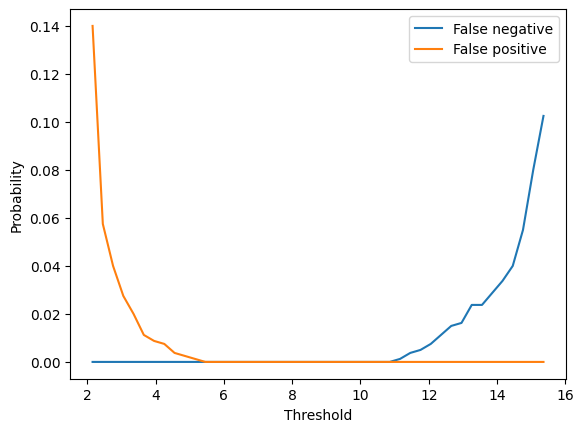

In [ ]:
plt.plot(values_th,false_neg,label="False negative")
plt.plot(values_th,false_pos,label="False positive")
plt.xlabel("Threshold")
plt.ylabel("Probability")
plt.legend()
plt.show()

In [ ]:
pred=[]
for im in tqdm(test):
    
    img= im.reshape(1,50,1024,1)
    error=model.evaluate(img,img,batch_size=1)
    if(error<normal_values[0]+normal_values[1]): ## mean+sdtv of the normal matrixes
      pred.append(0)
    else:
      pred.append(1)

correct=np.array(pred)==labels_test

## make predictions on the test set and create a mask where we can see if the prediction was correct for a given threshold

  0%|          | 0/800 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9979


  0%|          | 2/800 [00:00<00:58, 13.66it/s]

1/1 [==============================] - 0s 32ms/step - loss: 16.3583


  0%|          | 4/800 [00:00<01:01, 13.02it/s]

1/1 [==============================] - 0s 31ms/step - loss: 16.0029


  1%|          | 6/800 [00:00<00:58, 13.67it/s]

1/1 [==============================] - 0s 25ms/step - loss: 15.9941


  1%|          | 8/800 [00:00<00:57, 13.78it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9316


  1%|▏         | 10/800 [00:00<00:56, 14.05it/s]

1/1 [==============================] - 0s 26ms/step - loss: 15.4544


  2%|▏         | 12/800 [00:00<00:55, 14.14it/s]

1/1 [==============================] - 0s 28ms/step - loss: 16.6593


  2%|▏         | 14/800 [00:01<00:55, 14.24it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9782


  2%|▏         | 16/800 [00:01<00:55, 14.21it/s]

1/1 [==============================] - 0s 26ms/step - loss: 17.1031


  2%|▏         | 18/800 [00:01<00:53, 14.52it/s]

1/1 [==============================] - 0s 30ms/step - loss: 17.1404


  2%|▎         | 20/800 [00:01<00:55, 14.02it/s]

1/1 [==============================] - 0s 27ms/step - loss: 14.1485


  3%|▎         | 22/800 [00:01<00:57, 13.57it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.5825


  3%|▎         | 24/800 [00:01<00:57, 13.57it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9319


  3%|▎         | 26/800 [00:01<00:55, 14.00it/s]

1/1 [==============================] - 0s 26ms/step - loss: 11.8436


  4%|▎         | 28/800 [00:02<00:54, 14.11it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.2361


  4%|▍         | 30/800 [00:02<00:55, 13.93it/s]

1/1 [==============================] - 0s 26ms/step - loss: 15.7122


  4%|▍         | 32/800 [00:02<00:54, 14.01it/s]

1/1 [==============================] - 0s 27ms/step - loss: 16.7490


  4%|▍         | 34/800 [00:02<00:55, 13.91it/s]

1/1 [==============================] - 0s 25ms/step - loss: 17.3182


  4%|▍         | 36/800 [00:02<00:56, 13.57it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9122


  5%|▍         | 38/800 [00:02<00:55, 13.74it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9740


  5%|▌         | 40/800 [00:02<00:56, 13.49it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.2040


  5%|▌         | 42/800 [00:03<00:55, 13.61it/s]

1/1 [==============================] - 0s 32ms/step - loss: 12.2723


  6%|▌         | 44/800 [00:03<00:54, 13.82it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1723


  6%|▌         | 46/800 [00:03<00:54, 13.93it/s]

1/1 [==============================] - 0s 26ms/step - loss: 15.6185


  6%|▌         | 48/800 [00:03<00:52, 14.30it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.7345


  6%|▋         | 50/800 [00:03<00:53, 13.94it/s]

1/1 [==============================] - 0s 26ms/step - loss: 11.1898


  6%|▋         | 52/800 [00:03<00:53, 14.00it/s]

1/1 [==============================] - 0s 28ms/step - loss: 13.7368


  7%|▋         | 54/800 [00:03<00:52, 14.13it/s]

1/1 [==============================] - 0s 28ms/step - loss: 17.0399


  7%|▋         | 56/800 [00:04<00:51, 14.45it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.2923


  7%|▋         | 58/800 [00:04<00:53, 13.86it/s]

1/1 [==============================] - 0s 27ms/step - loss: 16.7535


  8%|▊         | 60/800 [00:04<00:53, 13.82it/s]

1/1 [==============================] - 0s 25ms/step - loss: 14.5859


  8%|▊         | 62/800 [00:04<00:52, 14.19it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.7779


  8%|▊         | 64/800 [00:04<00:53, 13.74it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9855


  8%|▊         | 66/800 [00:04<00:53, 13.75it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9700


  8%|▊         | 68/800 [00:04<00:52, 13.84it/s]

1/1 [==============================] - 0s 25ms/step - loss: 15.5266


  9%|▉         | 70/800 [00:05<00:53, 13.76it/s]

1/1 [==============================] - 0s 28ms/step - loss: 16.1723


  9%|▉         | 72/800 [00:05<00:56, 12.88it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9636


  9%|▉         | 74/800 [00:05<00:54, 13.23it/s]

1/1 [==============================] - 0s 58ms/step - loss: 1.9638


 10%|▉         | 76/800 [00:05<01:09, 10.48it/s]

1/1 [==============================] - 0s 41ms/step - loss: 1.9660


 10%|▉         | 78/800 [00:05<01:12,  9.95it/s]

1/1 [==============================] - 0s 28ms/step - loss: 16.0450


 10%|█         | 80/800 [00:06<01:17,  9.28it/s]

1/1 [==============================] - 0s 29ms/step - loss: 16.2344


 10%|█         | 82/800 [00:06<01:09, 10.27it/s]

1/1 [==============================] - 0s 44ms/step - loss: 2.0515


 10%|█         | 84/800 [00:06<01:20,  8.85it/s]

1/1 [==============================] - 0s 47ms/step - loss: 1.9892


 11%|█         | 85/800 [00:06<01:22,  8.70it/s]

1/1 [==============================] - 0s 42ms/step - loss: 2.1830


 11%|█         | 86/800 [00:06<01:23,  8.59it/s]

1/1 [==============================] - 0s 55ms/step - loss: 1.9439


 11%|█         | 87/800 [00:06<01:23,  8.50it/s]

1/1 [==============================] - 0s 35ms/step - loss: 16.2019


 11%|█         | 88/800 [00:07<01:22,  8.67it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9961


 11%|█▏        | 90/800 [00:07<01:09, 10.21it/s]

1/1 [==============================] - 0s 34ms/step - loss: 1.9977


 12%|█▏        | 92/800 [00:07<01:01, 11.48it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.1773


 12%|█▏        | 94/800 [00:07<01:06, 10.60it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9560


 12%|█▏        | 96/800 [00:07<00:59, 11.77it/s]

1/1 [==============================] - 0s 54ms/step - loss: 2.3623


 12%|█▏        | 98/800 [00:07<01:04, 10.90it/s]

1/1 [==============================] - 0s 25ms/step - loss: 13.1581


 12%|█▎        | 100/800 [00:08<01:00, 11.60it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.0074


 13%|█▎        | 102/800 [00:08<00:56, 12.42it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.0224


 13%|█▎        | 104/800 [00:08<00:58, 11.93it/s]

1/1 [==============================] - 0s 37ms/step - loss: 4.2613


 13%|█▎        | 106/800 [00:08<00:59, 11.59it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.2472


 14%|█▎        | 108/800 [00:08<01:07, 10.33it/s]

1/1 [==============================] - 0s 35ms/step - loss: 1.9372


 14%|█▍        | 110/800 [00:08<01:07, 10.20it/s]

1/1 [==============================] - 0s 38ms/step - loss: 1.9617


 14%|█▍        | 112/800 [00:09<01:08, 10.03it/s]

1/1 [==============================] - 0s 120ms/step - loss: 2.1064


 14%|█▍        | 114/800 [00:09<01:27,  7.86it/s]

1/1 [==============================] - 0s 138ms/step - loss: 16.0083


 14%|█▍        | 115/800 [00:09<01:54,  5.98it/s]

1/1 [==============================] - 0s 60ms/step - loss: 1.9457


 14%|█▍        | 116/800 [00:10<01:52,  6.06it/s]

1/1 [==============================] - 0s 68ms/step - loss: 16.2516


 15%|█▍        | 117/800 [00:10<01:54,  5.95it/s]

1/1 [==============================] - 0s 74ms/step - loss: 1.8952


 15%|█▍        | 118/800 [00:10<01:58,  5.76it/s]

1/1 [==============================] - 0s 73ms/step - loss: 14.8379


 15%|█▍        | 119/800 [00:10<02:05,  5.41it/s]

1/1 [==============================] - 0s 110ms/step - loss: 16.9727


 15%|█▌        | 120/800 [00:10<02:16,  4.97it/s]

1/1 [==============================] - 0s 84ms/step - loss: 1.9744


 15%|█▌        | 121/800 [00:11<02:18,  4.90it/s]

1/1 [==============================] - 0s 65ms/step - loss: 15.9086


 15%|█▌        | 122/800 [00:11<02:15,  5.01it/s]

1/1 [==============================] - 0s 67ms/step - loss: 14.9924


 15%|█▌        | 123/800 [00:11<02:12,  5.13it/s]

1/1 [==============================] - 0s 106ms/step - loss: 1.9759


 16%|█▌        | 124/800 [00:11<02:18,  4.87it/s]

1/1 [==============================] - 0s 81ms/step - loss: 17.2828


 16%|█▌        | 125/800 [00:11<02:18,  4.89it/s]

1/1 [==============================] - 0s 95ms/step - loss: 3.8787


 16%|█▌        | 126/800 [00:12<02:22,  4.74it/s]

1/1 [==============================] - 0s 38ms/step - loss: 17.3532


 16%|█▌        | 127/800 [00:12<02:04,  5.39it/s]

1/1 [==============================] - 0s 39ms/step - loss: 1.9581


 16%|█▌        | 128/800 [00:12<01:53,  5.90it/s]

1/1 [==============================] - 0s 51ms/step - loss: 1.9774


 16%|█▌        | 129/800 [00:12<01:51,  6.02it/s]

1/1 [==============================] - 0s 44ms/step - loss: 16.8227


 16%|█▋        | 130/800 [00:12<01:45,  6.34it/s]

1/1 [==============================] - 0s 40ms/step - loss: 15.0829


 16%|█▋        | 131/800 [00:12<01:37,  6.88it/s]

1/1 [==============================] - 0s 117ms/step - loss: 16.2327


 17%|█▋        | 133/800 [00:13<01:55,  5.77it/s]

1/1 [==============================] - 0s 96ms/step - loss: 16.1522


 17%|█▋        | 134/800 [00:13<02:09,  5.14it/s]

1/1 [==============================] - 0s 36ms/step - loss: 1.9757


 17%|█▋        | 135/800 [00:13<01:57,  5.66it/s]

1/1 [==============================] - 0s 21ms/step - loss: 16.7673


 17%|█▋        | 137/800 [00:13<01:25,  7.74it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0711


 17%|█▋        | 139/800 [00:13<01:09,  9.47it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.2959


 18%|█▊        | 141/800 [00:14<01:01, 10.80it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.8934


 18%|█▊        | 143/800 [00:14<00:54, 12.06it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.7634


 18%|█▊        | 145/800 [00:14<00:50, 13.06it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9512


 18%|█▊        | 147/800 [00:14<00:47, 13.69it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9141


 19%|█▊        | 149/800 [00:14<00:44, 14.57it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.8942


 19%|█▉        | 151/800 [00:14<00:44, 14.67it/s]

1/1 [==============================] - 0s 23ms/step - loss: 15.4603


 19%|█▉        | 153/800 [00:14<00:43, 14.97it/s]

1/1 [==============================] - 0s 26ms/step - loss: 14.6216


 19%|█▉        | 155/800 [00:14<00:43, 14.87it/s]

1/1 [==============================] - 0s 24ms/step - loss: 12.0246


 20%|█▉        | 157/800 [00:15<00:42, 15.26it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9549


 20%|█▉        | 159/800 [00:15<00:43, 14.65it/s]

1/1 [==============================] - 0s 26ms/step - loss: 15.8042


 20%|██        | 161/800 [00:15<00:44, 14.45it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.3899


 20%|██        | 163/800 [00:15<00:44, 14.23it/s]

1/1 [==============================] - 0s 27ms/step - loss: 16.3924


 21%|██        | 165/800 [00:15<00:45, 14.05it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9848


 21%|██        | 167/800 [00:15<00:45, 13.86it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9731


 21%|██        | 169/800 [00:15<00:46, 13.47it/s]

1/1 [==============================] - 0s 27ms/step - loss: 16.0129


 21%|██▏       | 171/800 [00:16<00:45, 13.91it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9404


 22%|██▏       | 173/800 [00:16<00:45, 13.75it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.0524


 22%|██▏       | 175/800 [00:16<00:44, 13.99it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9747


 22%|██▏       | 177/800 [00:16<00:44, 14.02it/s]

1/1 [==============================] - 0s 23ms/step - loss: 15.3832


 22%|██▏       | 179/800 [00:16<00:43, 14.19it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9673


 23%|██▎       | 181/800 [00:16<00:42, 14.65it/s]

1/1 [==============================] - 0s 25ms/step - loss: 17.2439


 23%|██▎       | 183/800 [00:16<00:43, 14.28it/s]

1/1 [==============================] - 0s 26ms/step - loss: 17.1121


 23%|██▎       | 185/800 [00:17<00:42, 14.39it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.3481


 23%|██▎       | 187/800 [00:17<00:42, 14.44it/s]

1/1 [==============================] - 0s 27ms/step - loss: 3.6062


 24%|██▎       | 189/800 [00:17<00:41, 14.60it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.0387


 24%|██▍       | 191/800 [00:17<00:40, 14.99it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.4214


 24%|██▍       | 193/800 [00:17<00:40, 15.12it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0024


 24%|██▍       | 195/800 [00:17<00:39, 15.42it/s]

1/1 [==============================] - 0s 26ms/step - loss: 15.3824


 25%|██▍       | 197/800 [00:17<00:39, 15.18it/s]

1/1 [==============================] - 0s 24ms/step - loss: 16.9175


 25%|██▍       | 199/800 [00:17<00:39, 15.05it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9737


 25%|██▌       | 201/800 [00:18<00:40, 14.71it/s]

1/1 [==============================] - 0s 27ms/step - loss: 3.6819


 25%|██▌       | 203/800 [00:18<00:41, 14.53it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.4770


 26%|██▌       | 205/800 [00:18<00:41, 14.40it/s]

1/1 [==============================] - 0s 28ms/step - loss: 16.5690


 26%|██▌       | 207/800 [00:18<00:41, 14.30it/s]

1/1 [==============================] - 0s 26ms/step - loss: 3.6339


 26%|██▌       | 209/800 [00:18<00:40, 14.48it/s]

1/1 [==============================] - 0s 26ms/step - loss: 16.7999


 26%|██▋       | 211/800 [00:18<00:41, 14.32it/s]

1/1 [==============================] - 0s 25ms/step - loss: 16.7686


 27%|██▋       | 213/800 [00:18<00:40, 14.59it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9949


 27%|██▋       | 215/800 [00:19<00:40, 14.58it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9738


 27%|██▋       | 217/800 [00:19<00:39, 14.62it/s]

1/1 [==============================] - 0s 26ms/step - loss: 17.1306


 27%|██▋       | 219/800 [00:19<00:40, 14.52it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9663


 28%|██▊       | 221/800 [00:19<00:40, 14.17it/s]

1/1 [==============================] - 0s 26ms/step - loss: 14.4002


 28%|██▊       | 223/800 [00:19<00:40, 14.19it/s]

1/1 [==============================] - 0s 23ms/step - loss: 16.3171


 28%|██▊       | 225/800 [00:19<00:41, 13.93it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9795


 28%|██▊       | 227/800 [00:19<00:40, 14.02it/s]

1/1 [==============================] - 0s 30ms/step - loss: 16.8038


 29%|██▊       | 229/800 [00:20<00:41, 13.86it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9826


 29%|██▉       | 231/800 [00:20<00:40, 14.06it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9758


 29%|██▉       | 233/800 [00:20<00:40, 14.03it/s]

1/1 [==============================] - 0s 28ms/step - loss: 15.6185


 29%|██▉       | 235/800 [00:20<00:40, 13.83it/s]

1/1 [==============================] - 0s 28ms/step - loss: 16.2166


 30%|██▉       | 237/800 [00:20<00:41, 13.57it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9933


 30%|██▉       | 239/800 [00:20<00:41, 13.65it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9098


 30%|███       | 241/800 [00:20<00:41, 13.48it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9051


 30%|███       | 243/800 [00:21<00:41, 13.36it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.1697


 31%|███       | 245/800 [00:21<00:41, 13.26it/s]

1/1 [==============================] - 0s 28ms/step - loss: 15.4307


 31%|███       | 247/800 [00:21<00:41, 13.47it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9514


 31%|███       | 249/800 [00:21<00:40, 13.59it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1786


 31%|███▏      | 251/800 [00:21<00:39, 13.78it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.9352


 32%|███▏      | 253/800 [00:21<00:39, 13.71it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9026


 32%|███▏      | 255/800 [00:21<00:39, 13.68it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9691


 32%|███▏      | 257/800 [00:22<00:38, 13.98it/s]

1/1 [==============================] - 0s 27ms/step - loss: 16.1226


 32%|███▏      | 259/800 [00:22<00:39, 13.82it/s]

1/1 [==============================] - 0s 45ms/step - loss: 1.9657


 33%|███▎      | 261/800 [00:22<00:41, 12.97it/s]

1/1 [==============================] - 0s 44ms/step - loss: 16.0699


 33%|███▎      | 263/800 [00:22<00:46, 11.66it/s]

1/1 [==============================] - 0s 39ms/step - loss: 14.9465


 33%|███▎      | 265/800 [00:22<00:46, 11.43it/s]

1/1 [==============================] - 0s 34ms/step - loss: 17.2126


 33%|███▎      | 267/800 [00:23<00:47, 11.22it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.3788


 34%|███▎      | 269/800 [00:23<00:49, 10.78it/s]

1/1 [==============================] - 0s 40ms/step - loss: 2.0686


 34%|███▍      | 271/800 [00:23<00:49, 10.66it/s]

1/1 [==============================] - 0s 40ms/step - loss: 1.9837


 34%|███▍      | 273/800 [00:23<00:50, 10.38it/s]

1/1 [==============================] - 0s 38ms/step - loss: 1.9726


 34%|███▍      | 275/800 [00:23<00:50, 10.35it/s]

1/1 [==============================] - 0s 36ms/step - loss: 16.2356


 35%|███▍      | 277/800 [00:24<00:51, 10.23it/s]

1/1 [==============================] - 0s 36ms/step - loss: 1.9614


 35%|███▍      | 279/800 [00:24<00:50, 10.28it/s]

1/1 [==============================] - 0s 36ms/step - loss: 13.2258


 35%|███▌      | 281/800 [00:24<00:49, 10.49it/s]

1/1 [==============================] - 0s 34ms/step - loss: 1.9680


 35%|███▌      | 283/800 [00:24<00:49, 10.48it/s]

1/1 [==============================] - 0s 38ms/step - loss: 16.6282


 36%|███▌      | 285/800 [00:24<00:49, 10.45it/s]

1/1 [==============================] - 0s 36ms/step - loss: 2.0689


 36%|███▌      | 287/800 [00:24<00:49, 10.41it/s]

1/1 [==============================] - 0s 27ms/step - loss: 15.8544


 36%|███▌      | 289/800 [00:25<00:47, 10.69it/s]

1/1 [==============================] - 0s 27ms/step - loss: 3.2806


 36%|███▋      | 291/800 [00:25<00:44, 11.49it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.6331


 37%|███▋      | 293/800 [00:25<00:41, 12.21it/s]

1/1 [==============================] - 0s 26ms/step - loss: 15.6293


 37%|███▋      | 295/800 [00:25<00:39, 12.67it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.0321


 37%|███▋      | 297/800 [00:25<00:39, 12.60it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.0407


 37%|███▋      | 299/800 [00:25<00:38, 12.96it/s]

1/1 [==============================] - 0s 28ms/step - loss: 16.6410


 38%|███▊      | 301/800 [00:26<00:37, 13.32it/s]

1/1 [==============================] - 0s 30ms/step - loss: 16.7131


 38%|███▊      | 303/800 [00:26<00:37, 13.23it/s]

1/1 [==============================] - 0s 27ms/step - loss: 16.2225


 38%|███▊      | 305/800 [00:26<00:37, 13.23it/s]

1/1 [==============================] - 0s 32ms/step - loss: 16.3772


 38%|███▊      | 307/800 [00:26<00:36, 13.35it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9601


 39%|███▊      | 309/800 [00:26<00:35, 13.82it/s]

1/1 [==============================] - 0s 27ms/step - loss: 16.5485


 39%|███▉      | 311/800 [00:26<00:35, 13.95it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9721


 39%|███▉      | 313/800 [00:26<00:34, 14.00it/s]

1/1 [==============================] - 0s 27ms/step - loss: 15.6607


 39%|███▉      | 315/800 [00:27<00:34, 13.96it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9816


 40%|███▉      | 317/800 [00:27<00:34, 13.82it/s]

1/1 [==============================] - 0s 29ms/step - loss: 14.6088


 40%|███▉      | 319/800 [00:27<00:34, 13.86it/s]

1/1 [==============================] - 0s 26ms/step - loss: 16.9916


 40%|████      | 321/800 [00:27<00:34, 13.89it/s]

1/1 [==============================] - 0s 28ms/step - loss: 17.2388


 40%|████      | 323/800 [00:27<00:35, 13.57it/s]

1/1 [==============================] - 0s 29ms/step - loss: 16.3550


 41%|████      | 325/800 [00:27<00:34, 13.63it/s]

1/1 [==============================] - 0s 27ms/step - loss: 4.2045


 41%|████      | 327/800 [00:27<00:34, 13.80it/s]

1/1 [==============================] - 0s 27ms/step - loss: 16.9022


 41%|████      | 329/800 [00:28<00:34, 13.78it/s]

1/1 [==============================] - 0s 29ms/step - loss: 15.3864


 41%|████▏     | 331/800 [00:28<00:34, 13.54it/s]

1/1 [==============================] - 0s 30ms/step - loss: 16.5445


 42%|████▏     | 333/800 [00:28<00:34, 13.52it/s]

1/1 [==============================] - 0s 28ms/step - loss: 16.8460


 42%|████▏     | 335/800 [00:28<00:34, 13.48it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1800


 42%|████▏     | 337/800 [00:28<00:33, 13.68it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0624


 42%|████▏     | 339/800 [00:28<00:34, 13.53it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.0047


 43%|████▎     | 341/800 [00:28<00:33, 13.89it/s]

1/1 [==============================] - 0s 27ms/step - loss: 13.2507


 43%|████▎     | 343/800 [00:29<00:32, 13.96it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9664


 43%|████▎     | 345/800 [00:29<00:33, 13.76it/s]

1/1 [==============================] - 0s 23ms/step - loss: 3.3896


 43%|████▎     | 347/800 [00:29<00:32, 13.82it/s]

1/1 [==============================] - 0s 26ms/step - loss: 17.3659


 44%|████▎     | 349/800 [00:29<00:32, 13.78it/s]

1/1 [==============================] - 0s 26ms/step - loss: 17.1532


 44%|████▍     | 351/800 [00:29<00:32, 13.83it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1635


 44%|████▍     | 353/800 [00:29<00:32, 13.81it/s]

1/1 [==============================] - 0s 29ms/step - loss: 16.4517


 44%|████▍     | 355/800 [00:29<00:31, 14.14it/s]

1/1 [==============================] - 0s 28ms/step - loss: 16.3609


 45%|████▍     | 357/800 [00:30<00:32, 13.69it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.0060


 45%|████▍     | 359/800 [00:30<00:32, 13.62it/s]

1/1 [==============================] - 0s 24ms/step - loss: 15.9266


 45%|████▌     | 361/800 [00:30<00:31, 14.10it/s]

1/1 [==============================] - 0s 28ms/step - loss: 15.6240


 45%|████▌     | 363/800 [00:30<00:31, 13.93it/s]

1/1 [==============================] - 0s 26ms/step - loss: 17.0109


 46%|████▌     | 365/800 [00:30<00:31, 13.99it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.2859


 46%|████▌     | 367/800 [00:31<00:56,  7.65it/s]

1/1 [==============================] - 0s 33ms/step - loss: 1.9343


 46%|████▌     | 369/800 [00:31<00:49,  8.66it/s]

1/1 [==============================] - 0s 38ms/step - loss: 15.7196


 46%|████▋     | 371/800 [00:31<00:44,  9.57it/s]

1/1 [==============================] - 0s 31ms/step - loss: 15.1441


 47%|████▋     | 373/800 [00:31<00:40, 10.53it/s]

1/1 [==============================] - 0s 34ms/step - loss: 17.0553


 47%|████▋     | 375/800 [00:31<00:39, 10.83it/s]

1/1 [==============================] - 0s 33ms/step - loss: 15.8190


 47%|████▋     | 377/800 [00:32<00:37, 11.15it/s]

1/1 [==============================] - 0s 32ms/step - loss: 16.7599


 47%|████▋     | 379/800 [00:32<00:35, 11.70it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.9858


 48%|████▊     | 381/800 [00:32<00:35, 11.87it/s]

1/1 [==============================] - 0s 31ms/step - loss: 16.5446


 48%|████▊     | 383/800 [00:32<00:34, 11.98it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9414


 48%|████▊     | 385/800 [00:32<00:33, 12.28it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.0933


 48%|████▊     | 387/800 [00:32<00:33, 12.15it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9585


 49%|████▊     | 389/800 [00:32<00:33, 12.38it/s]

1/1 [==============================] - 0s 33ms/step - loss: 1.9302


 49%|████▉     | 391/800 [00:33<00:33, 12.18it/s]

1/1 [==============================] - 0s 33ms/step - loss: 15.7361


 49%|████▉     | 393/800 [00:33<00:35, 11.31it/s]

1/1 [==============================] - 0s 38ms/step - loss: 15.3003


 49%|████▉     | 395/800 [00:33<00:35, 11.48it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9577


 50%|████▉     | 397/800 [00:33<00:34, 11.60it/s]

1/1 [==============================] - 0s 34ms/step - loss: 16.6850


 50%|████▉     | 399/800 [00:33<00:34, 11.52it/s]

1/1 [==============================] - 0s 35ms/step - loss: 15.8014


 50%|█████     | 401/800 [00:34<00:34, 11.47it/s]

1/1 [==============================] - 0s 33ms/step - loss: 1.9794


 50%|█████     | 403/800 [00:34<00:33, 11.80it/s]

1/1 [==============================] - 0s 34ms/step - loss: 17.1725


 51%|█████     | 405/800 [00:34<00:33, 11.90it/s]

1/1 [==============================] - 0s 41ms/step - loss: 15.5251


 51%|█████     | 407/800 [00:34<00:32, 12.15it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9370


 51%|█████     | 409/800 [00:34<00:31, 12.23it/s]

1/1 [==============================] - 0s 31ms/step - loss: 16.3475


 51%|█████▏    | 411/800 [00:34<00:31, 12.26it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9749


 52%|█████▏    | 413/800 [00:34<00:31, 12.39it/s]

1/1 [==============================] - 0s 42ms/step - loss: 17.4125


 52%|█████▏    | 415/800 [00:35<00:32, 11.71it/s]

1/1 [==============================] - 0s 43ms/step - loss: 17.2596


 52%|█████▏    | 417/800 [00:35<00:36, 10.58it/s]

1/1 [==============================] - 0s 39ms/step - loss: 1.9682


 52%|█████▏    | 419/800 [00:35<00:36, 10.35it/s]

1/1 [==============================] - 0s 39ms/step - loss: 17.2536


 53%|█████▎    | 421/800 [00:35<00:37, 10.16it/s]

1/1 [==============================] - 0s 38ms/step - loss: 1.9385


 53%|█████▎    | 423/800 [00:36<00:36, 10.20it/s]

1/1 [==============================] - 0s 45ms/step - loss: 1.9394


 53%|█████▎    | 425/800 [00:36<00:37,  9.91it/s]

1/1 [==============================] - 0s 37ms/step - loss: 1.9793


 53%|█████▎    | 427/800 [00:36<00:38,  9.67it/s]

1/1 [==============================] - 0s 39ms/step - loss: 14.9598


 54%|█████▎    | 429/800 [00:36<00:37, 10.02it/s]

1/1 [==============================] - 0s 37ms/step - loss: 17.1782


 54%|█████▍    | 431/800 [00:36<00:36, 10.14it/s]

1/1 [==============================] - 0s 42ms/step - loss: 16.5680


 54%|█████▍    | 433/800 [00:37<00:36, 10.12it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.0499


 54%|█████▍    | 435/800 [00:37<00:36, 10.07it/s]

1/1 [==============================] - 0s 39ms/step - loss: 1.9743


 55%|█████▍    | 437/800 [00:37<00:36, 10.06it/s]

1/1 [==============================] - 0s 22ms/step - loss: 17.1307


 55%|█████▍    | 439/800 [00:37<00:32, 11.21it/s]

1/1 [==============================] - 0s 28ms/step - loss: 13.5849


 55%|█████▌    | 441/800 [00:37<00:29, 12.15it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9123


 55%|█████▌    | 443/800 [00:37<00:28, 12.50it/s]

1/1 [==============================] - 0s 25ms/step - loss: 16.0460


 56%|█████▌    | 445/800 [00:37<00:26, 13.19it/s]

1/1 [==============================] - 0s 25ms/step - loss: 16.1675


 56%|█████▌    | 447/800 [00:38<00:25, 13.92it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9811


 56%|█████▌    | 449/800 [00:38<00:24, 14.12it/s]

1/1 [==============================] - 0s 33ms/step - loss: 1.9642


 56%|█████▋    | 451/800 [00:38<00:25, 13.64it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9496


 57%|█████▋    | 453/800 [00:38<00:25, 13.80it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9369


 57%|█████▋    | 455/800 [00:38<00:24, 14.10it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9839


 57%|█████▋    | 457/800 [00:38<00:24, 14.05it/s]

1/1 [==============================] - 0s 31ms/step - loss: 17.2166


 57%|█████▋    | 459/800 [00:38<00:24, 13.91it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9419


 58%|█████▊    | 461/800 [00:39<00:24, 13.69it/s]

1/1 [==============================] - 0s 37ms/step - loss: 15.2503


 58%|█████▊    | 463/800 [00:39<00:25, 13.32it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9330


 58%|█████▊    | 465/800 [00:39<00:24, 13.62it/s]

1/1 [==============================] - 0s 25ms/step - loss: 15.4606


 58%|█████▊    | 467/800 [00:39<00:23, 14.10it/s]

1/1 [==============================] - 0s 25ms/step - loss: 17.4294


 59%|█████▊    | 469/800 [00:39<00:23, 14.11it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1602


 59%|█████▉    | 471/800 [00:39<00:23, 14.27it/s]

1/1 [==============================] - 0s 29ms/step - loss: 16.3818


 59%|█████▉    | 473/800 [00:39<00:22, 14.39it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9608


 59%|█████▉    | 475/800 [00:40<00:22, 14.67it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.3470


 60%|█████▉    | 477/800 [00:40<00:22, 14.17it/s]

1/1 [==============================] - 0s 24ms/step - loss: 17.3042


 60%|█████▉    | 479/800 [00:40<00:22, 14.49it/s]

1/1 [==============================] - 0s 27ms/step - loss: 12.6305


 60%|██████    | 481/800 [00:40<00:22, 14.08it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9913


 60%|██████    | 483/800 [00:40<00:21, 14.60it/s]

1/1 [==============================] - 0s 26ms/step - loss: 15.8443


 61%|██████    | 485/800 [00:40<00:22, 14.14it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.8794


 61%|██████    | 487/800 [00:40<00:21, 14.58it/s]

1/1 [==============================] - 0s 25ms/step - loss: 14.2614


 61%|██████    | 489/800 [00:41<00:21, 14.55it/s]

1/1 [==============================] - 0s 28ms/step - loss: 3.0147


 61%|██████▏   | 491/800 [00:41<00:21, 14.69it/s]

1/1 [==============================] - 0s 27ms/step - loss: 14.8626


 62%|██████▏   | 493/800 [00:41<00:21, 14.38it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0296


 62%|██████▏   | 495/800 [00:41<00:21, 14.19it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9403


 62%|██████▏   | 497/800 [00:41<00:21, 14.06it/s]

1/1 [==============================] - 0s 29ms/step - loss: 17.6860


 62%|██████▏   | 499/800 [00:41<00:21, 13.92it/s]

1/1 [==============================] - 0s 29ms/step - loss: 15.6338


 63%|██████▎   | 501/800 [00:41<00:22, 13.59it/s]

1/1 [==============================] - 0s 26ms/step - loss: 15.8805


 63%|██████▎   | 503/800 [00:42<00:21, 13.54it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9626


 63%|██████▎   | 505/800 [00:42<00:21, 13.92it/s]

1/1 [==============================] - 0s 24ms/step - loss: 12.7263


 63%|██████▎   | 507/800 [00:42<00:20, 14.39it/s]

1/1 [==============================] - 0s 27ms/step - loss: 15.8182


 64%|██████▎   | 509/800 [00:42<00:20, 14.25it/s]

1/1 [==============================] - 0s 24ms/step - loss: 15.3450


 64%|██████▍   | 511/800 [00:42<00:20, 14.25it/s]

1/1 [==============================] - 0s 26ms/step - loss: 14.9747


 64%|██████▍   | 513/800 [00:42<00:20, 14.12it/s]

1/1 [==============================] - 0s 26ms/step - loss: 16.3795


 64%|██████▍   | 515/800 [00:42<00:20, 14.23it/s]

1/1 [==============================] - 0s 26ms/step - loss: 4.5956


 65%|██████▍   | 517/800 [00:43<00:19, 14.48it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.6979


 65%|██████▍   | 519/800 [00:43<00:20, 14.01it/s]

1/1 [==============================] - 0s 26ms/step - loss: 15.1872


 65%|██████▌   | 521/800 [00:43<00:19, 14.22it/s]

1/1 [==============================] - 0s 29ms/step - loss: 16.8667


 65%|██████▌   | 523/800 [00:43<00:19, 14.23it/s]

1/1 [==============================] - 0s 27ms/step - loss: 16.7930


 66%|██████▌   | 525/800 [00:43<00:19, 14.46it/s]

1/1 [==============================] - 0s 27ms/step - loss: 16.7515


 66%|██████▌   | 527/800 [00:43<00:19, 14.08it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9626


 66%|██████▌   | 529/800 [00:43<00:19, 14.06it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.4714


 66%|██████▋   | 531/800 [00:44<00:19, 14.12it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9823


 67%|██████▋   | 533/800 [00:44<00:19, 13.65it/s]

1/1 [==============================] - 0s 26ms/step - loss: 17.2940


 67%|██████▋   | 535/800 [00:44<00:19, 13.91it/s]

1/1 [==============================] - 0s 25ms/step - loss: 14.5106


 67%|██████▋   | 537/800 [00:44<00:18, 14.26it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.0827


 67%|██████▋   | 539/800 [00:44<00:18, 14.35it/s]

1/1 [==============================] - 0s 30ms/step - loss: 17.6860


 68%|██████▊   | 541/800 [00:44<00:18, 14.24it/s]

1/1 [==============================] - 0s 26ms/step - loss: 12.4206


 68%|██████▊   | 543/800 [00:44<00:18, 14.27it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.3117


 68%|██████▊   | 545/800 [00:45<00:17, 14.65it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9932


 68%|██████▊   | 547/800 [00:45<00:17, 14.50it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.2167


 69%|██████▊   | 549/800 [00:45<00:17, 14.20it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9574


 69%|██████▉   | 551/800 [00:45<00:17, 14.41it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.7162


 69%|██████▉   | 553/800 [00:45<00:17, 14.12it/s]

1/1 [==============================] - 0s 31ms/step - loss: 17.8836


 69%|██████▉   | 555/800 [00:45<00:17, 14.27it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9534


 70%|██████▉   | 557/800 [00:45<00:16, 14.51it/s]

1/1 [==============================] - 0s 25ms/step - loss: 16.9366


 70%|██████▉   | 559/800 [00:45<00:16, 14.69it/s]

1/1 [==============================] - 0s 28ms/step - loss: 18.0599


 70%|███████   | 561/800 [00:46<00:16, 14.49it/s]

1/1 [==============================] - 0s 28ms/step - loss: 16.0596


 70%|███████   | 563/800 [00:46<00:16, 14.31it/s]

1/1 [==============================] - 0s 27ms/step - loss: 16.6234


 71%|███████   | 565/800 [00:46<00:16, 14.52it/s]

1/1 [==============================] - 0s 33ms/step - loss: 17.2017


 71%|███████   | 567/800 [00:46<00:16, 14.42it/s]

1/1 [==============================] - 0s 31ms/step - loss: 16.7444


 71%|███████   | 569/800 [00:46<00:15, 14.50it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9914


 71%|███████▏  | 571/800 [00:46<00:16, 14.23it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.0828


 72%|███████▏  | 573/800 [00:46<00:15, 14.20it/s]

1/1 [==============================] - 0s 28ms/step - loss: 15.1286


 72%|███████▏  | 575/800 [00:47<00:15, 14.16it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.2675


 72%|███████▏  | 577/800 [00:47<00:15, 14.30it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9733


 72%|███████▏  | 579/800 [00:47<00:15, 14.25it/s]

1/1 [==============================] - 0s 46ms/step - loss: 16.9004


 73%|███████▎  | 581/800 [00:47<00:16, 13.10it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.8887


 73%|███████▎  | 583/800 [00:47<00:17, 12.34it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9110


 73%|███████▎  | 585/800 [00:47<00:17, 12.04it/s]

1/1 [==============================] - 0s 32ms/step - loss: 17.0332


 73%|███████▎  | 587/800 [00:48<00:17, 12.00it/s]

1/1 [==============================] - 0s 41ms/step - loss: 1.9508


 74%|███████▎  | 589/800 [00:48<00:18, 11.57it/s]

1/1 [==============================] - 0s 38ms/step - loss: 16.3550


 74%|███████▍  | 591/800 [00:48<00:18, 11.35it/s]

1/1 [==============================] - 0s 31ms/step - loss: 15.5163


 74%|███████▍  | 593/800 [00:48<00:19, 10.67it/s]

1/1 [==============================] - 0s 44ms/step - loss: 16.0822


 74%|███████▍  | 595/800 [00:48<00:19, 10.54it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9624


 75%|███████▍  | 597/800 [00:49<00:19, 10.62it/s]

1/1 [==============================] - 0s 36ms/step - loss: 16.5759


 75%|███████▍  | 599/800 [00:49<00:19, 10.40it/s]

1/1 [==============================] - 0s 32ms/step - loss: 1.9534


 75%|███████▌  | 601/800 [00:49<00:19, 10.38it/s]

1/1 [==============================] - 0s 35ms/step - loss: 17.7990


 75%|███████▌  | 603/800 [00:49<00:18, 10.38it/s]

1/1 [==============================] - 0s 38ms/step - loss: 15.1701


 76%|███████▌  | 605/800 [00:49<00:18, 10.43it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9845


 76%|███████▌  | 607/800 [00:49<00:17, 10.86it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.8330


 76%|███████▌  | 609/800 [00:50<00:16, 11.67it/s]

1/1 [==============================] - 0s 23ms/step - loss: 1.9631


 76%|███████▋  | 611/800 [00:50<00:15, 12.34it/s]

1/1 [==============================] - 0s 27ms/step - loss: 17.0073


 77%|███████▋  | 613/800 [00:50<00:14, 12.92it/s]

1/1 [==============================] - 0s 26ms/step - loss: 14.8783


 77%|███████▋  | 615/800 [00:50<00:13, 13.32it/s]

1/1 [==============================] - 0s 27ms/step - loss: 16.8562


 77%|███████▋  | 617/800 [00:50<00:13, 13.49it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0823


 77%|███████▋  | 619/800 [00:50<00:12, 13.98it/s]

1/1 [==============================] - 0s 26ms/step - loss: 15.6727


 78%|███████▊  | 621/800 [00:50<00:12, 13.95it/s]

1/1 [==============================] - 0s 29ms/step - loss: 14.7562


 78%|███████▊  | 623/800 [00:51<00:12, 13.80it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0023


 78%|███████▊  | 625/800 [00:51<00:12, 13.88it/s]

1/1 [==============================] - 0s 28ms/step - loss: 17.6770


 78%|███████▊  | 627/800 [00:51<00:12, 13.84it/s]

1/1 [==============================] - 0s 30ms/step - loss: 14.2628


 79%|███████▊  | 629/800 [00:51<00:12, 13.40it/s]

1/1 [==============================] - 0s 27ms/step - loss: 16.7361


 79%|███████▉  | 631/800 [00:51<00:13, 12.97it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.8976


 79%|███████▉  | 633/800 [00:51<00:12, 13.05it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9516


 79%|███████▉  | 635/800 [00:52<00:12, 13.11it/s]

1/1 [==============================] - 0s 29ms/step - loss: 17.1527


 80%|███████▉  | 637/800 [00:52<00:12, 13.17it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.2140


 80%|███████▉  | 639/800 [00:52<00:12, 12.98it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.2997


 80%|████████  | 641/800 [00:52<00:12, 13.05it/s]

1/1 [==============================] - 0s 28ms/step - loss: 3.6076


 80%|████████  | 643/800 [00:52<00:12, 12.95it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.5083


 81%|████████  | 645/800 [00:52<00:12, 12.83it/s]

1/1 [==============================] - 0s 32ms/step - loss: 17.0445


 81%|████████  | 647/800 [00:52<00:11, 12.79it/s]

1/1 [==============================] - 0s 43ms/step - loss: 17.0490


 81%|████████  | 649/800 [00:53<00:12, 12.46it/s]

1/1 [==============================] - 0s 24ms/step - loss: 1.9403


 81%|████████▏ | 651/800 [00:53<00:11, 12.83it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9520


 82%|████████▏ | 653/800 [00:53<00:11, 13.05it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9843


 82%|████████▏ | 655/800 [00:53<00:11, 13.04it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9567


 82%|████████▏ | 657/800 [00:53<00:11, 12.89it/s]

1/1 [==============================] - 0s 27ms/step - loss: 16.4414


 82%|████████▏ | 659/800 [00:53<00:10, 13.18it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.3070


 83%|████████▎ | 661/800 [00:54<00:10, 13.41it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9351


 83%|████████▎ | 663/800 [00:54<00:10, 13.52it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0695


 83%|████████▎ | 665/800 [00:54<00:09, 13.67it/s]

1/1 [==============================] - 0s 25ms/step - loss: 15.8997


 83%|████████▎ | 667/800 [00:54<00:09, 13.99it/s]

1/1 [==============================] - 0s 28ms/step - loss: 16.6037


 84%|████████▎ | 669/800 [00:54<00:09, 13.81it/s]

1/1 [==============================] - 0s 26ms/step - loss: 16.8143


 84%|████████▍ | 671/800 [00:54<00:09, 13.72it/s]

1/1 [==============================] - 0s 29ms/step - loss: 17.3216


 84%|████████▍ | 673/800 [00:54<00:09, 13.89it/s]

1/1 [==============================] - 0s 24ms/step - loss: 17.4344


 84%|████████▍ | 675/800 [00:55<00:08, 14.19it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9647


 85%|████████▍ | 677/800 [00:55<00:08, 14.19it/s]

1/1 [==============================] - 0s 26ms/step - loss: 17.1362


 85%|████████▍ | 679/800 [00:55<00:08, 14.20it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.1202


 85%|████████▌ | 681/800 [00:55<00:08, 14.49it/s]

1/1 [==============================] - 0s 26ms/step - loss: 16.5830


 85%|████████▌ | 683/800 [00:55<00:07, 14.63it/s]

1/1 [==============================] - 0s 25ms/step - loss: 16.1664


 86%|████████▌ | 685/800 [00:55<00:07, 14.51it/s]

1/1 [==============================] - 0s 26ms/step - loss: 15.7472


 86%|████████▌ | 687/800 [00:55<00:07, 14.74it/s]

1/1 [==============================] - 0s 25ms/step - loss: 15.7461


 86%|████████▌ | 689/800 [00:55<00:07, 14.38it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9758


 86%|████████▋ | 691/800 [00:56<00:07, 14.03it/s]

1/1 [==============================] - 0s 26ms/step - loss: 17.1013


 87%|████████▋ | 693/800 [00:56<00:07, 14.27it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9727


 87%|████████▋ | 695/800 [00:56<00:07, 14.33it/s]

1/1 [==============================] - 0s 23ms/step - loss: 14.7453


 87%|████████▋ | 697/800 [00:56<00:06, 14.75it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9612


 87%|████████▋ | 699/800 [00:56<00:06, 14.60it/s]

1/1 [==============================] - 0s 28ms/step - loss: 16.7030


 88%|████████▊ | 701/800 [00:56<00:06, 14.20it/s]

1/1 [==============================] - 0s 27ms/step - loss: 16.6376


 88%|████████▊ | 703/800 [00:57<00:07, 13.50it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9419


 88%|████████▊ | 705/800 [00:57<00:07, 13.20it/s]

1/1 [==============================] - 0s 35ms/step - loss: 16.9671


 88%|████████▊ | 707/800 [00:57<00:07, 12.66it/s]

1/1 [==============================] - 0s 33ms/step - loss: 17.6191


 89%|████████▊ | 709/800 [00:57<00:07, 12.57it/s]

1/1 [==============================] - 0s 31ms/step - loss: 17.1579


 89%|████████▉ | 711/800 [00:57<00:07, 12.69it/s]

1/1 [==============================] - 0s 33ms/step - loss: 1.9526


 89%|████████▉ | 713/800 [00:57<00:06, 12.59it/s]

1/1 [==============================] - 0s 31ms/step - loss: 16.3159


 89%|████████▉ | 715/800 [00:57<00:06, 12.46it/s]

1/1 [==============================] - 0s 28ms/step - loss: 14.5733


 90%|████████▉ | 717/800 [00:58<00:06, 12.59it/s]

1/1 [==============================] - 0s 28ms/step - loss: 16.7312


 90%|████████▉ | 719/800 [00:58<00:06, 12.73it/s]

1/1 [==============================] - 0s 25ms/step - loss: 1.9421


 90%|█████████ | 721/800 [00:58<00:06, 12.85it/s]

1/1 [==============================] - 0s 26ms/step - loss: 15.9969


 90%|█████████ | 723/800 [00:58<00:05, 13.08it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.0222


 91%|█████████ | 725/800 [00:58<00:05, 12.79it/s]

1/1 [==============================] - 0s 34ms/step - loss: 1.9710


 91%|█████████ | 727/800 [00:58<00:05, 12.92it/s]

1/1 [==============================] - 0s 26ms/step - loss: 16.1477


 91%|█████████ | 729/800 [00:59<00:05, 13.18it/s]

1/1 [==============================] - 0s 25ms/step - loss: 15.6575


 91%|█████████▏| 731/800 [00:59<00:05, 13.50it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.0323


 92%|█████████▏| 733/800 [00:59<00:05, 13.19it/s]

1/1 [==============================] - 0s 32ms/step - loss: 17.1844


 92%|█████████▏| 735/800 [00:59<00:04, 13.05it/s]

1/1 [==============================] - 0s 29ms/step - loss: 16.0030


 92%|█████████▏| 737/800 [00:59<00:04, 12.94it/s]

1/1 [==============================] - 0s 32ms/step - loss: 17.3897


 92%|█████████▏| 739/800 [00:59<00:04, 13.07it/s]

1/1 [==============================] - 0s 31ms/step - loss: 17.3690


 93%|█████████▎| 741/800 [00:59<00:04, 12.81it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.4811


 93%|█████████▎| 743/800 [01:00<00:04, 11.79it/s]

1/1 [==============================] - 0s 34ms/step - loss: 14.8751


 93%|█████████▎| 745/800 [01:00<00:04, 11.42it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.0343


 93%|█████████▎| 747/800 [01:00<00:04, 10.87it/s]

1/1 [==============================] - 0s 32ms/step - loss: 15.3348


 94%|█████████▎| 749/800 [01:00<00:04, 10.36it/s]

1/1 [==============================] - 0s 30ms/step - loss: 14.0219


 94%|█████████▍| 751/800 [01:00<00:04, 10.48it/s]

1/1 [==============================] - 0s 31ms/step - loss: 16.2828


 94%|█████████▍| 753/800 [01:01<00:04, 10.70it/s]

1/1 [==============================] - 0s 30ms/step - loss: 12.0749


 94%|█████████▍| 755/800 [01:01<00:04, 10.69it/s]

1/1 [==============================] - 0s 31ms/step - loss: 18.0265


 95%|█████████▍| 757/800 [01:01<00:04, 10.68it/s]

1/1 [==============================] - 0s 37ms/step - loss: 1.9773


 95%|█████████▍| 759/800 [01:01<00:03, 10.79it/s]

1/1 [==============================] - 0s 53ms/step - loss: 14.7704


 95%|█████████▌| 761/800 [01:01<00:03, 10.21it/s]

1/1 [==============================] - 0s 38ms/step - loss: 16.6975


 95%|█████████▌| 763/800 [01:02<00:03,  9.93it/s]

1/1 [==============================] - 0s 36ms/step - loss: 15.9932


 96%|█████████▌| 765/800 [01:02<00:03,  9.96it/s]

1/1 [==============================] - 0s 45ms/step - loss: 16.9618


 96%|█████████▌| 767/800 [01:02<00:03,  9.64it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.0009


 96%|█████████▌| 769/800 [01:02<00:03, 10.17it/s]

1/1 [==============================] - 0s 35ms/step - loss: 1.9619


 96%|█████████▋| 771/800 [01:02<00:02, 10.67it/s]

1/1 [==============================] - 0s 31ms/step - loss: 16.0589


 97%|█████████▋| 773/800 [01:03<00:02, 11.07it/s]

1/1 [==============================] - 0s 29ms/step - loss: 15.2440


 97%|█████████▋| 775/800 [01:03<00:02, 11.32it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.1650


 97%|█████████▋| 777/800 [01:03<00:01, 11.69it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.3403


 97%|█████████▋| 779/800 [01:03<00:01, 11.96it/s]

1/1 [==============================] - 0s 32ms/step - loss: 16.4536


 98%|█████████▊| 781/800 [01:03<00:01, 12.12it/s]

1/1 [==============================] - 0s 28ms/step - loss: 15.2271


 98%|█████████▊| 783/800 [01:03<00:01, 12.32it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.3460


 98%|█████████▊| 785/800 [01:04<00:01, 12.16it/s]

1/1 [==============================] - 0s 31ms/step - loss: 15.8611


 98%|█████████▊| 787/800 [01:04<00:01, 12.28it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9691


 99%|█████████▊| 789/800 [01:04<00:00, 12.24it/s]

1/1 [==============================] - 0s 27ms/step - loss: 14.9642


 99%|█████████▉| 791/800 [01:04<00:00, 12.41it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9311


 99%|█████████▉| 793/800 [01:04<00:00, 12.26it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9603


 99%|█████████▉| 795/800 [01:04<00:00, 12.31it/s]

1/1 [==============================] - 0s 37ms/step - loss: 14.7944


100%|█████████▉| 797/800 [01:05<00:00, 12.11it/s]

1/1 [==============================] - 0s 29ms/step - loss: 16.3133


100%|█████████▉| 799/800 [01:05<00:00, 12.10it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.0875


100%|██████████| 800/800 [01:05<00:00, 12.26it/s]


In [ ]:
print("The overall accuracy of the predictor is:",np.sum(correct)/len(pred)*100,"%") ## print the overall accuracy of our predictor 

The overall accuracy of the predictor is: 95.5 %


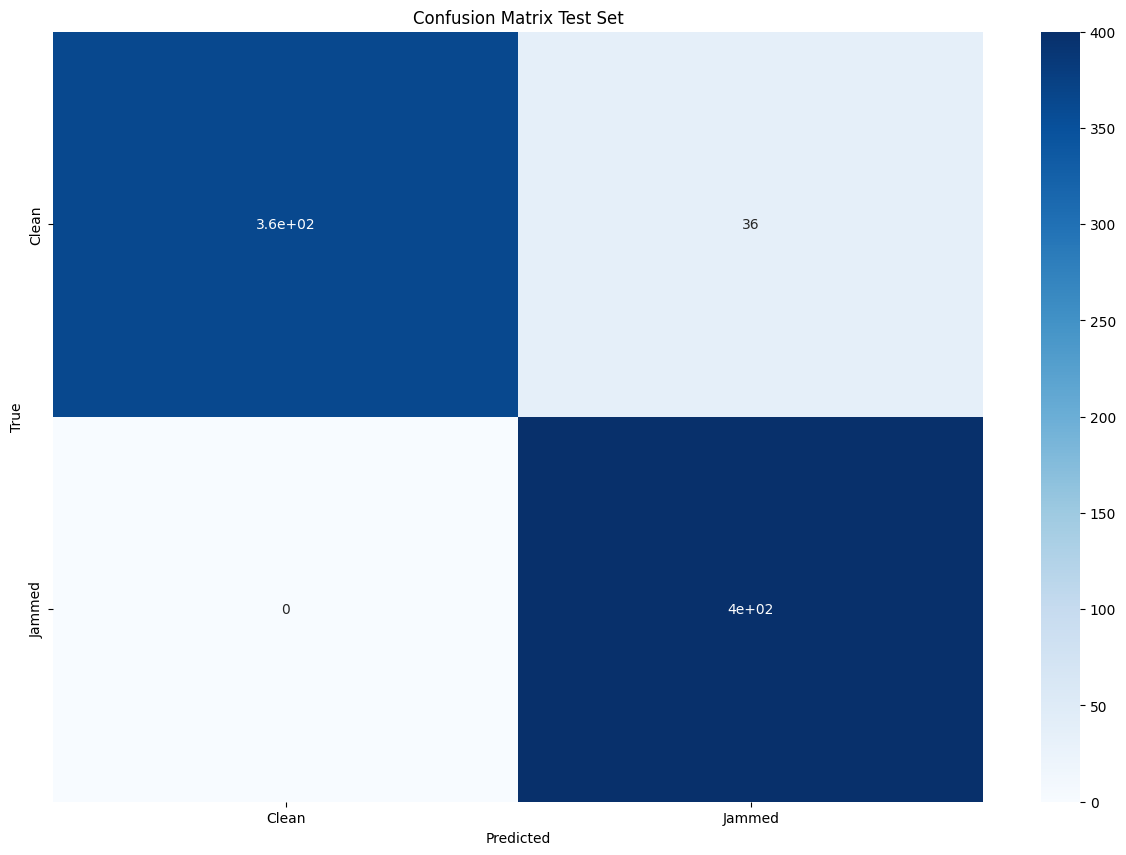

In [ ]:
def print_confusion_matrix(gt, pred):
    class_names= {0: "Clean", 1:"Jammed"}
    num_classes = 2
    cm = confusion_matrix(y_true=gt, y_pred=pred)
    df_cm = pd.DataFrame(cm, index = class_names.values(), columns = class_names.values())
    plt.figure(figsize = (15,10))
    sn.heatmap(df_cm, annot=True, cmap='Blues')
    plt.title('Confusion Matrix Test Set')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

print_confusion_matrix(labels_test,pred) ## print the confusion matrix of our predictor for a given threshold

In [ ]:
num=random.randint(0,len(test))
original_matrix=test[num].reshape(1,50,1024,1) ## take the image
label_mat=labels_test[num] ## corresponding label
if(label_mat==0):
  print("The matrix is NOT an anomaly")
elif(label_mat==1):
  print("The matrix is an anomaly")


The matrix is an anomaly


1/1 [==============================] - 0s 37ms/step


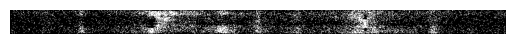

In [ ]:
predicted_matrix=model.predict(original_matrix)
mse_mat=(original_matrix-predicted_matrix)**2 ##mse
mean=normal_values[0] ## mean of rec. error of normal images
stdv=normal_values[1] ## stdv of rec. error of anomaly images
threshold_mse=mean+5*stdv ## i set a threshold
mask=mse_mat>threshold_mse
image = np.zeros_like(mse_mat, dtype=np.uint8)
image[mask] = 0 
image[~mask] = 255  
plt.imshow(image.reshape(50,1024), cmap='gray')
plt.axis("off")
plt.show()

In [ ]:
num=random.randint(0,len(test))
original_matrix=test[num].reshape(1,50,1024,1) ## take the image
label_mat=labels_test[num] ## corresponding label
if(label_mat==0):
  print("The matrix is NOT an anomaly")
elif(label_mat==1):
  print("The matrix is an anomaly")


The matrix is NOT an anomaly


1/1 [==============================] - 0s 28ms/step


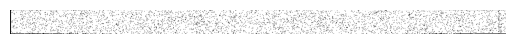

In [ ]:
predicted_matrix=model.predict(original_matrix)
mse_mat=(original_matrix-predicted_matrix)**2 ##mse
mean=normal_values[0]
stdv=normal_values[1]
threshold_mse=mean+5*stdv
mask=mse_mat>threshold_mse
image = np.zeros_like(mse_mat, dtype=np.uint8)
image[mask] = 0  
image[~mask] = 255 
plt.imshow(image.reshape(50,1024), cmap='gray') ## color in black the portions of the spectrum where i have an anomaly
plt.axis("off")
plt.show()

From the previous 4 blocks of code is easy to see the difference between a normal image and an anomaly image for a given threshold from two main aspects:
<br>


1.   The number of black pixels in the trusted image is significantly lower 
2.   The number of the black pixels in the normal image is uniformally-like distributed in the image, while it is clear to see that the black pixels in the anomaly image are concentrated more in the sidebands of the channel (remeber the plots are simmetrically centered around the carrier frequency)

